In [28]:
D = 124  # 100 for dendrite
vector = np.random.rand(D)

In [5]:
import getpass
import math
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt

from urllib.parse import quote_plus

import nexussdk as nxs
from kgforge.core import KnowledgeGraphForge

# Helpers

In [6]:
Statistics = namedtuple('Statistics', 'min max mean std')

In [25]:
def get_es_view(org, project, view_id):
    try:
        return nxs.views.fetch(org, project, view_id=view_id)
    except nxs.HTTPError as e:
        print(e)

def set_elastic_view(forge, view):
    forge._store.service.elastic_endpoint["endpoint"] = "/".join(
        (VIEWS_ENDPOINT, quote_plus(view), "_search"))


def get_all_vectors(forge, resource_limit):
    all_embeddings = forge.elastic(f"""{{
        "from" : 0,
        "size" : {resource_limit},
        "query": {{
            "term": {{"_deprecated": false}}
        }}
    }}
    """)
    vectors = {
        result._source["@id"]: result._source["embedding"]
        for result in all_embeddings
    }
    return vectors


def get_all_scores(forge, vectors, formula, param_name, resource_limit=200, boosting=None):
    score_values = set()
    for k, vector in vectors.items():
        query = f"""{{
          "size": {len(vectors)},
          "query": {{
            "script_score": {{
                "query": {{
                    "bool" : {{
                      "must_not" : {{
                        "term" : {{ "@id": "{k}" }}
                      }},
                      "must": {{ "exists": {{ "field": "embedding" }} }}
                    }}
                }},
                "script": {{
                    "source": "{formula}",
                    "params": {{
                      "{param_name}": {vector}
                    }}
                }}
            }}
          }}
        }}"""

        res = forge.elastic(query)
        for el in res:
            boost_factor = 1
            if boosting:
                boost_factor = 1 + boosting[el._source["@id"]]
            score_values.add(el._score * boost_factor)
    score_values = np.array(list(score_values))
    return score_values


def get_view_stats(forge, vectors, formula, param_name, resource_limit=200, boosting=None):
    score_values = get_all_scores(
        forge, vectors, formula, param_name, resource_limit, boosting)
    return score_values, Statistics(
        score_values.min(),
        score_values.max(),
        score_values.mean(),
        score_values.std())


def register_stats(forge, view_id, sample_size, stats, formula, param_name, boosted=False):
    json_data = {
        "type": "ElasticSearchViewStatistics",
        "boosted": boosted,
        "scriptScore": formula,
        "vectorParameter": param_name,
        "series": [
            {
              "statistic": "min",
              "unitCode": "dimensionless",
              "value": stats.min
            },
            {
              "statistic": "max",
              "unitCode": "dimensionless",
              "value": stats.max
            },
            {
              "statistic": "mean",
              "unitCode": "dimensionless",
              "value": stats.mean
            },
            {
              "statistic": "standard deviation",
              "unitCode": "dimensionless",
              "value": stats.std
            },
            {
              "statistic": "N",
              "unitCode": "dimensionless",
              "value": sample_size
            }
        ],
        "derivation": {
            "type": "Derivation",
            "entity": {
                "id": view_id,
                "type": "ElasticSearchView"
            }
        }
    }

    stats_resource = forge.from_json(json_data)
    forge.register(stats_resource)
    
    
def get_score_deviation(forge, point_id, vector, k, formula, param_name):
    query = f"""{{
      "size": {k},
      "query": {{
        "script_score": {{
          "query": {{
                "exists": {{
                    "field": "embedding"
                }}
          }},
          "script": {{
            "source": "{formula}",
            "params": {{
              "{param_name}": {vector}
            }}
          }}
        }}
      }}
    }}"""

    result = forge.elastic(query)
    scores = set()
    for el in result:
        if point_id != el._source["@id"]:
            scores.add(el._score)
    scores = np.array(list(scores))
    return math.sqrt(((1 - scores)**2).mean())


# def register_boosting_data(forge, view_id, deviation, formula, param_name):
#     factors = [
#         {"entity": {"@id": k}, "value": 1 + v, "unitCode": "dimensionless"}
#         for k, v in data.items()
#     ]
#     resource = forge.from_json({
#         "type": "SimilarityBoostingSeries",
#         "scriptScore": formula,
#         "vectorParameter": param_name,
#         "series": factors,
#         "derivation": {
#             "type": "Derivation",
#             "entity": {
#                 "id": view_id,
#                 "type": "ElasticSearchView"
#             }
#         }
#     })
#     forge.register(resource)
#     return resource.id


def register_boosting_data(forge, view_id, deviation, formula, param_name):
    tag = get_es_view(
        forge._store.bucket.split("/")[0],
        forge._store.bucket.split("/")[-1],
        view_id)["resourceTag"]
    for k, v in deviation.items():
        vector = forge.retrieve(k)
        boosting_data = {
            "value": 1 + v,
            "unitCode": "dimensionless",
            "scriptScore": formula,
            "vectorParameter": param_name,
            "generation": {
                "type": "Generation",
                "activity": {
                    "type": ["SimiarityBoosting", "Activity"],
                    "used": {
                        "id": view_id,
                        "type": "ElasticSearchView"
                    }
                }
            }
        }
        vector.boostingFactor = boosting_data
        forge.update(vector)
        forge.tag(vector, tag)

# Configure forge

In [8]:
TOKEN = getpass.getpass()

········


In [9]:
ENDPOINT = "https://staging.nexus.ocp.bbp.epfl.ch/v1"
ORG = "dke"
PROJECT = "seu-embeddings"
VIEWS_ENDPOINT = "/".join(
    (ENDPOINT, "views", quote_plus(ORG), quote_plus(PROJECT)))

In [10]:
forge = KnowledgeGraphForge("https://raw.githubusercontent.com/BlueBrain/nexus-forge/master/examples/notebooks/use-cases/prod-forge-nexus.yml",
                            token=TOKEN, 
                            endpoint=ENDPOINT,        
                            bucket=f"{ORG}/{PROJECT}")

Configure `nexussdk`

In [11]:
nxs.config.set_environment(ENDPOINT)
nxs.config.set_token(TOKEN)

# Get all embedding vectors

In [12]:
views = {
    "https://bbp.epfl.ch/neurosciencegraph/data/views/es/dendrite-coprojection-embeddings-view": "cosine_similarity",
    "https://bbp.epfl.ch/neurosciencegraph/data/views/es/axon-coprojection-embeddings-view": "cosine_similarity",
    "https://bbp.epfl.ch/neurosciencegraph/data/views/es/neurite-features-view": "l2_similarity"
}

In [29]:
formulas = {
    "cosine_similarity": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
    "l2_similarity": "1 / (1 + l2norm(params.query_vector, doc['embedding']))"
}
vector_parameter = "query_vector"

In [30]:
vectors = {}
for view in views:
    set_elastic_view(forge, view)
    vectors[view] = get_all_vectors(forge, 200)

{
        "from" : 0,
        "size" : 200,
        "query": {
            "term": {"_deprecated": false}
        }
    }
    
401 Client Error: Unauthorized for url: https://staging.nexus.ocp.bbp.epfl.ch/v1/views/dke/seu-embeddings/https%3A%2F%2Fbbp.epfl.ch%2Fneurosciencegraph%2Fdata%2Fviews%2Fes%2Fdendrite-coprojection-embeddings-view/_search
<action> _elastic
<error> QueryingError: 401 Client Error: Unauthorized for url: https://staging.nexus.ocp.bbp.epfl.ch/v1/views/dke/seu-embeddings/https%3A%2F%2Fbbp.epfl.ch%2Fneurosciencegraph%2Fdata%2Fviews%2Fes%2Fdendrite-coprojection-embeddings-view/_search



TypeError: 'NoneType' object is not iterable

# Compute and register stats of ES indices

In [15]:
global_stats = {}
for view in views:
    set_elastic_view(forge, view)
    formula = formulas[views[view]]
    values, stats = get_view_stats(forge, vectors[view], formula, vector_parameter, 200)
    global_stats[view] = values
    register_stats(forge, view, values.shape[0], stats, formula, vector_parameter)

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/e53fb7cb-6ece-4e8d-a652-040310abacf9" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2750468850135803, 0.14818274974822998, 0.06831693649291992, 0.598427414894104, 0.162514328956604, 0.19577312469482422, 0.0868537425994873, 0.16378793120384216, 0.9164875745773315, 0.19358235597610474, 0.2401268482208252, 0.23491746187210083, 0.16962909698486328, 0.19945815205574036, 0.5195261836051941, 0.2548169195652008, 0.6913046836853027, 0.192719846

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/55c6dcd8-bc90-472b-91d7-f6d4cbdf2873" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3888346254825592, 0.7911711931228638, 0.046985357999801636, 0.1613469421863556, 0.5414680242538452, 0.5821306705474854, 0.06156685948371887, 0.4780499041080475, 0.6171746253967285, 0.42460954189300537, 0.1523890197277069, 0.8193689584732056, 0.06638944149017334, 0.4679318368434906, 0.14490541815757751, 0.03546568751335144, 0.6484658718109131, 0.87877106

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/67233330-850a-4d66-a85c-628653134f7e" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3359658122062683, 0.8169002532958984, 0.1254153847694397, 0.15326425433158875, 0.3161574602127075, 0.766555666923523, 0.12757360935211182, 0.20570185780525208, 0.8487253785133362, 0.15083074569702148, 0.14102724194526672, 0.4759615659713745, 0.23392599821090698, 0.12719842791557312, 0.2150069773197174, 0.21963152289390564, 0.8578190803527832, 0.86089372

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/782e9a2f-fdfc-437a-a491-4bc0811f305d" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5793184638023376, 0.15067413449287415, 0.12758144736289978, 0.7385071516036987, 0.12455469369888306, 0.1818426251411438, 0.07761245965957642, 0.07364502549171448, 0.6659041047096252, 0.5794113874435425, 0.6541604399681091, 0.749079167842865, 0.6166112422943115, 0.7817457318305969, 0.5471597909927368, 0.43310391902923584, 0.08226126432418823, 0.022349804

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3326b73b-c872-44c8-a24d-ad8cc06f915f" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.6547027230262756, 0.06595590710639954, 0.07044872641563416, 0.5686904191970825, 0.042797356843948364, 0.09032696485519409, 0.07021716237068176, 0.09729248285293579, 0.8971413373947144, 0.41061729192733765, 0.5815889239311218, 0.80390465259552, 0.4515441656112671, 0.7113866209983826, 0.9009514451026917, 0.47835806012153625, 0.44407254457473755, 0.0362500

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/ce10fa27-dbba-4b22-88b5-981b1d7f622b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2710312306880951, 0.4703964591026306, 0.12551730871200562, 0.6741724610328674, 0.4771400988101959, 0.205662339925766, 0.17198297381401062, 0.4300055205821991, 0.9428117275238037, 0.4047464430332184, 0.8371554613113403, 0.8011447787284851, 0.40650925040245056, 0.7198982238769531, 0.6559217572212219, 0.20291584730148315, 0.7820693254470825, 0.260959923267

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/d7dddf61-e6a8-4e8e-aed4-836ce6ab0677" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7155081629753113, 0.2469303011894226, 0.3453928232192993, 0.8283629417419434, 0.44804704189300537, 0.3117308020591736, 0.2665026783943176, 0.2994959354400635, 0.9798639416694641, 0.5270004868507385, 0.5896801352500916, 0.9177490472793579, 0.42592525482177734, 0.548244297504425, 0.8772372007369995, 0.3465317487716675, 0.9094365835189819, 0.63053500652313

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/b8c93b38-afd4-4311-8646-1147098d0fd2" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.23969286680221558, 0.3404054045677185, 0.02045053243637085, 0.4647219181060791, 0.17681926488876343, 0.33800119161605835, 0.024761945009231567, 0.053229302167892456, 0.5670535564422607, 0.11683014035224915, 0.053406596183776855, 0.18545034527778625, 0.20094949007034302, 0.11427813768386841, 0.08492106199264526, 0.24967998266220093, 0.4695923328399658, 0

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/41c5ce1f-4944-4b0a-8f54-33d01a8f9c51" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9876295328140259, 0.2329200804233551, 0.9655179381370544, 0.033375054597854614, 0.08903396129608154, 0.9957935214042664, 0.9601649641990662, 0.5411788821220398, 0.16211974620819092, 0.04559355974197388, 0.1802971065044403, 0.23153388500213623, 0.09525758028030396, 0.03294640779495239, 0.0711730420589447, 0.05480208992958069, 0.11665788292884827, 0.98093

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/7b460e09-435a-48ad-b866-eb4dc9ebc9cb" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5531398057937622, 0.3060344457626343, 0.09961941838264465, 0.784690260887146, 0.3032022714614868, 0.31333768367767334, 0.1510939598083496, 0.21795913577079773, 0.9674612283706665, 0.5645363330841064, 0.5540511012077332, 0.8285653591156006, 0.27628058195114136, 0.5505818128585815, 0.6654619574546814, 0.2693840563297272, 0.7593761682510376, 0.187457323074

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/088a9ade-11df-49d1-82cb-42e079975ff4" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.1943826675415039, 0.21991202235221863, 0.04486992955207825, 0.5872151851654053, 0.28241628408432007, 0.27691972255706787, 0.05010524392127991, 0.06610351800918579, 0.8759446144104004, 0.07666832208633423, 0.14864519238471985, 0.23442333936691284, 0.12332722544670105, 0.16226395964622498, 0.31482037901878357, 0.1812962293624878, 0.8853039741516113, 0.570

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5b848b7c-b693-4842-a597-eeece06488df" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5845484733581543, 0.22662010788917542, 0.28490668535232544, 0.3170184791088104, 0.33420276641845703, 0.32543957233428955, 0.1539953052997589, 0.28658151626586914, 0.8531242609024048, 0.7580605745315552, 0.6517764329910278, 0.8929880857467651, 0.12459594011306763, 0.6052461862564087, 0.8402635455131531, 0.28158238530158997, 0.2499639391899109, 0.34849637

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1d5d0fe8-461d-42cc-bcb2-4daeba0fb303" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5156903266906738, 0.2876802086830139, 0.02786847949028015, 0.10254061222076416, 0.14241862297058105, 0.701392650604248, 0.06081011891365051, 0.2641172409057617, 0.11712831258773804, 0.10981497168540955, 0.018498152494430542, 0.28854912519454956, 0.04131561517715454, 0.12843185663223267, 0.13392221927642822, 0.09124207496643066, 0.08572834730148315, 0.47

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/da007688-0f3b-4abd-b9c9-ac26d851dbcb" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.8949109315872192, 0.34262198209762573, 0.7685967087745667, 0.04383814334869385, 0.057732611894607544, 0.9854322671890259, 0.882858395576477, 0.713774561882019, 0.18606790900230408, 0.08801689743995667, 0.3493928909301758, 0.19437450170516968, 0.1179036796092987, 0.019098788499832153, 0.05348438024520874, 0.05314594507217407, 0.10976311564445496, 0.97867

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/505891b1-631a-4375-bfb7-b72a3764c371" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3573257029056549, 0.11500325798988342, 0.10902783274650574, 0.5361504554748535, 0.04829755425453186, 0.28199487924575806, 0.11549672484397888, 0.1338409185409546, 0.2654000520706177, 0.15989196300506592, 0.06711593270301819, 0.17141246795654297, 0.14225435256958008, 0.02388179302215576, 0.835776686668396, 0.40398260951042175, 0.006025791168212891, 0.070

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5787da2b-6f67-42ec-9f03-ea98d0d6f78b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9904977083206177, 0.9997294545173645, 0.9997736215591431, 0.9981240034103394, 0.9993805885314941, 0.9033713340759277, 0.9997855424880981, 0.9998177886009216, 0.1102277934551239, 0.9993244409561157, 0.9963240027427673, 0.24515578150749207, 0.9999456405639648, 0.999293863773346, 0.04312390089035034, 0.9990648031234741, 0.060711413621902466, 0.040513545274

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/768394e0-bc68-45a1-a104-9f65148c46b1" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.6799424290657043, 0.127945214509964, 0.19371268153190613, 0.7510030269622803, 0.17646601796150208, 0.14519032835960388, 0.17150408029556274, 0.23286718130111694, 0.8244246244430542, 0.7655884027481079, 0.7325625419616699, 0.9496860504150391, 0.29232126474380493, 0.9765670299530029, 0.9566768407821655, 0.22525247931480408, 0.36861705780029297, 0.02208325

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/511bdb05-d1b1-445c-9db2-7a72533afa38" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9872680306434631, 0.9998157024383545, 0.9976966381072998, 0.9910367727279663, 0.9991711378097534, 0.8875218629837036, 0.999488353729248, 0.9998483657836914, 0.19587281346321106, 0.9991244673728943, 0.9485619068145752, 0.05919608473777771, 0.9997972249984741, 0.9969936013221741, 0.05495426058769226, 0.9940338730812073, 0.13299599289894104, 0.049286693334

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/181cc533-83ff-4816-98b2-6f84d9da30f1" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7097139358520508, 0.0918530821800232, 0.6509609818458557, 0.044873446226119995, 0.10523122549057007, 0.9851674437522888, 0.696831464767456, 0.14472165703773499, 0.18578457832336426, 0.04390564560890198, 0.08670929074287415, 0.15611624717712402, 0.03563466668128967, 0.012072563171386719, 0.06325766444206238, 0.05350932478904724, 0.15584060549736023, 0.98

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/99d1c787-ba5b-4700-b5ea-de730867cf53" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7663882970809937, 0.2720165252685547, 0.6111495494842529, 0.07456183433532715, 0.054251670837402344, 0.9814565181732178, 0.693018913269043, 0.5291563868522644, 0.10306736826896667, 0.058947622776031494, 0.3422149121761322, 0.3360025882720947, 0.1021965742111206, 0.026415318250656128, 0.09456071257591248, 0.06194719672203064, 0.1560276746749878, 0.985941

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/56ee217a-114a-43cd-83a2-672b3eca0e6a" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.8996376991271973, 0.32509303092956543, 0.8370696306228638, 0.022132843732833862, 0.026107698678970337, 0.971517026424408, 0.9614092111587524, 0.9013382196426392, 0.11616012454032898, 0.04702925682067871, 0.2718485891819, 0.35668885707855225, 0.18955940008163452, 0.010162293910980225, 0.046991586685180664, 0.04224038124084473, 0.05311855673789978, 0.9879

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/54524eb0-c54e-45e2-9f98-f7030babb2d6" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7135928273200989, 0.3352157175540924, 0.7759401202201843, 0.04118680953979492, 0.038779109716415405, 0.9407457113265991, 0.7443200349807739, 0.7578510046005249, 0.11159110069274902, 0.08041203022003174, 0.19687947630882263, 0.37375056743621826, 0.2454756796360016, 0.04568833112716675, 0.10367557406425476, 0.1110929548740387, 0.053080081939697266, 0.9846

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/cb7becf2-609d-4643-ba7f-f770758a7760" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.44694358110427856, 0.26619112491607666, 0.7591110467910767, 0.023460805416107178, 0.07568803429603577, 0.9700338840484619, 0.8308786749839783, 0.44417449831962585, 0.11522740125656128, 0.04585421085357666, 0.27565518021583557, 0.07369130849838257, 0.112769216299057, 0.024058938026428223, 0.15313926339149475, 0.04162764549255371, 0.297038733959198, 0.993

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/c1d3de0d-4e51-40c4-8473-25444ebbc5f9" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7067033052444458, 0.42544665932655334, 0.20477336645126343, 0.02994096279144287, 0.09160298109054565, 0.8327232599258423, 0.17226403951644897, 0.3297692537307739, 0.4914720058441162, 0.037737876176834106, 0.33962732553482056, 0.41771477460861206, 0.1476258635520935, 0.040814995765686035, 0.3617982268333435, 0.035518795251846313, 0.19278797507286072, 0.9

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5f9b2d23-3b95-4fe2-b03c-e51d8594e570" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.46654874086380005, 0.1552499532699585, 0.8394178152084351, 0.11811605095863342, 0.09502282738685608, 0.9422613382339478, 0.7673022747039795, 0.26113903522491455, 0.11281964182853699, 0.08932244777679443, 0.302811861038208, 0.10014110803604126, 0.08392408490180969, 0.0579494833946228, 0.04502236843109131, 0.11474299430847168, 0.13390177488327026, 0.96905

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/de79678e-4a68-45f3-83f2-c4550a2bacbd" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7302555441856384, 0.2558026611804962, 0.6187911629676819, 0.037792980670928955, 0.044082075357437134, 0.9860632419586182, 0.7938593626022339, 0.5149129629135132, 0.12952983379364014, 0.07806706428527832, 0.1547357141971588, 0.139799565076828, 0.10990595817565918, 0.014436215162277222, 0.04654565453529358, 0.08035412430763245, 0.1478092074394226, 0.98526

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1ac5b23b-b658-4d2b-9813-4758e8d6286e" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.046267807483673096, 0.18664708733558655, 0.06118336319923401, 0.0013605058193206787, 0.0313376784324646, 0.9639833569526672, 0.5843696594238281, 0.09086516499519348, 0.23631155490875244, 0.025313764810562134, 0.0025446712970733643, 0.07764935493469238, 0.0322151780128479, 0.0019638240337371826, 0.06683385372161865, 0.031605064868927, 0.641191840171814, 

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/e583dd18-9712-4318-8dfa-5e6f180858d8" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.08337318897247314, 0.03146365284919739, 0.20316791534423828, 0.7200751304626465, 0.36258846521377563, 0.14671728014945984, 0.16352641582489014, 0.16029644012451172, 0.08357226848602295, 0.021209031343460083, 0.061360299587249756, 0.06810465455055237, 0.07066035270690918, 0.4488494098186493, 0.9534091949462891, 0.5372981429100037, 0.1757306158542633, 0.0

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/078daec0-7cb3-4c64-ac6e-5815764f314c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9258531332015991, 0.368526816368103, 0.951266884803772, 0.01410183310508728, 0.0516076385974884, 0.974256157875061, 0.9470795392990112, 0.7291784286499023, 0.09670153260231018, 0.04869219660758972, 0.19905239343643188, 0.21902996301651, 0.0760161280632019, 0.03071826696395874, 0.13655215501785278, 0.038472920656204224, 0.14909684658050537, 0.96907800436

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/72400a24-efcd-4cf5-be0f-4b9282d539aa" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.6005338430404663, 0.6381111145019531, 0.10137465596199036, 0.43832072615623474, 0.5571745038032532, 0.19603168964385986, 0.17508596181869507, 0.7447429299354553, 0.6916051506996155, 0.5781158804893494, 0.40539202094078064, 0.945904552936554, 0.8916229009628296, 0.5966331958770752, 0.7336909770965576, 0.7140581607818604, 0.7487598657608032, 0.85159671306

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/71bb8ac4-7cce-4bac-a1f1-45713a32f1e9" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.622569739818573, 0.3305467963218689, 0.1444888412952423, 0.7502231597900391, 0.2709544897079468, 0.9252585172653198, 0.33620715141296387, 0.14639660716056824, 0.10519811511039734, 0.1781899333000183, 0.24765324592590332, 0.9553381204605103, 0.2468966543674469, 0.7467169761657715, 0.9934382438659668, 0.8490269184112549, 0.10908660292625427, 0.07750862836

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/169a8d0e-1ff0-4f38-857e-0c540914a23d" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.8849533796310425, 0.18272951245307922, 0.18273377418518066, 0.33655136823654175, 0.04795193672180176, 0.9854124784469604, 0.30626097321510315, 0.2166672945022583, 0.017673194408416748, 0.14008444547653198, 0.07242414355278015, 0.1573677957057953, 0.07371753454208374, 0.03425341844558716, 0.9609714150428772, 0.7483388185501099, 0.004756927490234375, 0.09

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/c043b249-175a-4a4e-b757-3080674eb066" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.07807374000549316, 0.0637190043926239, 0.17905592918395996, 0.6106390953063965, 0.4446273148059845, 0.08886274695396423, 0.1570052206516266, 0.24899691343307495, 0.05729711055755615, 0.02529934048652649, 0.07462459802627563, 0.09258142113685608, 0.12056714296340942, 0.4831748902797699, 0.9662322998046875, 0.43108585476875305, 0.13280081748962402, 0.0743

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/dc21ef1e-16e9-4978-9eb2-760435ac213f" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9810277223587036, 0.11417117714881897, 0.48955222964286804, 0.024456053972244263, 0.006234973669052124, 0.9869424104690552, 0.503852128982544, 0.16310754418373108, 0.013422727584838867, 0.014199256896972656, 0.024302661418914795, 0.0516088604927063, 0.04681992530822754, 0.0014494657516479492, 0.3313801884651184, 0.06210634112358093, 0.003741174936294555

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/38eef829-c3db-40ac-9a26-2314bebb8215" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.924354612827301, 0.08619001507759094, 0.0892174243927002, 0.935709536075592, 0.0136604905128479, 0.9913504123687744, 0.42850545048713684, 0.09172078967094421, 0.013365507125854492, 0.09448891878128052, 0.45931750535964966, 0.9203112125396729, 0.23799166083335876, 0.8520325422286987, 0.9773784279823303, 0.8372671604156494, 0.0026665329933166504, 0.049696

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/7fb7e6a0-4333-4dc8-a15d-07b79d6c54eb" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5838709473609924, 0.0708530843257904, 0.6216142773628235, 0.5053828358650208, 0.1348387897014618, 0.7478197813034058, 0.5290576219558716, 0.1206577718257904, 0.0363314151763916, 0.05554881691932678, 0.29326993227005005, 0.6933561563491821, 0.18497055768966675, 0.21160230040550232, 0.9960161447525024, 0.3660661578178406, 0.09075048565864563, 0.2241607606

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/ebfb94d4-77fe-46cc-b826-300acea04d49" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.07976776361465454, 0.9987994432449341, 0.9980064630508423, 0.984943151473999, 0.997660756111145, 0.14219218492507935, 0.9991273283958435, 0.9991930723190308, 0.15888386964797974, 0.9975346326828003, 0.6696926951408386, 0.049684226512908936, 0.9997447729110718, 0.991482138633728, 0.8221791386604309, 0.9997742772102356, 0.9713343977928162, 0.0259937345981

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3bbdc746-9484-415e-b1d1-0fdfe3a5ef9d" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.21724101901054382, 0.9847508668899536, 0.9263590574264526, 0.9166940450668335, 0.9901597499847412, 0.196033775806427, 0.9694371223449707, 0.9900118112564087, 0.21253859996795654, 0.9793173670768738, 0.41641706228256226, 0.11469244956970215, 0.990971565246582, 0.9480800628662109, 0.5394589900970459, 0.9953058362007141, 0.9168425798416138, 0.0851912498474

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/bdefb5e5-e9ff-46c4-8dec-649c072cd662" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.035143643617630005, 0.9926896691322327, 0.9642112255096436, 0.9674285650253296, 0.9957431554794312, 0.04579022526741028, 0.9925421476364136, 0.9911438226699829, 0.23351514339447021, 0.9964298009872437, 0.24029436707496643, 0.021608740091323853, 0.9973852634429932, 0.9646062254905701, 0.6604701280593872, 0.9980897903442383, 0.9643118977546692, 0.03128540

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/372222dc-df80-41d5-aafc-f6b01dc1f09a" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.11316797137260437, 0.2751926779747009, 0.25609326362609863, 0.7637454271316528, 0.9189893007278442, 0.09568944573402405, 0.12154561281204224, 0.2333468794822693, 0.9371234178543091, 0.41248929500579834, 0.9661570191383362, 0.8843635320663452, 0.30742889642715454, 0.8942573666572571, 0.3694208264350891, 0.16862055659294128, 0.9407819509506226, 0.49075350

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/d93d9cc2-df9d-4572-a4d5-008c732492b5" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3449673056602478, 0.12261143326759338, 0.3947102725505829, 0.16367629170417786, 0.0837206244468689, 0.7476427555084229, 0.44867396354675293, 0.172615647315979, 0.03599816560745239, 0.05926477909088135, 0.15504828095436096, 0.4804641008377075, 0.21885070204734802, 0.2313750684261322, 0.9882985353469849, 0.4677910804748535, 0.11893731355667114, 0.61714899

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/f679e47e-d374-4831-87c9-35e5ed9a0f4c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.1109069287776947, 0.9996954798698425, 0.9999154806137085, 0.995802640914917, 0.9991692304611206, 0.09804341197013855, 0.9999068975448608, 0.9996290802955627, 0.07211816310882568, 0.9996379613876343, 0.8415597677230835, 0.014520078897476196, 0.9997726082801819, 0.9873757362365723, 0.06840547919273376, 0.9998879432678223, 0.9732553958892822, 0.04161489009

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1a8eaa69-6b5d-4dcd-a014-e0bc926e421b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2447681427001953, 0.19718405604362488, 0.1968879997730255, 0.7550537586212158, 0.8846625685691833, 0.143966943025589, 0.16744506359100342, 0.16260665655136108, 0.9444472789764404, 0.4936084747314453, 0.9447038769721985, 0.8979538679122925, 0.1987188458442688, 0.8992261290550232, 0.6205915212631226, 0.14612576365470886, 0.9650412201881409, 0.667014539241

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/e8415fa2-5c88-4547-98f9-94017e6ee86b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5638576745986938, 0.12015983462333679, 0.09506893157958984, 0.2670353949069977, 0.15017607808113098, 0.05437418818473816, 0.04698994755744934, 0.09299924969673157, 0.9870918989181519, 0.5137485265731812, 0.7435229420661926, 0.9819226264953613, 0.35905173420906067, 0.9775659441947937, 0.9501703381538391, 0.3745344877243042, 0.7657027244567871, 0.01776215

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/a127e1c6-f0ff-4f86-91d1-80a50202828c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2005268931388855, 0.7614459991455078, 0.18467256426811218, 0.16516906023025513, 0.8616127371788025, 0.5460149049758911, 0.13351312279701233, 0.4750227928161621, 0.745248019695282, 0.1740664541721344, 0.318148672580719, 0.9066392779350281, 0.3277483582496643, 0.6451518535614014, 0.16857129335403442, 0.12412643432617188, 0.9181392192840576, 0.954356908798

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/c83b1872-1942-412a-84d4-130f07ea4160" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.023541122674942017, 0.9996575117111206, 0.9954788088798523, 0.9933987855911255, 0.9993525743484497, 0.01741001009941101, 0.998772144317627, 0.9995955228805542, 0.10023334622383118, 0.9996917843818665, 0.7133716940879822, 0.05660223960876465, 0.9998533725738525, 0.9949742555618286, 0.8725878000259399, 0.9997156858444214, 0.9827100038528442, 0.00570806860

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/66e98685-ddda-458b-ad1d-a567512ca72f" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.11584228277206421, 0.7998999357223511, 0.055949002504348755, 0.3048706352710724, 0.7841777801513672, 0.17143955826759338, 0.043204933404922485, 0.3088942766189575, 0.9704412221908569, 0.43736645579338074, 0.7748383283615112, 0.7640398740768433, 0.5363893508911133, 0.604684591293335, 0.1748104989528656, 0.10833147168159485, 0.9035923480987549, 0.79916691

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/a9c10f80-b371-492c-9eb4-61a21239dccf" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.421467125415802, 0.15902253985404968, 0.16489341855049133, 0.7813011407852173, 0.6396890878677368, 0.1792452037334442, 0.17882177233695984, 0.17840322852134705, 0.9273062944412231, 0.3938187062740326, 0.8170254230499268, 0.6301394104957581, 0.35205942392349243, 0.649487316608429, 0.5965636968612671, 0.23792189359664917, 0.9171555638313293, 0.63658457994

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/4e6eb8d1-c686-4159-80ba-d6e39555dea8" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2258909046649933, 0.474165678024292, 0.4968107342720032, 0.3486822843551636, 0.8328399658203125, 0.20014160871505737, 0.181637704372406, 0.20078015327453613, 0.7678868770599365, 0.7467383146286011, 0.7975137233734131, 0.9562078714370728, 0.5756998658180237, 0.6782642006874084, 0.5806004405021667, 0.9422740936279297, 0.8979605436325073, 0.692847549915313

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/dc94f032-09d0-44c4-a594-85064e3934be" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.8019077777862549, 0.17653727531433105, 0.2217373251914978, 0.48793110251426697, 0.12337809801101685, 0.08189618587493896, 0.07106319069862366, 0.12273648381233215, 0.27495646476745605, 0.7454832792282104, 0.8671481013298035, 0.9631502628326416, 0.3764573633670807, 0.7033568620681763, 0.7460188865661621, 0.3756544589996338, 0.050697386264801025, 0.170453

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/21640bdc-42d5-47b4-8e17-5f0eb331a199" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.4755565822124481, 0.22195494174957275, 0.3471963405609131, 0.4451484978199005, 0.2596712112426758, 0.0561927855014801, 0.15828701853752136, 0.19431382417678833, 0.8228021264076233, 0.8933385610580444, 0.9170364737510681, 0.9792740345001221, 0.3328286409378052, 0.9845094084739685, 0.934878408908844, 0.3205893933773041, 0.23876789212226868, 0.089110821485

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/4b8d0759-f758-4deb-a2e2-9cb2207dba56" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.055283159017562866, 0.7007384896278381, 0.04683870077133179, 0.3579765856266022, 0.6931073665618896, 0.18684566020965576, 0.03712466359138489, 0.1397964060306549, 0.9666914939880371, 0.21950924396514893, 0.597576916217804, 0.7820000052452087, 0.2495182454586029, 0.5007302165031433, 0.35529035329818726, 0.05587071180343628, 0.9874528050422668, 0.92727613

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/6300f2da-22cf-405c-ac8b-8eccf9f437e1" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.4654994606971741, 0.15822634100914001, 0.3976869583129883, 0.5128052234649658, 0.49428460001945496, 0.24289467930793762, 0.3263533115386963, 0.20738178491592407, 0.9324119687080383, 0.788033127784729, 0.9150451421737671, 0.8998979926109314, 0.29533618688583374, 0.9340628385543823, 0.8943042755126953, 0.44278475642204285, 0.8337385654449463, 0.4868026971

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/59e4b471-a54b-40be-8571-db610ec62d31" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7578065991401672, 0.22480320930480957, 0.45775488018989563, 0.7925995588302612, 0.5998507738113403, 0.2848367691040039, 0.22953665256500244, 0.39795684814453125, 0.9160846471786499, 0.7249517440795898, 0.6374738216400146, 0.9609601497650146, 0.36904680728912354, 0.9195023775100708, 0.9312620162963867, 0.34376609325408936, 0.6487655639648438, 0.197549253

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/6ea4d1eb-7b8c-4461-8d70-825fa9efc87f" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.19491851329803467, 0.15712085366249084, 0.10646021366119385, 0.4755191504955292, 0.47628307342529297, 0.09019508957862854, 0.11330100893974304, 0.14733844995498657, 0.9067246913909912, 0.25671491026878357, 0.8080963492393494, 0.7212773561477661, 0.29980897903442383, 0.7354431748390198, 0.3493591547012329, 0.20659732818603516, 0.7935435771942139, 0.42278

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/f0a0790e-9fe1-4fcb-b3f0-9d4e7a063b35" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.6189770102500916, 0.24619325995445251, 0.3520011603832245, 0.812964677810669, 0.6414746046066284, 0.267943412065506, 0.27927958965301514, 0.38008370995521545, 0.9392539262771606, 0.4671960771083832, 0.6165403127670288, 0.8456365466117859, 0.42984387278556824, 0.7297353148460388, 0.9259685277938843, 0.32190632820129395, 0.9265601634979248, 0.422583341598

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/dfbf06f3-b2fe-4032-92da-8529f94903fe" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.47042855620384216, 0.48929184675216675, 0.18013224005699158, 0.7684389352798462, 0.8180182576179504, 0.27796101570129395, 0.09391084313392639, 0.5580180883407593, 0.9767974019050598, 0.6360993981361389, 0.7755947709083557, 0.964899480342865, 0.2534974217414856, 0.7356288433074951, 0.479197233915329, 0.25479525327682495, 0.930749237537384, 0.781419813632

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/65098e52-02ef-4292-a6b0-4f94cc882a59" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.1179099977016449, 0.1576043665409088, 0.07190456986427307, 0.1762174665927887, 0.22336125373840332, 0.15069925785064697, 0.07792788743972778, 0.1336880922317505, 0.8638269901275635, 0.3016088306903839, 0.302043616771698, 0.16193550825119019, 0.1746167540550232, 0.15116071701049805, 0.11460784077644348, 0.5046258568763733, 0.6998670101165771, 0.431453347

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/697008a4-1e37-4ebc-be34-62566ea6d99e" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.17230737209320068, 0.09465262293815613, 0.06783419847488403, 0.5732728242874146, 0.2038457989692688, 0.229253351688385, 0.05385604500770569, 0.008767455816268921, 0.526638388633728, 0.2201528549194336, 0.6831694841384888, 0.923073410987854, 0.31492698192596436, 0.8271864056587219, 0.5874026417732239, 0.5669081211090088, 0.6995145082473755, 0.22626757621

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/b6cdfe13-ddae-4601-ac01-74945ed79809" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.41446319222450256, 0.2300756275653839, 0.6696773767471313, 0.5446192026138306, 0.3391624689102173, 0.3487813472747803, 0.3838208317756653, 0.44240185618400574, 0.7887657284736633, 0.5541898608207703, 0.7464843988418579, 0.8467833995819092, 0.33206266164779663, 0.6377767324447632, 0.8888204097747803, 0.28440070152282715, 0.8103589415550232, 0.66217255592

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/b32286c7-6b3a-4449-bac6-fe18e018bcf2" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.26318687200546265, 0.25051990151405334, 0.24086585640907288, 0.4625844359397888, 0.5444755554199219, 0.26480066776275635, 0.1867772340774536, 0.2473979890346527, 0.7511457204818726, 0.6250569820404053, 0.7800806164741516, 0.853169322013855, 0.30928367376327515, 0.7246052026748657, 0.8225279450416565, 0.6020550727844238, 0.7131462097167969, 0.44237989187

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/85f23fc6-cde3-48c5-8798-54850f0dc900" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3781967759132385, 0.29739081859588623, 0.19501426815986633, 0.8121655583381653, 0.5585484504699707, 0.2721227705478668, 0.2407158613204956, 0.3971605896949768, 0.9733465909957886, 0.48893916606903076, 0.8016855120658875, 0.8362677693367004, 0.5015493631362915, 0.570334255695343, 0.6140508055686951, 0.5464858412742615, 0.9335747957229614, 0.4338604807853

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/c43d858a-e53b-4919-85d2-43309763069a" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.4925793707370758, 0.24420210719108582, 0.27143844962120056, 0.8494116067886353, 0.48080936074256897, 0.23379406332969666, 0.23367401957511902, 0.21279427409172058, 0.9237999320030212, 0.24055513739585876, 0.7476884126663208, 0.6921147108078003, 0.3318895101547241, 0.290327250957489, 0.6565815806388855, 0.42108455300331116, 0.9056931138038635, 0.65457725

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5aca3ec7-c308-4990-924f-d7b1e7075162" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.14497101306915283, 0.9476318359375, 0.14089834690093994, 0.027489006519317627, 0.6053435802459717, 0.2886936068534851, 0.12052837014198303, 0.11663147807121277, 0.8359135985374451, 0.08651217818260193, 0.16775354743003845, 0.6930527687072754, 0.136467844247818, 0.3321358263492584, 0.32082635164260864, 0.025695353746414185, 0.9507930874824524, 0.97172111

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/79adc028-dbea-4e43-95c6-4590b3c705f4" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.09741222858428955, 0.02073138952255249, 0.016734927892684937, 0.2997545897960663, 0.08246904611587524, 0.2603151202201843, 0.006822347640991211, 0.0053581297397613525, 0.8929942846298218, 0.1851743757724762, 0.13472172617912292, 0.16697174310684204, 0.04143679141998291, 0.15027576684951782, 0.1814541220664978, 0.2848466634750366, 0.4862312078475952, 0.1

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/72b84138-f76e-46bd-bf28-174a9f7523a8" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5943050384521484, 0.12129420042037964, 0.3539047837257385, 0.5766904354095459, 0.3667059540748596, 0.35311996936798096, 0.23662739992141724, 0.25081175565719604, 0.8754657506942749, 0.696459949016571, 0.8132398724555969, 0.9245612621307373, 0.12486723065376282, 0.7418711185455322, 0.8093479871749878, 0.21924236416816711, 0.319767028093338, 0.21866613626

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/960387d7-fd69-4f0e-ad45-63e68d87bfda" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5820818543434143, 0.06337282061576843, 0.3366760015487671, 0.7797806262969971, 0.5798719525337219, 0.4000520706176758, 0.24553537368774414, 0.15823164582252502, 0.8969060778617859, 0.5269550681114197, 0.8664738535881042, 0.8839012384414673, 0.3573947846889496, 0.9039607644081116, 0.8925702571868896, 0.39834338426589966, 0.8025039434432983, 0.21315827965

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/53e21b1d-b4a4-4607-afae-d1f86845c35b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.33515557646751404, 0.3325427770614624, 0.3366279602050781, 0.37735021114349365, 0.5763793587684631, 0.8357803821563721, 0.8189249634742737, 0.11127021908760071, 0.3446290194988251, 0.4723970293998718, 0.49324044585227966, 0.539425790309906, 0.13693463802337646, 0.1114150881767273, 0.8089016675949097, 0.9195646643638611, 0.1621621549129486, 0.36260664463

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5a432dbb-7147-4586-aeba-683219de7a3d" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2886964976787567, 0.4224749207496643, 0.46641433238983154, 0.416809618473053, 0.17656803131103516, 0.6643595695495605, 0.97300785779953, 0.015996932983398438, 0.3284831941127777, 0.26461514830589294, 0.5929537415504456, 0.6962982416152954, 0.16371792554855347, 0.0363556444644928, 0.4781215190887451, 0.9775753021240234, 0.14754030108451843, 0.35111731290

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/67174fee-cb04-47c6-8b35-0eb2f2c7eafe" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7719683647155762, 0.6392796039581299, 0.2176508903503418, 0.5103167295455933, 0.4333123564720154, 0.7995715737342834, 0.7483497858047485, 0.17294582724571228, 0.2072354257106781, 0.20677059888839722, 0.8157020211219788, 0.7399407029151917, 0.08438479900360107, 0.13423076272010803, 0.8216717839241028, 0.5891416072845459, 0.32787102460861206, 0.7528080940

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/43a60ee9-5ce0-4bc8-bc12-0d5b5c8fe4e7" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.8909151554107666, 0.11759352684020996, 0.326456755399704, 0.7092908620834351, 0.04586675763130188, 0.07999160885810852, 0.8247377276420593, 0.03690946102142334, 0.8143993020057678, 0.12428441643714905, 0.20005583763122559, 0.9135363101959229, 0.0980338454246521, 0.08962470293045044, 0.6370139122009277, 0.8116810917854309, 0.278053879737854, 0.4411687850

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1e448a67-980b-40ce-afd5-c0ff6be2756c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.433726966381073, 0.5740293860435486, 0.21191099286079407, 0.49926719069480896, 0.7466443181037903, 0.9487830400466919, 0.7233617305755615, 0.18737131357192993, 0.45854949951171875, 0.3986564874649048, 0.7711285352706909, 0.4064904451370239, 0.17224964499473572, 0.1716184914112091, 0.8211967349052429, 0.8779265880584717, 0.28324633836746216, 0.3987497687

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1111f4cd-4075-4bf1-abdf-374175451d9e" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.435644268989563, 0.4263986349105835, 0.2270427644252777, 0.40040886402130127, 0.4336532950401306, 0.9242252111434937, 0.8713685274124146, 0.09566983580589294, 0.16060733795166016, 0.1662588119506836, 0.7430912256240845, 0.6204414963722229, 0.13030308485031128, 0.06115365028381348, 0.6237861514091492, 0.8019320368766785, 0.3771020770072937, 0.61304670572

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/c48b5778-76f3-442a-a6db-ca67ca2e65e9" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.6275581121444702, 0.4727685749530792, 0.16495218873023987, 0.7094979286193848, 0.6383329629898071, 0.8218877911567688, 0.7867222428321838, 0.07324910163879395, 0.4874003231525421, 0.36587345600128174, 0.7934122085571289, 0.6678280234336853, 0.05949681997299194, 0.0923970639705658, 0.9229573011398315, 0.830689549446106, 0.20322763919830322, 0.49938106536

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3d310eb3-93fc-4588-b2f6-39ec84209134" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.518798828125, 0.4814464747905731, 0.18779480457305908, 0.5085476040840149, 0.7428320646286011, 0.9144980907440186, 0.5484126210212708, 0.17489919066429138, 0.4838258922100067, 0.39929720759391785, 0.8284508585929871, 0.4421859383583069, 0.1387132704257965, 0.243696928024292, 0.8518041372299194, 0.8288815021514893, 0.21822458505630493, 0.3497836887836456

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/c6851cb6-1346-4746-b2af-878b0be3547c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5380733609199524, 0.5772077441215515, 0.28189194202423096, 0.3889676630496979, 0.4151679575443268, 0.8860184550285339, 0.8160912394523621, 0.12571614980697632, 0.2507619261741638, 0.2522309422492981, 0.7380111217498779, 0.5949087142944336, 0.13122376799583435, 0.10351589322090149, 0.7027097344398499, 0.8042708039283752, 0.2842486500740051, 0.56132704019

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/b1f505f6-cb0f-4cd3-b1fc-2e049d3c0543" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.1240481436252594, 0.751996636390686, 0.23884084820747375, 0.6374314427375793, 0.4547410309314728, 0.9406268000602722, 0.5070100426673889, 0.08613169193267822, 0.6626372337341309, 0.16002699732780457, 0.502983808517456, 0.07191693782806396, 0.9066905975341797, 0.05386638641357422, 0.4529680013656616, 0.8464227914810181, 0.7478294372558594, 0.720526456832

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/fb3614a8-c7da-40c1-92c5-b72d51987ecf" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.19000864028930664, 0.4254821240901947, 0.26151901483535767, 0.5351535677909851, 0.6756677031517029, 0.9632002711296082, 0.42142465710639954, 0.09210821986198425, 0.35906580090522766, 0.2959808111190796, 0.5744842886924744, 0.22739574313163757, 0.4640997052192688, 0.07527896761894226, 0.8370414972305298, 0.9145233035087585, 0.2079927921295166, 0.43118259

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1441a073-77e6-4732-a2fa-35b624277971" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.15349966287612915, 0.6297765970230103, 0.4525129199028015, 0.6184815764427185, 0.2381489872932434, 0.8643896579742432, 0.6720848679542542, 0.07144147157669067, 0.6918929815292358, 0.11377319693565369, 0.2751327157020569, 0.10340875387191772, 0.8585710525512695, 0.04689773917198181, 0.37723249197006226, 0.8426416516304016, 0.8386305570602417, 0.664097666

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/64b8447d-b342-4a08-a408-f2843abb2fc2" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9559181332588196, 0.14091351628303528, 0.14042770862579346, 0.0800633430480957, 0.056751638650894165, 0.027931421995162964, 0.07399311661720276, 0.9486585855484009, 0.15138974785804749, 0.11571946740150452, 0.06086236238479614, 0.7958946228027344, 0.33616846799850464, 0.9299168586730957, 0.043296217918395996, 0.06506916880607605, 0.3787744641304016, 0.1

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/ac512d1e-6aa2-43e9-8a15-84bffd81d688" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9807413220405579, 0.0696534812450409, 0.05264505743980408, 0.9489989280700684, 0.8590543270111084, 0.046255648136138916, 0.367859810590744, 0.9639479517936707, 0.14036861062049866, 0.14827266335487366, 0.3134130835533142, 0.9902266263961792, 0.08123743534088135, 0.9827703237533569, 0.6936002373695374, 0.056460171937942505, 0.834472119808197, 0.944068908

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/fdadd146-1fb6-456d-9dc0-9fe27cb98f2b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.06058654189109802, 0.6292983293533325, 0.9887644052505493, 0.14355188608169556, 0.8667813539505005, 0.04149061441421509, 0.050804972648620605, 0.9935250878334045, 0.25806865096092224, 0.99835205078125, 0.8793925046920776, 0.10978147387504578, 0.9985936880111694, 0.9976135492324829, 0.11125493049621582, 0.09312573075294495, 0.6119247078895569, 0.08724924

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/7bedc705-acc1-4307-b449-5b6e7cc8e56f" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9863376617431641, 0.09953486919403076, 0.058700770139694214, 0.980267345905304, 0.7726352214813232, 0.06620121002197266, 0.4896043539047241, 0.9490134716033936, 0.2179235816001892, 0.07309147715568542, 0.0936378538608551, 0.9882156848907471, 0.0555802583694458, 0.9356779456138611, 0.8354483842849731, 0.04445198178291321, 0.9095150232315063, 0.9877968430

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/f76bd50e-b3ab-4eb6-bef4-0083ce8a7384" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9839760065078735, 0.1151929497718811, 0.04412052035331726, 0.931343674659729, 0.6458258628845215, 0.07217162847518921, 0.2430553436279297, 0.9698885679244995, 0.23970049619674683, 0.14079585671424866, 0.09030559659004211, 0.9653531312942505, 0.0821787416934967, 0.9722066521644592, 0.631186306476593, 0.06717747449874878, 0.9142774343490601, 0.89299482107

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/d145750d-09b4-4a5a-ae1f-b48f109e24da" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9676052331924438, 0.05463096499443054, 0.06493738293647766, 0.977411150932312, 0.8920647501945496, 0.058662354946136475, 0.397480845451355, 0.9335285425186157, 0.21336829662322998, 0.204276442527771, 0.6825100183486938, 0.9873818159103394, 0.04214882850646973, 0.9693441390991211, 0.8394296169281006, 0.07559788227081299, 0.8295742869377136, 0.97625386714

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/127d4f54-f227-495f-bb28-98a331fc8d9c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9736815690994263, 0.1333772838115692, 0.06894335150718689, 0.962884783744812, 0.8119871616363525, 0.09735211730003357, 0.33660686016082764, 0.9567445516586304, 0.19445350766181946, 0.2548855245113373, 0.2658078670501709, 0.9733086824417114, 0.12767472863197327, 0.9847732782363892, 0.619285523891449, 0.07892459630966187, 0.938085675239563, 0.956783533096

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/bb1ddf04-915f-463f-ab0d-11abf416b88a" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9713819026947021, 0.041971564292907715, 0.07089123129844666, 0.9487475752830505, 0.7962254285812378, 0.052256643772125244, 0.28423207998275757, 0.9352244734764099, 0.18309158086776733, 0.30808934569358826, 0.5355373024940491, 0.97469162940979, 0.06518644094467163, 0.9716553688049316, 0.744236946105957, 0.04837164282798767, 0.8393642902374268, 0.95799547

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3838c04e-cc85-4e15-b70e-e784d95fa72e" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.24216535687446594, 0.8642868995666504, 0.28236228227615356, 0.8346795439720154, 0.2807425558567047, 0.9462721347808838, 0.1557348072528839, 0.0823274552822113, 0.9334862232208252, 0.23733839392662048, 0.3668133616447449, 0.052781134843826294, 0.93860924243927, 0.07578158378601074, 0.44761836528778076, 0.6531912088394165, 0.8253954648971558, 0.7382581233

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/ca97aa24-0163-45b2-ad1e-2de53e281302" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5364884734153748, 0.30297350883483887, 0.1727883517742157, 0.6748930811882019, 0.7005186676979065, 0.9027351140975952, 0.7083654403686523, 0.21768340468406677, 0.4956190288066864, 0.37497490644454956, 0.8129684329032898, 0.6590283513069153, 0.14016768336296082, 0.21591931581497192, 0.919247031211853, 0.8540698289871216, 0.29464882612228394, 0.4662455916

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/7ee48a1b-13b1-4c6b-b4a8-02bbced0327a" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3178422451019287, 0.8064237236976624, 0.1780478060245514, 0.8395282030105591, 0.5667836666107178, 0.8904643654823303, 0.23492076992988586, 0.14965131878852844, 0.8358871936798096, 0.12162813544273376, 0.6260033845901489, 0.09028884768486023, 0.8623695373535156, 0.10201027989387512, 0.6327282190322876, 0.6805933713912964, 0.7594211101531982, 0.7972288131

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5cda7600-da1e-48a2-8573-68e68b1c5df5" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9621930122375488, 0.1284283995628357, 0.010491549968719482, 0.3015860915184021, 0.4044073820114136, 0.10157510638237, 0.08623036742210388, 0.7628469467163086, 0.08156588673591614, 0.05575728416442871, 0.1034710705280304, 0.9187639355659485, 0.033246636390686035, 0.8775955438613892, 0.23179110884666443, 0.020299404859542847, 0.5715222358703613, 0.9030776

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1775bf4d-d0ca-4bee-ad3f-b6aaf52dfb44" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5552411079406738, 0.4361441135406494, 0.19341230392456055, 0.4740771949291229, 0.7289897203445435, 0.8806344866752625, 0.5867339372634888, 0.17208322882652283, 0.4403746426105499, 0.44872337579727173, 0.8559304475784302, 0.5270847678184509, 0.13347092270851135, 0.2820724844932556, 0.8839946985244751, 0.8087841868400574, 0.17364829778671265, 0.4186101853

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/da353fe1-df32-4883-a81f-c73deae5450c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7414436340332031, 0.6866645812988281, 0.3628528118133545, 0.23160403966903687, 0.7320873737335205, 0.8786830306053162, 0.40395408868789673, 0.4439333379268646, 0.3801891505718231, 0.5980058908462524, 0.6805038452148438, 0.3234636187553406, 0.16072291135787964, 0.4011234939098358, 0.862824559211731, 0.483187198638916, 0.10240048170089722, 0.2095778286457

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/138e55e7-c421-4fd8-abad-c3e9c61078b1" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.31244152784347534, 0.7638065814971924, 0.3542144298553467, 0.7748379707336426, 0.3312784433364868, 0.912810206413269, 0.2213250994682312, 0.11246675252914429, 0.9099968671798706, 0.20359262824058533, 0.44608134031295776, 0.09626585245132446, 0.857455849647522, 0.1158139705657959, 0.5783792734146118, 0.5492351055145264, 0.8684723377227783, 0.750547051429

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/49194f8d-f43b-4aba-829c-586a79810206" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2791629433631897, 0.8485021591186523, 0.13950058817863464, 0.8813540935516357, 0.3803020119667053, 0.948491096496582, 0.17374828457832336, 0.08149188756942749, 0.9309688806533813, 0.16517001390457153, 0.38910961151123047, 0.06654572486877441, 0.9177151918411255, 0.0755111575126648, 0.6011449098587036, 0.6689693331718445, 0.819984495639801, 0.83178710937

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1317cc86-b12c-4d4f-9b9b-c5222e2fbb97" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.6166764497756958, 0.7526431083679199, 0.2403402328491211, 0.41952261328697205, 0.6601065397262573, 0.901900053024292, 0.6125212907791138, 0.11524316668510437, 0.23874366283416748, 0.25357410311698914, 0.8444852232933044, 0.5809982419013977, 0.11451542377471924, 0.11459514498710632, 0.8654067516326904, 0.6342536211013794, 0.22783628106117249, 0.591440677

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/09e9058b-04b4-4f89-a2cb-89c74376e23b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5894416570663452, 0.5946876406669617, 0.17034068703651428, 0.6694748997688293, 0.6877049803733826, 0.8552160859107971, 0.6189788579940796, 0.12429481744766235, 0.5646662712097168, 0.302775502204895, 0.6664241552352905, 0.588771641254425, 0.1492820382118225, 0.2437582015991211, 0.8554565906524658, 0.7943129539489746, 0.31974533200263977, 0.53509241342544

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/d8829ad7-b435-46ab-a461-cef50843a0e8" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.1540326178073883, 0.7669082283973694, 0.6721700429916382, 0.555374801158905, 0.19081464409828186, 0.9324562549591064, 0.462973952293396, 0.2273852825164795, 0.8704074621200562, 0.3214187026023865, 0.2430737018585205, 0.06205266714096069, 0.9045113325119019, 0.07367166876792908, 0.26717516779899597, 0.7089974880218506, 0.8779315948486328, 0.5480874180793

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3f1d7991-3c42-4af9-bf07-a66db08eaf6d" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.4785337746143341, 0.6366327404975891, 0.13307639956474304, 0.18041396141052246, 0.8812879323959351, 0.8152444362640381, 0.148359477519989, 0.26723477244377136, 0.44202741980552673, 0.4368602931499481, 0.8085829019546509, 0.2183304727077484, 0.048912882804870605, 0.5690447688102722, 0.890413224697113, 0.8308300971984863, 0.12861600518226624, 0.3405787348

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/54501222-a61e-4ab2-a628-b7ac6c4aeb3c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7365081310272217, 0.3946085572242737, 0.1734004020690918, 0.7611485719680786, 0.46657827496528625, 0.9284707307815552, 0.5837004780769348, 0.26429077982902527, 0.6361108422279358, 0.3643546402454376, 0.565056562423706, 0.7291257381439209, 0.10432249307632446, 0.10781341791152954, 0.8365038633346558, 0.9037859439849854, 0.13810062408447266, 0.21311786770

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/664aaf32-9a24-4c60-a4b3-0fe218c77c8c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.11184832453727722, 0.7900950908660889, 0.8063730001449585, 0.5759314894676208, 0.04720166325569153, 0.9354409575462341, 0.3966725468635559, 0.08137425780296326, 0.8976330757141113, 0.16553053259849548, 0.07571953535079956, 0.06543505191802979, 0.9333682060241699, 0.062023818492889404, 0.13457465171813965, 0.3875204920768738, 0.9357099533081055, 0.611718

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/a1983469-d70a-4ff9-9d85-dad984b6b930" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.09496337175369263, 0.553485095500946, 0.8976423144340515, 0.3209221661090851, 0.48599666357040405, 0.38117384910583496, 0.44088369607925415, 0.1809317171573639, 0.837914228439331, 0.22999337315559387, 0.13476020097732544, 0.148634672164917, 0.9584579467773438, 0.0746985375881195, 0.5580729842185974, 0.7720078825950623, 0.8365926146507263, 0.497307032346

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/2c908aa8-d4ab-4fcb-bf6c-4a16cce5c7e9" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.6662836670875549, 0.4760245680809021, 0.2214127779006958, 0.7629057168960571, 0.5307629704475403, 0.8450623154640198, 0.6784042716026306, 0.3250177204608917, 0.5335382223129272, 0.4461972117424011, 0.7419518232345581, 0.7013434171676636, 0.0784589946269989, 0.16376036405563354, 0.8147324323654175, 0.7808041572570801, 0.19970953464508057, 0.2142534852027

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/63bb85db-da24-4376-98cd-b032113a8ed7" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9854729771614075, 0.060744792222976685, 0.08162367343902588, 0.968254804611206, 0.5123421549797058, 0.07435193657875061, 0.7155899405479431, 0.9769898653030396, 0.20983850955963135, 0.13618358969688416, 0.7925945520401001, 0.9849607944488525, 0.03461006283760071, 0.9643076658248901, 0.891914963722229, 0.05504152178764343, 0.8905324339866638, 0.972227931

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3baa7f7c-e561-4828-9d9f-c23098782434" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9709033966064453, 0.08941003680229187, 0.1887887418270111, 0.9794701337814331, 0.8728541135787964, 0.07052299380302429, 0.7054442763328552, 0.8904218673706055, 0.2714974880218506, 0.2279473841190338, 0.28499627113342285, 0.9930916428565979, 0.05797874927520752, 0.9381463527679443, 0.8057758808135986, 0.11466923356056213, 0.8746098279953003, 0.9682450294

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/eb0289d3-de39-4864-982a-81e288e6dd60" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9855048656463623, 0.08859282732009888, 0.10161742568016052, 0.9403244853019714, 0.6410344839096069, 0.025851845741271973, 0.3112274408340454, 0.982090175151825, 0.20779982209205627, 0.23787084221839905, 0.22541674971580505, 0.9733119606971741, 0.14836043119430542, 0.9850890636444092, 0.528621256351471, 0.05237838625907898, 0.88826584815979, 0.9369007945

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/cbb96d4c-d252-440c-a0b2-5b30102cede3" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9686609506607056, 0.023330986499786377, 0.04826951026916504, 0.9714578986167908, 0.5594524145126343, 0.03267127275466919, 0.5664021968841553, 0.34335634112358093, 0.10780337452888489, 0.04812324047088623, 0.11464992165565491, 0.992922306060791, 0.03271690011024475, 0.7575457096099854, 0.8258984088897705, 0.05619361996650696, 0.9134365320205688, 0.987269

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/e461839e-d62e-4180-a051-629c44ba9653" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.09667038917541504, 0.5383976697921753, 0.8816823959350586, 0.07321494817733765, 0.7067804336547852, 0.04358404874801636, 0.10609474778175354, 0.9681470394134521, 0.17414379119873047, 0.9704605340957642, 0.4224706292152405, 0.13379910588264465, 0.9669409990310669, 0.9550467729568481, 0.07503670454025269, 0.07644832134246826, 0.17925959825515747, 0.079672

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/4962508d-8397-4213-a438-c3cf5574e016" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9612497091293335, 0.05396953225135803, 0.1118076741695404, 0.23239800333976746, 0.07401096820831299, 0.03678598999977112, 0.851661205291748, 0.9879705309867859, 0.09640353918075562, 0.10542607307434082, 0.12112489342689514, 0.9527490139007568, 0.043083250522613525, 0.8246415853500366, 0.18028098344802856, 0.05361714959144592, 0.3546751141548157, 0.41491

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5b7f506d-cddc-4cb1-b0ef-d618c6cba497" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.8192423582077026, 0.06444960832595825, 0.5587111115455627, 0.31989729404449463, 0.05345526337623596, 0.007801651954650879, 0.9738441109657288, 0.3414890170097351, 0.1357889175415039, 0.08707082271575928, 0.19566598534584045, 0.9882327318191528, 0.04413849115371704, 0.06615257263183594, 0.1383225917816162, 0.5703164935112, 0.09823170304298401, 0.54640603

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/04798640-cf28-49f6-95b8-bc1dd73ff997" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.26645922660827637, 0.5069546699523926, 0.9414303302764893, 0.1339796781539917, 0.06920769810676575, 0.09237462282180786, 0.9613603353500366, 0.07840389013290405, 0.8336418867111206, 0.6758773922920227, 0.32417792081832886, 0.7795917987823486, 0.46024566888809204, 0.05688822269439697, 0.18505242466926575, 0.9545329213142395, 0.3420582413673401, 0.1434216

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/15c8a4c5-807c-4512-bc03-15b7ff987831" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.05426156520843506, 0.4443431794643402, 0.8739407062530518, 0.15996253490447998, 0.8577138185501099, 0.06974205374717712, 0.06485629081726074, 0.9949241280555725, 0.15338701009750366, 0.9991898536682129, 0.7409301996231079, 0.13422954082489014, 0.9851433038711548, 0.9935343265533447, 0.10349690914154053, 0.036096543073654175, 0.5846970677375793, 0.101440

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1c02dcb3-0e12-43ff-aaed-5edc89b93e06" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3541102409362793, 0.905605673789978, 0.17179471254348755, 0.07280099391937256, 0.24075892567634583, 0.5473189353942871, 0.015605151653289795, 0.2963280975818634, 0.686066746711731, 0.19023719429969788, 0.26031357049942017, 0.12174656987190247, 0.07384586334228516, 0.9111158847808838, 0.34218794107437134, 0.5868125557899475, 0.14730507135391235, 0.128574

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/df08da18-72c6-45ef-a12c-700cdfa889bb" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2992354929447174, 0.5215641260147095, 0.9361276626586914, 0.13156849145889282, 0.07518702745437622, 0.09409263730049133, 0.9799572229385376, 0.07246163487434387, 0.7882419228553772, 0.6544970870018005, 0.34607934951782227, 0.8081033229827881, 0.33620697259902954, 0.04924371838569641, 0.2867962121963501, 0.9449200630187988, 0.32714933156967163, 0.2279376

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/e431d6f1-fd55-414e-9ea8-6acb598bc7be" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7785433530807495, 0.7914516925811768, 0.9618438482284546, 0.3481265902519226, 0.0734051764011383, 0.13464802503585815, 0.9909656047821045, 0.14973363280296326, 0.8991187810897827, 0.6983736753463745, 0.574123740196228, 0.7734084129333496, 0.3796222507953644, 0.050620049238204956, 0.7605203986167908, 0.9603661298751831, 0.1981467604637146, 0.334060758352

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/bd769c05-edf8-4122-9212-25c7409a5d24" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.044910818338394165, 0.5495504140853882, 0.9853224754333496, 0.08088928461074829, 0.9305851459503174, 0.11210843920707703, 0.1934482753276825, 0.9971909523010254, 0.2164565920829773, 0.9974365234375, 0.9350000619888306, 0.13912275433540344, 0.9930683374404907, 0.996685802936554, 0.04740211367607117, 0.024486243724822998, 0.1939980387687683, 0.13129577040

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/2c1f61a4-86ee-43f2-8a59-c59ad0bf9b17" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.25093987584114075, 0.9392632246017456, 0.14185869693756104, 0.43165063858032227, 0.5879945158958435, 0.9802192449569702, 0.017813563346862793, 0.09478387236595154, 0.8950717449188232, 0.2305225133895874, 0.4165731966495514, 0.08963832259178162, 0.808292031288147, 0.324465811252594, 0.753251314163208, 0.6436206102371216, 0.3430398106575012, 0.62873226404

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/0bbae7a9-a6e1-47b6-bf92-621ffa2110a0" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.8410810828208923, 0.7645118236541748, 0.9791853427886963, 0.1163916289806366, 0.04880785942077637, 0.08469521999359131, 0.9924166798591614, 0.1124430000782013, 0.9172042608261108, 0.6572129130363464, 0.22708016633987427, 0.8963139653205872, 0.3546598255634308, 0.06475797295570374, 0.1919485628604889, 0.9657522439956665, 0.19351547956466675, 0.1114250123

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/be1ec449-78d3-4368-95a5-0af932457591" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.07333704829216003, 0.5824978947639465, 0.9713045358657837, 0.08631017804145813, 0.8282732367515564, 0.10966125130653381, 0.19095391035079956, 0.984886884689331, 0.22463199496269226, 0.9886881113052368, 0.8485416769981384, 0.15471422672271729, 0.9831568002700806, 0.9720287919044495, 0.07967129349708557, 0.07668250799179077, 0.14739933609962463, 0.0657172

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5131a6ff-0869-459b-b5f5-0dfb94e3dfe1" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7781603336334229, 0.6578709483146667, 0.9796106219291687, 0.2714884579181671, 0.035129398107528687, 0.10959646105766296, 0.9933827519416809, 0.12993699312210083, 0.950488269329071, 0.7435288429260254, 0.27192801237106323, 0.7265722751617432, 0.2807745039463043, 0.029819965362548828, 0.6919344067573547, 0.976413369178772, 0.18046584725379944, 0.241604417

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/0a9f0c9c-7d05-497a-997b-ca3908e95fd5" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.03701817989349365, 0.7771717309951782, 0.9882470369338989, 0.25562041997909546, 0.9293001890182495, 0.3854604959487915, 0.15220260620117188, 0.9966992735862732, 0.2872926890850067, 0.9991377592086792, 0.9140009880065918, 0.164859801530838, 0.9866198897361755, 0.9936895370483398, 0.0533907413482666, 0.06483861804008484, 0.26347815990448, 0.15641093254089

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/138ca8d1-fee6-4149-b305-45f80ae89a10" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.4308730363845825, 0.20228326320648193, 0.2252398431301117, 0.5086854100227356, 0.4301992356777191, 0.6747347116470337, 0.8243762254714966, 0.09614750742912292, 0.33749815821647644, 0.32432276010513306, 0.5012726187705994, 0.7236508131027222, 0.08544149994850159, 0.11900323629379272, 0.8908512592315674, 0.8667058348655701, 0.19750210642814636, 0.58763319

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/067f948a-5682-45bd-9d05-495cb15c72b1" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5226996541023254, 0.6719239354133606, 0.4287838339805603, 0.2804463803768158, 0.5267638564109802, 0.8476625084877014, 0.5763026475906372, 0.18499621748924255, 0.4141688346862793, 0.43454477190971375, 0.7864472270011902, 0.48896729946136475, 0.14306586980819702, 0.16891983151435852, 0.7806301116943359, 0.8363848924636841, 0.1901281177997589, 0.4196787774

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/7c3624ad-b87f-4adf-9a7c-896cb8b1cca2" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.058423757553100586, 0.3222675919532776, 0.9439619779586792, 0.05887711048126221, 0.6390044689178467, 0.10194230079650879, 0.1223376989364624, 0.9829117655754089, 0.1804608404636383, 0.9949276447296143, 0.7811713218688965, 0.06979334354400635, 0.9896554946899414, 0.986869215965271, 0.09698373079299927, 0.14220190048217773, 0.5846796035766602, 0.078345358

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/cc565e70-62ba-4b61-aa07-d310bffc05ed" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.0806293785572052, 0.9436962604522705, 0.8365107774734497, 0.4404478371143341, 0.15687251091003418, 0.9365333914756775, 0.09350785613059998, 0.12039268016815186, 0.9698365926742554, 0.385229229927063, 0.1824396848678589, 0.041527628898620605, 0.9717977046966553, 0.44242820143699646, 0.10865706205368042, 0.518016517162323, 0.9515595436096191, 0.5017909407

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/cecf50bd-b563-45c5-8896-6ef0cef828d7" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.09793004393577576, 0.552927553653717, 0.9812850952148438, 0.10410267114639282, 0.850407600402832, 0.08483636379241943, 0.2222324013710022, 0.9877824783325195, 0.2443467676639557, 0.9906796216964722, 0.8633327484130859, 0.13972675800323486, 0.991577684879303, 0.9740331172943115, 0.12518993020057678, 0.08441847562789917, 0.13197723031044006, 0.06087124347

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/13b89c7e-a8fe-4cea-a259-f8d5a549bcd4" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.18762069940567017, 0.8213503360748291, 0.9672514200210571, 0.26674628257751465, 0.2607020139694214, 0.8915092349052429, 0.888085663318634, 0.22573786973953247, 0.8314984440803528, 0.2055026888847351, 0.18821808695793152, 0.0780157744884491, 0.8796935677528381, 0.07338133454322815, 0.28314560651779175, 0.7283964157104492, 0.8085994720458984, 0.3108994364

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/74107b2b-a8a2-49d8-bd08-7130afef6560" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.30467361211776733, 0.45380502939224243, 0.5529502630233765, 0.39299556612968445, 0.5412697196006775, 0.7554284334182739, 0.8142192363739014, 0.2375151515007019, 0.5027953386306763, 0.38299864530563354, 0.4622018337249756, 0.6210510730743408, 0.3069874048233032, 0.1777300238609314, 0.711872935295105, 0.9362695217132568, 0.29473260045051575, 0.50572133064

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/cc35cd72-f638-417c-b4e6-3da68d808f0f" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3235829472541809, 0.8349633812904358, 0.20944157242774963, 0.7112343311309814, 0.6944753527641296, 0.9341001510620117, 0.14204582571983337, 0.17580467462539673, 0.867233395576477, 0.28716713190078735, 0.6556394100189209, 0.06899890303611755, 0.8632196187973022, 0.15895357728004456, 0.7930999994277954, 0.5783310532569885, 0.6227420568466187, 0.7725520730

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/dec42f14-bf67-4574-8fa3-ffbcd8e96f10" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.15322625637054443, 0.7308112382888794, 0.7915948033332825, 0.3443790674209595, 0.07716894149780273, 0.9247373342514038, 0.6100351810455322, 0.15733319520950317, 0.8061954975128174, 0.0994272530078888, 0.09304654598236084, 0.08647710084915161, 0.8086341619491577, 0.08098790049552917, 0.1303240954875946, 0.6086680889129639, 0.8961429595947266, 0.606807231

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3ebc276b-7f1e-43fc-8cb3-309020fa5365" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.503336489200592, 0.4771539568901062, 0.18040591478347778, 0.48968857526779175, 0.687227725982666, 0.9498104453086853, 0.49143391847610474, 0.23186102509498596, 0.521028459072113, 0.37039488554000854, 0.8378255367279053, 0.4414689540863037, 0.12256520986557007, 0.24622109532356262, 0.7980955839157104, 0.859785795211792, 0.2256111204624176, 0.270109236240

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/9959c647-8942-445d-b2f6-4acb511d62c9" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.10055601596832275, 0.9696370363235474, 0.930989682674408, 0.5130459070205688, 0.13153359293937683, 0.9122804403305054, 0.07590407133102417, 0.15991300344467163, 0.979405403137207, 0.7762007713317871, 0.15689215064048767, 0.02521553635597229, 0.9758230447769165, 0.31673386693000793, 0.16647464036941528, 0.43218034505844116, 0.9282709360122681, 0.31545126

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/334b7420-6f83-4fbd-b869-b0fc7491bb03" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5670064091682434, 0.2894466817378998, 0.49769675731658936, 0.44146496057510376, 0.5816550254821777, 0.8508462309837341, 0.5606159567832947, 0.5096914768218994, 0.5049203038215637, 0.6633063554763794, 0.7591973543167114, 0.5760049223899841, 0.14403238892555237, 0.3251742720603943, 0.8329696655273438, 0.7480996251106262, 0.09933808445930481, 0.09410938620

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/f9d77a6b-5f9a-41c4-9669-6c437b91f149" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9810429811477661, 0.042053282260894775, 0.07121530175209045, 0.9297641515731812, 0.7359845638275146, 0.018762439489364624, 0.2153395116329193, 0.9788321256637573, 0.17536315321922302, 0.15816110372543335, 0.12426689267158508, 0.9803846478462219, 0.15340623259544373, 0.9934167861938477, 0.4270266890525818, 0.041072189807891846, 0.9327883124351501, 0.9289

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/6a6e42ed-ea9d-445a-8ee2-388484240d5c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [0.2698267698287964, -0.002287312876433134, -0.025501133874058723, 0.4058784544467926, 0.19488425552845, 0.07949671149253845, 0.06693805009126663, -0.021512657403945923, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
 

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/8b97aa4b-abbb-44ba-a8f5-d8fcaa17b13a" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.11398883163928986, -0.03006223775446415, -0.07193849980831146, -0.12250186502933502, -0.12339934706687927, -0.10780269652605057, -0.20291811227798462, -0.11190196871757507, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "quer

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/f9f0e875-1dcf-4b10-8e92-7cdef2d4c773" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.026400059461593628, -0.032613612711429596, -0.07452519237995148, 0.1125570610165596, -0.015347570180892944, -0.0012415106175467372, -0.010817115195095539, -0.012473725713789463, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/7ccd9018-d5c8-4c08-9c0d-dbfa41e9414b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [0.14692752063274384, -0.15268030762672424, -0.16998662054538727, 0.24314534664154053, 0.11458128690719604, 0.4328880310058594, 0.15384086966514587, -0.05766838416457176, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {


{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/94357495-ab1b-4281-a79f-7dc183170ed2" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.21339483559131622, -0.16732171177864075, -0.1655522882938385, -0.19482769072055817, -0.2644157111644745, -0.11264266818761826, -0.1297367811203003, -0.28364166617393494, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query":

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/74fbca89-83de-4de5-9ddb-80e8b69f8639" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.08211369812488556, -0.057635094970464706, -0.07267755270004272, 0.034204088151454926, -0.05799919366836548, -0.06617438793182373, -0.06112927943468094, -0.021512657403945923, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "qu

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/76d0167e-2868-4e57-a2b5-8b7478c14526" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.15813584625720978, -0.18749915063381195, -0.19240465760231018, -0.15062856674194336, -0.15352053940296173, -0.13792763650417328, -0.15260593593120575, -0.13901875913143158, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "quer

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/77e0a782-a1b8-4c92-965d-61498a855309" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.09364231675863266, -0.09032541513442993, -0.1136951744556427, -0.0341036356985569, -0.13954651355743408, -0.0533590130507946, -0.11601527780294418, -0.16613556444644928, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query":

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1687b96f-a43b-46b1-afe7-ce6240165d1f" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.09410161525011063, -0.17219240963459015, -0.18033340573310852, -0.06624844670295715, -0.11867205053567886, -0.0423089861869812, -0.07027694582939148, -0.20229128003120422, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/7687cc13-ab7f-44d9-b609-a763317ff65b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.18350280821323395, -0.12594753503799438, -0.16592180728912354, -0.14861951768398285, -0.02999778836965561, 0.05650291219353676, 0.007478217128664255, -0.08478517830371857, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/e14d0743-f93b-4cff-b4ee-b8c9d30624de" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [0.20767445862293243, 0.08565893769264221, 0.15581397712230682, 0.25118154287338257, 0.21746686100959778, 0.11536511033773422, 0.2270222008228302, 0.18638277053833008, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
   

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3b94e481-6fe9-47d8-afec-38c36d5f9ba6" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.11276789754629135, -0.09259045869112015, -0.12170161306858063, -0.09437515586614609, -0.19224947690963745, -0.12882106006145477, -0.15717977285385132, -0.24748595058918, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query":

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5fadc932-7147-4d92-9042-03b2ff506c98" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.09482643753290176, -0.1206158772110939, -0.12059302628040314, -0.10442040860652924, -0.18002696335315704, -0.053810931742191315, -0.0977199450135231, -0.18421342968940735, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/a40ccfa6-5b6a-4772-9eb1-1dc79f876be6" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.15106689929962158, -0.09740263968706131, -0.09447970986366272, -0.1164747104048729, -0.08341880887746811, -0.10090996325016022, -0.12516294419765472, -0.08478517830371857, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/61f427ea-82d9-482b-8618-8bb6c06f50cb" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.1384432017803192, 0.2720566689968109, 0.26728829741477966, -0.2008548378944397, -0.02081502415239811, 0.6157980561256409, 0.46486154198646545, 0.06887666136026382, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
   

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/ee92c516-d581-4c89-97ee-23cf742bd100" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.11504893004894257, -0.00048731331480666995, -0.028334181755781174, -0.1405833214521408, -0.12035557627677917, -0.11000135540962219, -0.1297367811203003, -0.012473725713789463, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "q

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/382adf3e-b35d-4154-9e39-5676cd3d7eb1" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.06958553940057755, 0.13941499590873718, 0.13659852743148804, -0.1365652233362198, -0.1448974907398224, -0.21604695916175842, -0.1891966015100479, 0.10503238439559937, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {


{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/cb2c07ed-a75c-4e17-a83d-3a23337a597e" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [0.15290285646915436, 0.3843461275100708, 0.48309269547462463, 0.2531906068325043, 0.1293307989835739, 0.10125456005334854, 0.2773343622684479, 0.014643069356679916, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
     

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1d0b73d8-6b10-4c83-a29a-3edf9b598ddc" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [0.05651284009218216, 0.002934509189799428, 0.0665113627910614, 0.10652990639209747, 0.19079478085041046, 0.561908483505249, 0.6706840395927429, 0.19542169570922852, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
     

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/9bde353f-e16d-48ec-ba7b-4edcaea1fd52" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [0.516944944858551, 0.4048091173171997, 0.31594282388687134, 0.18287383019924164, -0.16317668557167053, -0.040784791111946106, -0.12516294419765472, -0.18421342968940735, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {


View  https://bbp.epfl.ch/neurosciencegraph/data/views/es/dendrite-coprojection-embeddings-view


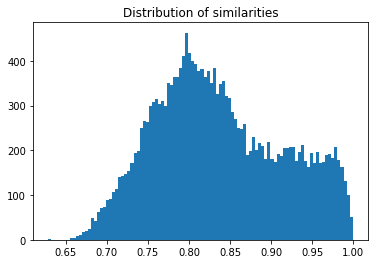

View  https://bbp.epfl.ch/neurosciencegraph/data/views/es/axon-coprojection-embeddings-view


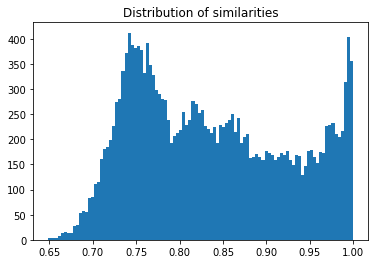

View  https://bbp.epfl.ch/neurosciencegraph/data/views/es/neurite-features-view


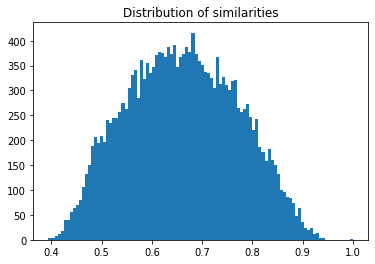

In [16]:
for view in views:
    print("View ", view)
    plt.hist(
        global_stats[view],
        bins=100)
    plt.title("Distribution of similarities")
    plt.show()

# Compute and register boosting factors for different points

In [17]:
deviations = {}
for view in views:
    forge._store.service.elastic_endpoint["endpoint"] = "/".join(
        (VIEWS_ENDPOINT, quote_plus(view), "_search"))
    deviations[view] = {}
    for point_id, vector in vectors[view].items():
        deviations[view][point_id] = get_score_deviation(
            forge, point_id, vector, 10, formulas[views[view]], vector_parameter)

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.2750468850135803, 0.14818274974822998, 0.06831693649291992, 0.598427414894104, 0.162514328956604, 0.19577312469482422, 0.0868537425994873, 0.16378793120384216, 0.9164875745773315, 0.19358235597610474, 0.2401268482208252, 0.23491746187210083, 0.16962909698486328, 0.19945815205574036, 0.5195261836051941, 0.2548169195652008, 0.6913046836853027, 0.19271984696388245, 0.14522597193717957, 0.5650156736373901, 0.6374410390853882, 0.14141881465911865, 0.19393229484558105, 0.5824999809265137, 0.10406288504600525, 0.549197256565094, 0.15894845128059387, 0.11506828665733337, 0.26028740406036377, 0.2202131152153015, 0.22089266777038574, 0.2974407076

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.6094064116477966, 0.34069931507110596, 0.16936123371124268, 0.5498201847076416, 0.29535073041915894, 0.27596160769462585, 0.19632181525230408, 0.4398912787437439, 0.8232913017272949, 0.6386836171150208, 0.376957505941391, 0.904072642326355, 0.2017117440700531, 0.722170889377594, 0.8213422298431396, 0.08110126852989197, 0.20428559184074402, 0.39746323227882385, 0.4386862516403198, 0.3791489601135254, 0.6938605308532715, 0.5361448526382446, 0.23475965857505798, 0.5450558066368103, 0.19431492686271667, 0.6129918694496155, 0.29037755727767944, 0.8040273189544678, 0.8318403959274292, 0.5175443887710571, 0.4676554501056671, 0.3519798517227173

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.1297401487827301, 0.010911792516708374, 0.012248754501342773, 0.12720343470573425, 0.040108442306518555, 0.5753570795059204, 0.02012956142425537, 0.012802809476852417, 0.15000924468040466, 0.03063875436782837, 0.056062012910842896, 0.08188122510910034, 0.07318389415740967, 0.019051313400268555, 0.09986433386802673, 0.2411802113056183, 0.062298715114593506, 0.7468481063842773, 0.38872474431991577, 0.4367138147354126, 0.8532494306564331, 0.7279098629951477, 0.4026334285736084, 0.8358482122421265, 0.07737457752227783, 0.31141263246536255, 0.025321930646896362, 0.085053950548172, 0.09369632601737976, 0.08131226897239685, 0.06211861968040466

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.6547027230262756, 0.06595590710639954, 0.07044872641563416, 0.5686904191970825, 0.042797356843948364, 0.09032696485519409, 0.07021716237068176, 0.09729248285293579, 0.8971413373947144, 0.41061729192733765, 0.5815889239311218, 0.80390465259552, 0.4515441656112671, 0.7113866209983826, 0.9009514451026917, 0.47835806012153625, 0.44407254457473755, 0.03625008463859558, 0.18729794025421143, 0.19907045364379883, 0.9529123306274414, 0.14948013424873352, 0.4750767946243286, 0.339275062084198, 0.2717384099960327, 0.9338699579238892, 0.13239005208015442, 0.9116103649139404, 0.9127775430679321, 0.7790910005569458, 0.15570399165153503, 0.16706016659

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.4782106578350067, 0.144546777009964, 0.2477690577507019, 0.8263369798660278, 0.38820725679397583, 0.25466078519821167, 0.22424480319023132, 0.195593923330307, 0.8894667625427246, 0.21010011434555054, 0.7094746828079224, 0.6082744002342224, 0.29989856481552124, 0.33828631043434143, 0.6715462803840637, 0.48191219568252563, 0.8633972406387329, 0.42846912145614624, 0.5095348954200745, 0.3790389895439148, 0.5469162464141846, 0.38011428713798523, 0.22848328948020935, 0.336456835269928, 0.24148887395858765, 0.733242392539978, 0.24964573979377747, 0.2666882872581482, 0.6166510581970215, 0.2894173860549927, 0.31132692098617554, 0.833945393562316

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.7150715589523315, 0.19836971163749695, 0.5758973360061646, 0.030902624130249023, 0.030716627836227417, 0.9896168112754822, 0.6715593934059143, 0.4301912188529968, 0.12407052516937256, 0.06341397762298584, 0.11493366956710815, 0.09485700726509094, 0.06899303197860718, 0.006991714239120483, 0.04113468527793884, 0.0591871440410614, 0.067486971616745, 0.9824221730232239, 0.964160144329071, 0.2952008545398712, 0.8689600229263306, 0.9881083965301514, 0.9910043478012085, 0.9850239753723145, 0.1207684874534607, 0.15806549787521362, 0.27229300141334534, 0.9800738096237183, 0.08340522646903992, 0.12117022275924683, 0.12336453795433044, 0.29454100

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.9824547171592712, 0.47759774327278137, 0.331589937210083, 0.010857641696929932, 0.020023256540298462, 0.9949178695678711, 0.7590262293815613, 0.9121739268302917, 0.04014727473258972, 0.05576935410499573, 0.07985752820968628, 0.5466053485870361, 0.13941779732704163, 0.006525874137878418, 0.007620304822921753, 0.05879738926887512, 0.005071878433227539, 0.9746497869491577, 0.8828063011169434, 0.6255820393562317, 0.7714686989784241, 0.9694592356681824, 0.9936262369155884, 0.9799132347106934, 0.11230722069740295, 0.3476261496543884, 0.6899888515472412, 0.9754058122634888, 0.052078455686569214, 0.31246286630630493, 0.17493239045143127, 0.1702

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.4764817953109741, 0.0772869884967804, 0.08136606216430664, 0.8062620162963867, 0.2616470158100128, 0.11621776223182678, 0.15340745449066162, 0.06968152523040771, 0.694288969039917, 0.6404715180397034, 0.738389253616333, 0.945734977722168, 0.18923139572143555, 0.9461863040924072, 0.9493083357810974, 0.12949639558792114, 0.35010826587677, 0.039329469203948975, 0.3508153557777405, 0.14271241426467896, 0.839195966720581, 0.20070043206214905, 0.24185946583747864, 0.5615511536598206, 0.3149332106113434, 0.8873962759971619, 0.17760911583900452, 0.912354588508606, 0.9865532517433167, 0.7480688691139221, 0.30355438590049744, 0.18980267643928528,

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.22466203570365906, 0.33554282784461975, 0.023654043674468994, 0.3689340353012085, 0.20827847719192505, 0.2218935191631317, 0.06552428007125854, 0.035241514444351196, 0.7223063707351685, 0.11067810654640198, 0.053528010845184326, 0.2754833698272705, 0.1141522228717804, 0.07602524757385254, 0.4539535343647003, 0.1618158221244812, 0.7718005776405334, 0.40481939911842346, 0.06530067324638367, 0.4327658414840698, 0.5605979561805725, 0.12094956636428833, 0.045078396797180176, 0.1659316122531891, 0.145900160074234, 0.23195978999137878, 0.040438294410705566, 0.03001844882965088, 0.3226650357246399, 0.04446074366569519, 0.42266374826431274, 0.10

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.3573257029056549, 0.11500325798988342, 0.10902783274650574, 0.5361504554748535, 0.04829755425453186, 0.28199487924575806, 0.11549672484397888, 0.1338409185409546, 0.2654000520706177, 0.15989196300506592, 0.06711593270301819, 0.17141246795654297, 0.14225435256958008, 0.02388179302215576, 0.835776686668396, 0.40398260951042175, 0.006025791168212891, 0.07070267200469971, 0.1023811399936676, 0.8994709253311157, 0.16489571332931519, 0.4033028185367584, 0.04460224509239197, 0.06614258885383606, 0.12265154719352722, 0.37423694133758545, 0.1635250747203827, 0.05295455455780029, 0.050454288721084595, 0.15432363748550415, 0.18618836998939514, 0.1

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.6799424290657043, 0.127945214509964, 0.19371268153190613, 0.7510030269622803, 0.17646601796150208, 0.14519032835960388, 0.17150408029556274, 0.23286718130111694, 0.8244246244430542, 0.7655884027481079, 0.7325625419616699, 0.9496860504150391, 0.29232126474380493, 0.9765670299530029, 0.9566768407821655, 0.22525247931480408, 0.36861705780029297, 0.022083252668380737, 0.21590515971183777, 0.1672077178955078, 0.9479819536209106, 0.3198685050010681, 0.5794119834899902, 0.6745728254318237, 0.6052713394165039, 0.9543106555938721, 0.17037490010261536, 0.9689159393310547, 0.9927766919136047, 0.8390308022499084, 0.3361552953720093, 0.3041694760322

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.7097139358520508, 0.0918530821800232, 0.6509609818458557, 0.044873446226119995, 0.10523122549057007, 0.9851674437522888, 0.696831464767456, 0.14472165703773499, 0.18578457832336426, 0.04390564560890198, 0.08670929074287415, 0.15611624717712402, 0.03563466668128967, 0.012072563171386719, 0.06325766444206238, 0.05350932478904724, 0.15584060549736023, 0.9827030897140503, 0.9427273273468018, 0.2748299241065979, 0.8922970294952393, 0.9839571714401245, 0.9453173279762268, 0.9676997065544128, 0.182649165391922, 0.22946855425834656, 0.19324389100074768, 0.927606463432312, 0.12904682755470276, 0.05112147331237793, 0.1357896327972412, 0.399037122

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.8996376991271973, 0.32509303092956543, 0.8370696306228638, 0.022132843732833862, 0.026107698678970337, 0.971517026424408, 0.9614092111587524, 0.9013382196426392, 0.11616012454032898, 0.04702925682067871, 0.2718485891819, 0.35668885707855225, 0.18955940008163452, 0.010162293910980225, 0.046991586685180664, 0.04224038124084473, 0.05311855673789978, 0.9879912734031677, 0.9898138642311096, 0.06807059049606323, 0.889011561870575, 0.9853332042694092, 0.9912889003753662, 0.9802114963531494, 0.19412332773208618, 0.5389180183410645, 0.8388350009918213, 0.9783638715744019, 0.05348268151283264, 0.3620400130748749, 0.1751960813999176, 0.18370240926

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.44694358110427856, 0.26619112491607666, 0.7591110467910767, 0.023460805416107178, 0.07568803429603577, 0.9700338840484619, 0.8308786749839783, 0.44417449831962585, 0.11522740125656128, 0.04585421085357666, 0.27565518021583557, 0.07369130849838257, 0.112769216299057, 0.024058938026428223, 0.15313926339149475, 0.04162764549255371, 0.297038733959198, 0.9937950968742371, 0.9431127309799194, 0.1329156756401062, 0.847193717956543, 0.9774125218391418, 0.9949594736099243, 0.9916034936904907, 0.2056865096092224, 0.2303001880645752, 0.1867094337940216, 0.985666036605835, 0.06680130958557129, 0.23303091526031494, 0.12636536359786987, 0.24690517783

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.9981682300567627, 0.9997960329055786, 0.9997433423995972, 0.998432993888855, 0.9995076060295105, 0.6844539642333984, 0.9999567270278931, 0.9999633431434631, 0.03500989079475403, 0.9997705221176147, 0.9948849678039551, 0.022886067628860474, 0.9999743700027466, 0.9989659786224365, 0.03580272197723389, 0.9994814395904541, 0.027516543865203857, 0.016477853059768677, 0.9998069405555725, 0.9979153275489807, 0.060371965169906616, 0.02019640803337097, 0.11685872077941895, 0.0462116003036499, 0.9999744892120361, 0.04938620328903198, 0.9999661445617676, 0.9986227750778198, 0.9965972900390625, 0.9996964931488037, 0.9999018311500549, 0.992776334285

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.9050390720367432, 0.1782388985157013, 0.6922739744186401, 0.05581390857696533, 0.012974977493286133, 0.9839836359024048, 0.8443983197212219, 0.73826003074646, 0.06920179724693298, 0.017767667770385742, 0.5072436928749084, 0.14452752470970154, 0.07841131091117859, 0.011199951171875, 0.14559176564216614, 0.06768357753753662, 0.08057743310928345, 0.9641227722167969, 0.9701652526855469, 0.1309944987297058, 0.4582982659339905, 0.9865928888320923, 0.968639612197876, 0.9587522745132446, 0.12631016969680786, 0.14944958686828613, 0.6868188381195068, 0.9543150067329407, 0.04589548707008362, 0.1754644513130188, 0.06011343002319336, 0.3417508006095

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.9970313310623169, 0.9988338947296143, 0.9981138706207275, 0.9926732778549194, 0.9981244206428528, 0.9407327175140381, 0.9993982315063477, 0.9996179342269897, 0.06247130036354065, 0.9974108934402466, 0.9925520420074463, 0.05186167359352112, 0.9998511075973511, 0.997564971446991, 0.03873556852340698, 0.9991384744644165, 0.0910063087940216, 0.0407070517539978, 0.9975751638412476, 0.9691498279571533, 0.11630222201347351, 0.028983861207962036, 0.21221420168876648, 0.042448997497558594, 0.9999001622200012, 0.16605618596076965, 0.9993808269500732, 0.9949063658714294, 0.9983514547348022, 0.9991299510002136, 0.999484121799469, 0.9920055866241455

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.7532014846801758, 0.16597113013267517, 0.3478970527648926, 0.6299112439155579, 0.12982019782066345, 0.930404543876648, 0.6124420762062073, 0.13194724917411804, 0.08906334638595581, 0.06215795874595642, 0.6715790629386902, 0.9216263890266418, 0.17436182498931885, 0.17125311493873596, 0.9996994733810425, 0.1880221962928772, 0.0064591169357299805, 0.020447850227355957, 0.9576011896133423, 0.9899384379386902, 0.004239767789840698, 0.9879147410392761, 0.0025861263275146484, 0.002227693796157837, 0.16721570491790771, 0.13293933868408203, 0.9232184886932373, 0.010673820972442627, 0.14452770352363586, 0.05755728483200073, 0.32114386558532715, 0

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.13644513487815857, 0.9998123645782471, 0.9975457191467285, 0.998769998550415, 0.9995936155319214, 0.061756908893585205, 0.9991592168807983, 0.9997832775115967, 0.06485050916671753, 0.9997996091842651, 0.8773137331008911, 0.08929106593132019, 0.9999046325683594, 0.9973957538604736, 0.7244784235954285, 0.99971604347229, 0.9665852785110474, 0.03781360387802124, 0.955025315284729, 0.9973171949386597, 0.031324535608291626, 0.06477612257003784, 0.033372342586517334, 0.035846590995788574, 0.9999252557754517, 0.11720851063728333, 0.9996531009674072, 0.8011094331741333, 0.4431707262992859, 0.9971597790718079, 0.999943733215332, 0.110569506883621

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.859122633934021, 0.13891547918319702, 0.8219342231750488, 0.11953610181808472, 0.04477158188819885, 0.8858634829521179, 0.6968845129013062, 0.12452226877212524, 0.04049539566040039, 0.04794275760650635, 0.6405758857727051, 0.6550782322883606, 0.05163457989692688, 0.05012938380241394, 0.9675113558769226, 0.08730423450469971, 0.06077966094017029, 0.1433001160621643, 0.8143894076347351, 0.6064927577972412, 0.10886186361312866, 0.9513230323791504, 0.09794202446937561, 0.07513004541397095, 0.11571863293647766, 0.1670025885105133, 0.8848192095756531, 0.10238775610923767, 0.05830523371696472, 0.15993839502334595, 0.13130009174346924, 0.4354360

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.9566919803619385, 0.9990880489349365, 0.9889866709709167, 0.9995583295822144, 0.9991565942764282, 0.4802325367927551, 0.998603880405426, 0.9984839558601379, 0.19315919280052185, 0.9998412132263184, 0.990291953086853, 0.1867615282535553, 0.9998957514762878, 0.9951558113098145, 0.04196453094482422, 0.9987627267837524, 0.09503248333930969, 0.018015116453170776, 0.9839943647384644, 0.9897211790084839, 0.07497203350067139, 0.03357088565826416, 0.7812844514846802, 0.07457044720649719, 0.9996715784072876, 0.31160402297973633, 0.9982407093048096, 0.9914340972900391, 0.9865071773529053, 0.9991500973701477, 0.9977041482925415, 0.9422664046287537,

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.8813353776931763, 0.5850529074668884, 0.06324884295463562, 0.039698123931884766, 0.0819874107837677, 0.6428729295730591, 0.1508353054523468, 0.45260611176490784, 0.5567284822463989, 0.15879809856414795, 0.4186098575592041, 0.842729926109314, 0.9466496109962463, 0.572987973690033, 0.20455259084701538, 0.8865596055984497, 0.4079315662384033, 0.6024178862571716, 0.3306397795677185, 0.37345388531684875, 0.9054322838783264, 0.5628193616867065, 0.9580819606781006, 0.7647805213928223, 0.8866463899612427, 0.9160115718841553, 0.10577651858329773, 0.9941072463989258, 0.616422712802887, 0.9303157329559326, 0.43178701400756836, 0.7484352588653564, 

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.5461868047714233, 0.19982150197029114, 0.27314627170562744, 0.656240701675415, 0.1036214828491211, 0.15731433033943176, 0.1935429573059082, 0.3194909691810608, 0.1650039553642273, 0.5843083262443542, 0.7662311792373657, 0.8890846967697144, 0.9725075960159302, 0.6180385947227478, 0.6901674866676331, 0.9720677137374878, 0.42382189631462097, 0.38525643944740295, 0.18733984231948853, 0.13670700788497925, 0.9176170825958252, 0.27807939052581787, 0.945171594619751, 0.4072563052177429, 0.5042555332183838, 0.8593500852584839, 0.17019611597061157, 0.9696897864341736, 0.6919956207275391, 0.9960423707962036, 0.1460379660129547, 0.07346045970916748

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.1109069287776947, 0.9996954798698425, 0.9999154806137085, 0.995802640914917, 0.9991692304611206, 0.09804341197013855, 0.9999068975448608, 0.9996290802955627, 0.07211816310882568, 0.9996379613876343, 0.8415597677230835, 0.014520078897476196, 0.9997726082801819, 0.9873757362365723, 0.06840547919273376, 0.9998879432678223, 0.9732553958892822, 0.04161489009857178, 0.90199214220047, 0.9982773065567017, 0.04541769623756409, 0.03191983699798584, 0.09390929341316223, 0.0628686249256134, 0.9996687173843384, 0.028150469064712524, 0.9997124671936035, 0.5795650482177734, 0.09158375859260559, 0.9952113628387451, 0.9990795850753784, 0.058646768331527

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.5638576745986938, 0.12015983462333679, 0.09506893157958984, 0.2670353949069977, 0.15017607808113098, 0.05437418818473816, 0.04698994755744934, 0.09299924969673157, 0.9870918989181519, 0.5137485265731812, 0.7435229420661926, 0.9819226264953613, 0.35905173420906067, 0.9775659441947937, 0.9501703381538391, 0.3745344877243042, 0.7657027244567871, 0.01776215434074402, 0.040275245904922485, 0.115345299243927, 0.8928919434547424, 0.14372920989990234, 0.5618674755096436, 0.1645565927028656, 0.1921369731426239, 0.9924145340919495, 0.06876370310783386, 0.7529726028442383, 0.9738764762878418, 0.38936471939086914, 0.16588151454925537, 0.91725671291

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.023541122674942017, 0.9996575117111206, 0.9954788088798523, 0.9933987855911255, 0.9993525743484497, 0.01741001009941101, 0.998772144317627, 0.9995955228805542, 0.10023334622383118, 0.9996917843818665, 0.7133716940879822, 0.05660223960876465, 0.9998533725738525, 0.9949742555618286, 0.8725878000259399, 0.9997156858444214, 0.9827100038528442, 0.005708068609237671, 0.8966513872146606, 0.9989032745361328, 0.038644492626190186, 0.0957682728767395, 0.045404255390167236, 0.060833871364593506, 0.9998936653137207, 0.11848300695419312, 0.9990639686584473, 0.8598161935806274, 0.22779932618141174, 0.9994215965270996, 0.9999117851257324, 0.0171363651

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.421467125415802, 0.15902253985404968, 0.16489341855049133, 0.7813011407852173, 0.6396890878677368, 0.1792452037334442, 0.17882177233695984, 0.17840322852134705, 0.9273062944412231, 0.3938187062740326, 0.8170254230499268, 0.6301394104957581, 0.35205942392349243, 0.649487316608429, 0.5965636968612671, 0.23792189359664917, 0.9171555638313293, 0.6365845799446106, 0.36775583028793335, 0.2852476239204407, 0.4723529517650604, 0.2848926782608032, 0.19689276814460754, 0.5103252530097961, 0.1929563581943512, 0.828342080116272, 0.3267422914505005, 0.12453338503837585, 0.5546662211418152, 0.13069084286689758, 0.18263006210327148, 0.9401059150695801

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.08032751083374023, 0.6641974449157715, 0.5609539747238159, 0.23207053542137146, 0.9553285837173462, 0.12513038516044617, 0.15566647052764893, 0.37753230333328247, 0.6260651350021362, 0.7605876922607422, 0.838445782661438, 0.9694250822067261, 0.31738442182540894, 0.8441468477249146, 0.3297656178474426, 0.8398398160934448, 0.9336626529693604, 0.91829913854599, 0.10013610124588013, 0.3521501421928406, 0.09216070175170898, 0.16640111804008484, 0.6895114183425903, 0.23754537105560303, 0.13332054018974304, 0.24897539615631104, 0.2835642993450165, 0.027180910110473633, 0.21635377407073975, 0.41757479310035706, 0.14272624254226685, 0.7548474073

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.22607284784317017, 0.0773501992225647, 0.1112336814403534, 0.7670829892158508, 0.4196957051753998, 0.07807645201683044, 0.06515645980834961, 0.06702834367752075, 0.9292411804199219, 0.4317939877510071, 0.8941068649291992, 0.7848212718963623, 0.19619819521903992, 0.7325617671012878, 0.531417965888977, 0.3057132363319397, 0.8684784173965454, 0.215193510055542, 0.17688757181167603, 0.12247785925865173, 0.8260102272033691, 0.13936534523963928, 0.23480436205863953, 0.23529696464538574, 0.1635316014289856, 0.8932894468307495, 0.0505814254283905, 0.38047486543655396, 0.8857073783874512, 0.2383803129196167, 0.15269726514816284, 0.89054739475250

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.6751054525375366, 0.5045754909515381, 0.013663619756698608, 0.08387240767478943, 0.14981481432914734, 0.7540531158447266, 0.03493928909301758, 0.4113946855068207, 0.17756745219230652, 0.09116265177726746, 0.057513266801834106, 0.6211637258529663, 0.08101010322570801, 0.09802526235580444, 0.04744976758956909, 0.06479930877685547, 0.12736830115318298, 0.8071187138557434, 0.10340747237205505, 0.9236787557601929, 0.14504581689834595, 0.18064206838607788, 0.36217576265335083, 0.9189803600311279, 0.09176263213157654, 0.22715052962303162, 0.43993425369262695, 0.08207285404205322, 0.1453205645084381, 0.06681293249130249, 0.22456470131874084, 0.

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.302618145942688, 0.08943000435829163, 0.35144728422164917, 0.482109397649765, 0.3023300766944885, 0.13863834738731384, 0.1345825493335724, 0.12728631496429443, 0.6733402609825134, 0.6487264633178711, 0.9343518018722534, 0.9143589735031128, 0.42985299229621887, 0.8335692882537842, 0.6124308109283447, 0.8737785816192627, 0.4179956912994385, 0.1770487129688263, 0.3089325428009033, 0.12442371249198914, 0.8921127915382385, 0.273959755897522, 0.68735271692276, 0.6096773743629456, 0.17788922786712646, 0.8579757213592529, 0.1812559962272644, 0.6349077820777893, 0.868085503578186, 0.8976269960403442, 0.06496170163154602, 0.15891119837760925, 0.1

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.4650164842605591, 0.3768463134765625, 0.37283700704574585, 0.45536208152770996, 0.644412636756897, 0.28778308629989624, 0.24016770720481873, 0.13445138931274414, 0.7684723138809204, 0.8676707148551941, 0.7602157592773438, 0.959713339805603, 0.2794620990753174, 0.8038362264633179, 0.8248957395553589, 0.5552587509155273, 0.5845689177513123, 0.4633435904979706, 0.2013932168483734, 0.3901515305042267, 0.6945736408233643, 0.341513991355896, 0.6526771783828735, 0.7023518681526184, 0.18309608101844788, 0.7242097854614258, 0.23587018251419067, 0.4515215754508972, 0.558078408241272, 0.6954740285873413, 0.18252763152122498, 0.19438761472702026, 0

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.17230737209320068, 0.09465262293815613, 0.06783419847488403, 0.5732728242874146, 0.2038457989692688, 0.229253351688385, 0.05385604500770569, 0.008767455816268921, 0.526638388633728, 0.2201528549194336, 0.6831694841384888, 0.923073410987854, 0.31492698192596436, 0.8271864056587219, 0.5874026417732239, 0.5669081211090088, 0.6995145082473755, 0.22626757621765137, 0.07738935947418213, 0.27130573987960815, 0.7224082350730896, 0.45728981494903564, 0.3398144841194153, 0.20749586820602417, 0.1846388876438141, 0.6835033297538757, 0.005276024341583252, 0.6617433428764343, 0.653796374797821, 0.4460050165653229, 0.21577394008636475, 0.6841585636138

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.26318687200546265, 0.25051990151405334, 0.24086585640907288, 0.4625844359397888, 0.5444755554199219, 0.26480066776275635, 0.1867772340774536, 0.2473979890346527, 0.7511457204818726, 0.6250569820404053, 0.7800806164741516, 0.853169322013855, 0.30928367376327515, 0.7246052026748657, 0.8225279450416565, 0.6020550727844238, 0.7131462097167969, 0.442379891872406, 0.305736780166626, 0.2847449481487274, 0.7375750541687012, 0.5402939319610596, 0.45410048961639404, 0.5495893955230713, 0.2535003125667572, 0.7719685435295105, 0.19690653681755066, 0.48817282915115356, 0.7324820756912231, 0.7378091812133789, 0.3588036894798279, 0.3520491123199463, 0

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.24877092242240906, 0.8299318552017212, 0.04428824782371521, 0.3595113754272461, 0.3423612713813782, 0.5040221214294434, 0.06711262464523315, 0.2125452756881714, 0.9149059057235718, 0.19544684886932373, 0.1282249391078949, 0.4640512466430664, 0.25062114000320435, 0.14323732256889343, 0.2910395562648773, 0.15010851621627808, 0.9196130633354187, 0.7666081786155701, 0.08364507555961609, 0.16815170645713806, 0.5911102294921875, 0.3101368248462677, 0.19892483949661255, 0.1288297176361084, 0.13422980904579163, 0.6708099842071533, 0.08247441053390503, 0.07334473729133606, 0.18142718076705933, 0.1444913148880005, 0.767822265625, 0.72122025489807

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.6061567664146423, 0.10855260491371155, 0.2441628873348236, 0.6721042990684509, 0.21314024925231934, 0.13976934552192688, 0.17890992760658264, 0.19308558106422424, 0.8994607329368591, 0.8113641738891602, 0.8262550830841064, 0.9492529630661011, 0.2752779722213745, 0.9787874817848206, 0.9445627927780151, 0.30601173639297485, 0.5158194303512573, 0.01959344744682312, 0.17356526851654053, 0.2086867392063141, 0.9566715955734253, 0.24070370197296143, 0.6348927021026611, 0.6759099960327148, 0.5152924656867981, 0.9713404774665833, 0.1706964671611786, 0.9675973653793335, 0.9946999549865723, 0.8580464720726013, 0.32301896810531616, 0.27884063124656

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.5084070563316345, 0.2885063886642456, 0.20963841676712036, 0.17360296845436096, 0.18634548783302307, 0.07714784145355225, 0.09165045619010925, 0.13818955421447754, 0.6435772180557251, 0.80464768409729, 0.6935725212097168, 0.9456318020820618, 0.4124835133552551, 0.6868801116943359, 0.7496069669723511, 0.6773010492324829, 0.17917075753211975, 0.1375657021999359, 0.13253456354141235, 0.14106619358062744, 0.9157439470291138, 0.20577707886695862, 0.7319784164428711, 0.5790705680847168, 0.15099316835403442, 0.7004477977752686, 0.09620213508605957, 0.8587217330932617, 0.6715684533119202, 0.8946506977081299, 0.14212170243263245, 0.0445757806301

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.16989517211914062, 0.39432644844055176, 0.5369915962219238, 0.37297284603118896, 0.3163832426071167, 0.797866940498352, 0.8995506763458252, 0.09635183215141296, 0.4657245874404907, 0.23778977990150452, 0.5201852321624756, 0.24069815874099731, 0.4909244775772095, 0.06618478894233704, 0.3953278660774231, 0.8169033527374268, 0.6868805289268494, 0.542353630065918, 0.1500159204006195, 0.758521318435669, 0.5586531758308411, 0.06339028477668762, 0.3833934962749481, 0.14377665519714355, 0.2995648980140686, 0.5756834149360657, 0.7669616937637329, 0.11317816376686096, 0.18571850657463074, 0.8122601509094238, 0.7088369131088257, 0.0950975716114044

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.5078141689300537, 0.12840020656585693, 0.2102876901626587, 0.5062739253044128, 0.09814560413360596, 0.3147162199020386, 0.9124308824539185, 0.14186358451843262, 0.2781062424182892, 0.16103097796440125, 0.19760340452194214, 0.680205225944519, 0.1399616301059723, 0.15310829877853394, 0.2529556453227997, 0.722756564617157, 0.39353710412979126, 0.4625341594219208, 0.08678555488586426, 0.4726608097553253, 0.8774107098579407, 0.09766119718551636, 0.8551232814788818, 0.05093640089035034, 0.1178569495677948, 0.16110125184059143, 0.16854646801948547, 0.26525959372520447, 0.23089030385017395, 0.8655165433883667, 0.48769840598106384, 0.12009769678

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.0923631489276886, 0.5723792314529419, 0.970693826675415, 0.10997065901756287, 0.8833437561988831, 0.12080171704292297, 0.16310808062553406, 0.9855401515960693, 0.2976009249687195, 0.9816807508468628, 0.8677201271057129, 0.1585242748260498, 0.9851412773132324, 0.9607572555541992, 0.1338454782962799, 0.11202183365821838, 0.165512353181839, 0.07721129059791565, 0.9583274126052856, 0.16634121537208557, 0.11403757333755493, 0.9630998373031616, 0.0796934962272644, 0.9843969345092773, 0.7574241161346436, 0.9622663259506226, 0.07303324341773987, 0.0633130669593811, 0.9438701272010803, 0.11066102981567383, 0.13510537147521973, 0.9613692164421082

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.9875325560569763, 0.05438259243965149, 0.04395705461502075, 0.9701431393623352, 0.9118546843528748, 0.08431008458137512, 0.6027913093566895, 0.97626793384552, 0.12474897503852844, 0.07724207639694214, 0.38835597038269043, 0.9943698644638062, 0.04866775870323181, 0.9890243411064148, 0.7900282740592957, 0.03855699300765991, 0.969562292098999, 0.9761181473731995, 0.04053175449371338, 0.015288233757019043, 0.9706108570098877, 0.9829153418540955, 0.9474593997001648, 0.8201873302459717, 0.6796449422836304, 0.06773126125335693, 0.04511547088623047, 0.9872697591781616, 0.8760766983032227, 0.9436682462692261, 0.0854460597038269, 0.99531531333923

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.8865207433700562, 0.20479440689086914, 0.08089831471443176, 0.8252036571502686, 0.3171316981315613, 0.43934914469718933, 0.7501281499862671, 0.09768939018249512, 0.3619885742664337, 0.12773749232292175, 0.6993482112884521, 0.7064298391342163, 0.04308018088340759, 0.14896196126937866, 0.9018259048461914, 0.23090752959251404, 0.3857384920120239, 0.8049091100692749, 0.14246881008148193, 0.2887474298477173, 0.7716474533081055, 0.04376634955406189, 0.6847535371780396, 0.07801857590675354, 0.4832531213760376, 0.05756711959838867, 0.5097668170928955, 0.9484356641769409, 0.04934081435203552, 0.7520674467086792, 0.19675752520561218, 0.1147495508

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.22780627012252808, 0.3614117205142975, 0.29896992444992065, 0.394414484500885, 0.21402665972709656, 0.6988710761070251, 0.8463114500045776, 0.0953209400177002, 0.48966237902641296, 0.10725894570350647, 0.3010704517364502, 0.24967411160469055, 0.5458795428276062, 0.1008211076259613, 0.42801085114479065, 0.7535771727561951, 0.5876858234405518, 0.6288789510726929, 0.10360106825828552, 0.6577667593955994, 0.45201900601387024, 0.07765918970108032, 0.36433908343315125, 0.13066545128822327, 0.3154735565185547, 0.5193151831626892, 0.7138510942459106, 0.15942761301994324, 0.2127802073955536, 0.7285149097442627, 0.6443518400192261, 0.123266369104

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.12385421991348267, 0.5720912218093872, 0.9084393382072449, 0.17631122469902039, 0.095767080783844, 0.4808948338031769, 0.9578381776809692, 0.16867685317993164, 0.7340260744094849, 0.5508661270141602, 0.18470659852027893, 0.18417376279830933, 0.7556823492050171, 0.05395248532295227, 0.15336638689041138, 0.9498294591903687, 0.6081652641296387, 0.29800933599472046, 0.30858927965164185, 0.5494714379310608, 0.23596256971359253, 0.17447561025619507, 0.5811945199966431, 0.12818250060081482, 0.5371068716049194, 0.9156894683837891, 0.47783246636390686, 0.06770920753479004, 0.15657827258110046, 0.8376361131668091, 0.8410415053367615, 0.1008273363

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.35283467173576355, 0.5418038964271545, 0.6683694124221802, 0.217807799577713, 0.1788821816444397, 0.5892109274864197, 0.8868458867073059, 0.10612273216247559, 0.47786107659339905, 0.2015463411808014, 0.4294765591621399, 0.3918011784553528, 0.4700542986392975, 0.057313740253448486, 0.5060743093490601, 0.7526575326919556, 0.45855575799942017, 0.458636999130249, 0.14731302857398987, 0.6201927661895752, 0.3689962923526764, 0.07046380639076233, 0.4359191954135895, 0.13334336876869202, 0.3231624364852905, 0.6572771072387695, 0.7212440967559814, 0.10977315902709961, 0.14193010330200195, 0.8820819854736328, 0.6763156056404114, 0.069037944078445

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.8662046194076538, 0.21074706315994263, 0.04744341969490051, 0.7489908337593079, 0.4529278576374054, 0.7290897369384766, 0.726265549659729, 0.0930333137512207, 0.1966676414012909, 0.1042909026145935, 0.7271783351898193, 0.8043332099914551, 0.019881099462509155, 0.1398293673992157, 0.9574616551399231, 0.44891834259033203, 0.17346897721290588, 0.7481000423431396, 0.23719501495361328, 0.6746737957000732, 0.8813133835792542, 0.023683637380599976, 0.7709958553314209, 0.051634401082992554, 0.20589235424995422, 0.030298352241516113, 0.7845099568367004, 0.9377753138542175, 0.09380009770393372, 0.7999672889709473, 0.5178402662277222, 0.0934232175

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.16165846586227417, 0.5821860432624817, 0.9526433944702148, 0.10242241621017456, 0.9448186159133911, 0.020040154457092285, 0.20383885502815247, 0.9994430541992188, 0.13493376970291138, 0.99821537733078, 0.6790294051170349, 0.349600613117218, 0.9949200749397278, 0.997248113155365, 0.05615341663360596, 0.019726425409317017, 0.6863453388214111, 0.07300522923469543, 0.955150842666626, 0.04542240500450134, 0.07717937231063843, 0.9984087944030762, 0.13440898060798645, 0.9930318593978882, 0.9613037705421448, 0.9879403114318848, 0.00965571403503418, 0.04084807634353638, 0.9935927391052246, 0.04474422335624695, 0.027409344911575317, 0.99798804521

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.25443676114082336, 0.6845861673355103, 0.25369954109191895, 0.6845242977142334, 0.0887753963470459, 0.9219031929969788, 0.3697548508644104, 0.13217037916183472, 0.7729383707046509, 0.07431751489639282, 0.056862711906433105, 0.1477648913860321, 0.9116683006286621, 0.11127641797065735, 0.28177860379219055, 0.3592914044857025, 0.8808912038803101, 0.8548932075500488, 0.3300814628601074, 0.8745371103286743, 0.30239301919937134, 0.051139265298843384, 0.2646152973175049, 0.22680634260177612, 0.35000911355018616, 0.8520580530166626, 0.8320671319961548, 0.20325103402137756, 0.06292527914047241, 0.8321447372436523, 0.9139456748962402, 0.048383027

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.7454789280891418, 0.6241308450698853, 0.1895468533039093, 0.6899557709693909, 0.6311789751052856, 0.9008272886276245, 0.7284611463546753, 0.2645714282989502, 0.42891132831573486, 0.3824406862258911, 0.7897228002548218, 0.5060968399047852, 0.0888020396232605, 0.18239623308181763, 0.8692771196365356, 0.7655981183052063, 0.1642627716064453, 0.37189170718193054, 0.712680459022522, 0.8631731271743774, 0.4790506660938263, 0.09021714329719543, 0.4533751904964447, 0.22574740648269653, 0.3617616295814514, 0.08482301235198975, 0.8884881734848022, 0.8187566995620728, 0.16712158918380737, 0.5159347653388977, 0.6958924531936646, 0.0922844409942627, 

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.8634465336799622, 0.09005093574523926, 0.07713678479194641, 0.08569192886352539, 0.19506320357322693, 0.037032097578048706, 0.08127149939537048, 0.950056254863739, 0.055120646953582764, 0.1566195785999298, 0.16363507509231567, 0.7439802885055542, 0.2733739912509918, 0.9565100073814392, 0.056960880756378174, 0.0371270477771759, 0.3455631136894226, 0.2013220191001892, 0.09376981854438782, 0.03149494528770447, 0.08888769149780273, 0.9810530543327332, 0.13154685497283936, 0.8737963438034058, 0.5330321788787842, 0.5394623279571533, 0.02965131402015686, 0.14954209327697754, 0.8928039073944092, 0.08903318643569946, 0.0513455867767334, 0.927833

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.9797149896621704, 0.07685133814811707, 0.08041411638259888, 0.9701088666915894, 0.8654520511627197, 0.07568886876106262, 0.4990070164203644, 0.9288008213043213, 0.18076464533805847, 0.199896901845932, 0.48523610830307007, 0.9887216091156006, 0.07258260250091553, 0.9618067741394043, 0.8128008842468262, 0.05840468406677246, 0.854767918586731, 0.9524786472320557, 0.06289076805114746, 0.0343591570854187, 0.9632949829101562, 0.980313241481781, 0.8024893999099731, 0.8168352842330933, 0.5877264738082886, 0.10475549101829529, 0.059958428144454956, 0.9706858992576599, 0.9355143904685974, 0.8896377086639404, 0.05972900986671448, 0.983144462108612

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.04644861817359924, 0.362775981426239, 0.9705376625061035, 0.14835244417190552, 0.9233469367027283, 0.06809791922569275, 0.1939031481742859, 0.9921116828918457, 0.22016224265098572, 0.9907358288764954, 0.8707852959632874, 0.17497316002845764, 0.9905102252960205, 0.9875069856643677, 0.06159639358520508, 0.035336703062057495, 0.19969409704208374, 0.09134739637374878, 0.9844875335693359, 0.07323229312896729, 0.08778256177902222, 0.9700779914855957, 0.13232427835464478, 0.9918367862701416, 0.9446052312850952, 0.9636498689651489, 0.02482852339744568, 0.10304620862007141, 0.9405019283294678, 0.06259077787399292, 0.037028968334198, 0.9891537427

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.9686304330825806, 0.06319156289100647, 0.05575147271156311, 0.9664238095283508, 0.6857744455337524, 0.068121999502182, 0.4115751385688782, 0.8359041810035706, 0.2942870259284973, 0.17439177632331848, 0.3259742856025696, 0.9889335632324219, 0.05433163046836853, 0.9176012873649597, 0.7932988405227661, 0.12484413385391235, 0.7931063175201416, 0.953234076499939, 0.048249125480651855, 0.03742906451225281, 0.979342520236969, 0.9493979215621948, 0.7691292762756348, 0.6409317255020142, 0.4978792071342468, 0.07081198692321777, 0.0837486982345581, 0.9587987661361694, 0.9263604879379272, 0.8558011054992676, 0.0982779860496521, 0.9688445925712585, 

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.9912031888961792, 0.05851107835769653, 0.14599019289016724, 0.9629316926002502, 0.5799808502197266, 0.06055977940559387, 0.8055989146232605, 0.9643378853797913, 0.14693433046340942, 0.13964694738388062, 0.21401721239089966, 0.9925022125244141, 0.03126096725463867, 0.9247322678565979, 0.7908713817596436, 0.07373693585395813, 0.8327161073684692, 0.9699442386627197, 0.025953859090805054, 0.01971706748008728, 0.9889304637908936, 0.9908588528633118, 0.9306087493896484, 0.6021347641944885, 0.20972517132759094, 0.12331703305244446, 0.05160778760910034, 0.9374686479568481, 0.971092939376831, 0.9313900470733643, 0.06692779064178467, 0.9793365597

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.9739837646484375, 0.10584402084350586, 0.07021582126617432, 0.9694242477416992, 0.8522653579711914, 0.09874129295349121, 0.45409712195396423, 0.8873549699783325, 0.24547579884529114, 0.1594523787498474, 0.3298932909965515, 0.9826298952102661, 0.05437368154525757, 0.9492511749267578, 0.8166778683662415, 0.09785887598991394, 0.8756940364837646, 0.960360050201416, 0.09310868382453918, 0.0547865629196167, 0.9501074552536011, 0.9687680006027222, 0.8243317604064941, 0.7805242538452148, 0.5123497247695923, 0.09017425775527954, 0.12080356478691101, 0.9856404066085815, 0.8742020130157471, 0.8948741555213928, 0.0831194519996643, 0.962092101573944

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.2280471920967102, 0.8852794170379639, 0.15788128972053528, 0.66789710521698, 0.7372757792472839, 0.946014404296875, 0.0737122893333435, 0.14019590616226196, 0.8557714223861694, 0.3656196594238281, 0.6280282735824585, 0.039707839488983154, 0.9063294529914856, 0.18075183033943176, 0.8194208741188049, 0.5235506296157837, 0.6582786440849304, 0.8137811422348022, 0.5228265523910522, 0.8949577212333679, 0.16389644145965576, 0.11896821856498718, 0.08891728520393372, 0.4953939616680145, 0.4747052788734436, 0.28385457396507263, 0.9655059576034546, 0.5994402766227722, 0.058127641677856445, 0.19078010320663452, 0.8443207144737244, 0.095174193382263

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.5364884734153748, 0.30297350883483887, 0.1727883517742157, 0.6748930811882019, 0.7005186676979065, 0.9027351140975952, 0.7083654403686523, 0.21768340468406677, 0.4956190288066864, 0.37497490644454956, 0.8129684329032898, 0.6590283513069153, 0.14016768336296082, 0.21591931581497192, 0.919247031211853, 0.8540698289871216, 0.29464882612228394, 0.4662455916404724, 0.43480661511421204, 0.9349236488342285, 0.8336653709411621, 0.05409786105155945, 0.5972366333007812, 0.1257329285144806, 0.4575393795967102, 0.11866533756256104, 0.782005250453949, 0.7751659154891968, 0.1655852496623993, 0.7870136499404907, 0.8542599678039551, 0.10971471667289734

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.5007162690162659, 0.5688188672065735, 0.19285744428634644, 0.3466411530971527, 0.8755078911781311, 0.943753182888031, 0.4402092397212982, 0.15484005212783813, 0.3979504704475403, 0.44820716977119446, 0.8636096715927124, 0.277584433555603, 0.1566036343574524, 0.20298245549201965, 0.9251362085342407, 0.7261048555374146, 0.15916302800178528, 0.39556437730789185, 0.43634772300720215, 0.9331361055374146, 0.6963526606559753, 0.035130083560943604, 0.35694342851638794, 0.1668766736984253, 0.32849568128585815, 0.053229838609695435, 0.9645234942436218, 0.7478808164596558, 0.13163864612579346, 0.38536977767944336, 0.6096269488334656, 0.14179781079

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.5866172313690186, 0.40208128094673157, 0.15212783217430115, 0.5541942715644836, 0.716224730014801, 0.9077168107032776, 0.613713264465332, 0.16885894536972046, 0.49113959074020386, 0.3507547080516815, 0.8500358462333679, 0.5152384042739868, 0.10061168670654297, 0.2625424265861511, 0.8613879084587097, 0.8027008771896362, 0.20719680190086365, 0.3831523656845093, 0.49465128779411316, 0.9109373092651367, 0.6912903189659119, 0.07574176788330078, 0.4304850697517395, 0.21932578086853027, 0.39901018142700195, 0.09326985478401184, 0.8884522914886475, 0.7139134407043457, 0.26940590143203735, 0.49379873275756836, 0.6735005974769592, 0.1518996953964

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.31244152784347534, 0.7638065814971924, 0.3542144298553467, 0.7748379707336426, 0.3312784433364868, 0.912810206413269, 0.2213250994682312, 0.11246675252914429, 0.9099968671798706, 0.20359262824058533, 0.44608134031295776, 0.09626585245132446, 0.857455849647522, 0.1158139705657959, 0.5783792734146118, 0.5492351055145264, 0.8684723377227783, 0.7505470514297485, 0.6915711164474487, 0.8569392561912537, 0.24336358904838562, 0.07164973020553589, 0.19056737422943115, 0.4116252064704895, 0.6959848999977112, 0.7541403770446777, 0.8624860048294067, 0.4933011829853058, 0.08056554198265076, 0.3515564799308777, 0.8413128852844238, 0.06822863221168518

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.6616625785827637, 0.7444987297058105, 0.2591354250907898, 0.4582393169403076, 0.8374000191688538, 0.9294183254241943, 0.4394168555736542, 0.2509620487689972, 0.6111741065979004, 0.6578280925750732, 0.8458869457244873, 0.3634299337863922, 0.044578880071640015, 0.276511549949646, 0.956089437007904, 0.8389695882797241, 0.06778281927108765, 0.27171942591667175, 0.7683697938919067, 0.8925114274024963, 0.46622663736343384, 0.05002519488334656, 0.5797262191772461, 0.11802855134010315, 0.3621981739997864, 0.02660641074180603, 0.9764881134033203, 0.9528246521949768, 0.09215357899665833, 0.39012593030929565, 0.7381464242935181, 0.0595966875553131

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.6134383678436279, 0.5134246945381165, 0.18584901094436646, 0.5231227278709412, 0.5417004823684692, 0.875307559967041, 0.8164260387420654, 0.10081368684768677, 0.236203134059906, 0.1766478419303894, 0.7524083852767944, 0.6496107578277588, 0.13177931308746338, 0.12925848364830017, 0.7496664524078369, 0.668270468711853, 0.35520803928375244, 0.6680488586425781, 0.26525574922561646, 0.8039318323135376, 0.7388173937797546, 0.05696430802345276, 0.40113887190818787, 0.11261218786239624, 0.2844565510749817, 0.1939188539981842, 0.925137996673584, 0.5661820769309998, 0.14910954236984253, 0.6426382660865784, 0.5482603907585144, 0.17299112677574158,

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.09470289945602417, 0.8542065620422363, 0.7607002854347229, 0.4966997802257538, 0.09237554669380188, 0.9409008026123047, 0.3691398501396179, 0.08437660336494446, 0.8911789655685425, 0.19607865810394287, 0.12229505181312561, 0.057529330253601074, 0.9601188898086548, 0.12961351871490479, 0.1170932948589325, 0.5367423295974731, 0.9543918371200562, 0.6592574119567871, 0.7068002223968506, 0.9251381158828735, 0.08217725157737732, 0.060595929622650146, 0.19017043709754944, 0.6043195128440857, 0.7770171165466309, 0.9663709402084351, 0.9135898351669312, 0.30279016494750977, 0.02644100785255432, 0.6764558553695679, 0.9602576494216919, 0.0327219963

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.5898492932319641, 0.5756306052207947, 0.019197583198547363, 0.545648455619812, 0.8565894961357117, 0.9702819585800171, 0.4638456106185913, 0.2687356472015381, 0.5302108526229858, 0.08041003346443176, 0.6268596649169922, 0.2964315116405487, 0.2699926793575287, 0.2632823586463928, 0.9000400900840759, 0.617846667766571, 0.2669113874435425, 0.7845261096954346, 0.1219947338104248, 0.9155139923095703, 0.6350979208946228, 0.05492475628852844, 0.3793264329433441, 0.058104485273361206, 0.2231351137161255, 0.08616268634796143, 0.9671556949615479, 0.6356767416000366, 0.12276628613471985, 0.6771337389945984, 0.5874229073524475, 0.07820156216621399,

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.18150532245635986, 0.6787761449813843, 0.5372591018676758, 0.7574144601821899, 0.1359759271144867, 0.9028931856155396, 0.5290108919143677, 0.06658884882926941, 0.8672672510147095, 0.12284055352210999, 0.1708601415157318, 0.10260972380638123, 0.9296810626983643, 0.03106549382209778, 0.37297967076301575, 0.7457529902458191, 0.8513678312301636, 0.7322196960449219, 0.3776441514492035, 0.8290735483169556, 0.26458820700645447, 0.04020148515701294, 0.12694326043128967, 0.22133922576904297, 0.46511054039001465, 0.8075240254402161, 0.820309579372406, 0.11124074459075928, 0.08783474564552307, 0.6282063722610474, 0.9337952733039856, 0.046188771724

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.3203740119934082, 0.5865798592567444, 0.687261164188385, 0.5601739287376404, 0.604590892791748, 0.8674556612968445, 0.9666687250137329, 0.10780805349349976, 0.37111395597457886, 0.629019558429718, 0.7452073693275452, 0.35881370306015015, 0.1511460840702057, 0.03995022177696228, 0.8583916425704956, 0.8245574831962585, 0.15128037333488464, 0.2521819472312927, 0.5182358622550964, 0.8753958940505981, 0.6246556043624878, 0.06857722997665405, 0.7120179533958435, 0.17738384008407593, 0.5933873653411865, 0.14911732077598572, 0.7034635543823242, 0.3505444824695587, 0.176449716091156, 0.889230489730835, 0.8659849166870117, 0.13618558645248413, 0.

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.24198570847511292, 0.35875436663627625, 0.43697676062583923, 0.30979955196380615, 0.473306804895401, 0.8865388035774231, 0.8492605686187744, 0.09991738200187683, 0.2939817011356354, 0.3912573456764221, 0.5495158433914185, 0.4003356695175171, 0.2225261926651001, 0.07980236411094666, 0.710385262966156, 0.9351062774658203, 0.2161669135093689, 0.25801825523376465, 0.28067144751548767, 0.9475950002670288, 0.6026690006256104, 0.02977725863456726, 0.2729812264442444, 0.12138321995735168, 0.25702911615371704, 0.25170862674713135, 0.9155241847038269, 0.2102106511592865, 0.1791473925113678, 0.7461913824081421, 0.8439494371414185, 0.06569275259971

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.21023598313331604, 0.3307386636734009, 0.49158138036727905, 0.3524606227874756, 0.4812503755092621, 0.7721240520477295, 0.8697761297225952, 0.13038206100463867, 0.43946847319602966, 0.4252692759037018, 0.5338292717933655, 0.4849805235862732, 0.2790956497192383, 0.0986180305480957, 0.7293654680252075, 0.9288115501403809, 0.22373399138450623, 0.2798241078853607, 0.24982044100761414, 0.9045196771621704, 0.6307759881019592, 0.06727984547615051, 0.41306471824645996, 0.17007789015769958, 0.3847135603427887, 0.3305899500846863, 0.8167730569839478, 0.24514815211296082, 0.3263493776321411, 0.6696884632110596, 0.8329894542694092, 0.13168945908546

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.9808189272880554, 0.059203892946243286, 0.0454157292842865, 0.9577153921127319, 0.7162529230117798, 0.061888277530670166, 0.3210722804069519, 0.9375259280204773, 0.14169225096702576, 0.2157975435256958, 0.7119773626327515, 0.9822355508804321, 0.06639006733894348, 0.9743931293487549, 0.8865320682525635, 0.03562763333320618, 0.8426445722579956, 0.9475681781768799, 0.07527700066566467, 0.018393635749816895, 0.977510392665863, 0.9880743026733398, 0.7832309007644653, 0.8065369129180908, 0.6539541482925415, 0.07194671034812927, 0.037267088890075684, 0.9654752016067505, 0.9439936280250549, 0.9190433025360107, 0.029731333255767822, 0.9854985475

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.984606921672821, 0.13750773668289185, 0.07343149185180664, 0.8956924676895142, 0.6135760545730591, 0.04176512360572815, 0.12181144952774048, 0.9725562334060669, 0.14499196410179138, 0.16844266653060913, 0.18660852313041687, 0.9704516530036926, 0.1354644000530243, 0.9719907641410828, 0.483818918466568, 0.049933284521102905, 0.8519390821456909, 0.8803854584693909, 0.048088252544403076, 0.030366450548171997, 0.7545202970504761, 0.9882651567459106, 0.5529545545578003, 0.9289555549621582, 0.46434301137924194, 0.2162310779094696, 0.040557801723480225, 0.9099611043930054, 0.9551499485969543, 0.6501504182815552, 0.03619977831840515, 0.978417515

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.9814878106117249, 0.13068091869354248, 0.04458191990852356, 0.9592708945274353, 0.5388645529747009, 0.11644342541694641, 0.33532431721687317, 0.9337528347969055, 0.1740896999835968, 0.1838575303554535, 0.6776148676872253, 0.9773753881454468, 0.05443659424781799, 0.9572010040283203, 0.8885533809661865, 0.0560169517993927, 0.891882061958313, 0.9596333503723145, 0.07680663466453552, 0.02217850089073181, 0.963286817073822, 0.9879847764968872, 0.8552876114845276, 0.8012392520904541, 0.5213638544082642, 0.08945780992507935, 0.05929461121559143, 0.9705333113670349, 0.8950753808021545, 0.9371507167816162, 0.06453081965446472, 0.982161283493042,

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.9728891849517822, 0.0426558256149292, 0.05119544267654419, 0.9710960984230042, 0.9051733016967773, 0.05918017029762268, 0.27296721935272217, 0.9164848327636719, 0.16574692726135254, 0.21174263954162598, 0.33339452743530273, 0.9796323776245117, 0.06256544589996338, 0.969626247882843, 0.7414549589157104, 0.05607175827026367, 0.8418468236923218, 0.9722368717193604, 0.04182511568069458, 0.0273301899433136, 0.9589231610298157, 0.9783767461776733, 0.7566161155700684, 0.7922224998474121, 0.6479542255401611, 0.08817759156227112, 0.05091521143913269, 0.9555439949035645, 0.8727784752845764, 0.7508528232574463, 0.02796688675880432, 0.9854967594146

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.9612497091293335, 0.05396953225135803, 0.1118076741695404, 0.23239800333976746, 0.07401096820831299, 0.03678598999977112, 0.851661205291748, 0.9879705309867859, 0.09640353918075562, 0.10542607307434082, 0.12112489342689514, 0.9527490139007568, 0.043083250522613525, 0.8246415853500366, 0.18028098344802856, 0.05361714959144592, 0.3546751141548157, 0.4149135649204254, 0.04576292634010315, 0.04740867018699646, 0.8924089074134827, 0.9682984352111816, 0.9136065244674683, 0.16314345598220825, 0.06800851225852966, 0.19880855083465576, 0.021233707666397095, 0.3479298949241638, 0.9509867429733276, 0.7810592651367188, 0.09046396613121033, 0.792623

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.8192423582077026, 0.06444960832595825, 0.5587111115455627, 0.31989729404449463, 0.05345526337623596, 0.007801651954650879, 0.9738441109657288, 0.3414890170097351, 0.1357889175415039, 0.08707082271575928, 0.19566598534584045, 0.9882327318191528, 0.04413849115371704, 0.06615257263183594, 0.1383225917816162, 0.5703164935112, 0.09823170304298401, 0.5464060306549072, 0.03314194083213806, 0.017327189445495605, 0.9722862243652344, 0.9702392816543579, 0.9956378936767578, 0.030744701623916626, 0.04347860813140869, 0.11284449696540833, 0.018098294734954834, 0.11714059114456177, 0.9221801161766052, 0.5449770092964172, 0.03285995125770569, 0.235620

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.26645922660827637, 0.5069546699523926, 0.9414303302764893, 0.1339796781539917, 0.06920769810676575, 0.09237462282180786, 0.9613603353500366, 0.07840389013290405, 0.8336418867111206, 0.6758773922920227, 0.32417792081832886, 0.7795917987823486, 0.46024566888809204, 0.05688822269439697, 0.18505242466926575, 0.9545329213142395, 0.3420582413673401, 0.14342164993286133, 0.4031316637992859, 0.33176034688949585, 0.7870728969573975, 0.6904712915420532, 0.925564706325531, 0.08972218632698059, 0.13607192039489746, 0.8736621141433716, 0.06902346014976501, 0.08423608541488647, 0.8200774192810059, 0.40263286232948303, 0.7465584874153137, 0.4975370168

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.05426156520843506, 0.4443431794643402, 0.8739407062530518, 0.15996253490447998, 0.8577138185501099, 0.06974205374717712, 0.06485629081726074, 0.9949241280555725, 0.15338701009750366, 0.9991898536682129, 0.7409301996231079, 0.13422954082489014, 0.9851433038711548, 0.9935343265533447, 0.10349690914154053, 0.036096543073654175, 0.5846970677375793, 0.10144099593162537, 0.9834107160568237, 0.18334737420082092, 0.07199996709823608, 0.9914686679840088, 0.0697098970413208, 0.9958977699279785, 0.9720748662948608, 0.9820147752761841, 0.05837008357048035, 0.046586692333221436, 0.9857782125473022, 0.05465611815452576, 0.06616944074630737, 0.9860112

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.3541102409362793, 0.905605673789978, 0.17179471254348755, 0.07280099391937256, 0.24075892567634583, 0.5473189353942871, 0.015605151653289795, 0.2963280975818634, 0.686066746711731, 0.19023719429969788, 0.26031357049942017, 0.12174656987190247, 0.07384586334228516, 0.9111158847808838, 0.34218794107437134, 0.5868125557899475, 0.14730507135391235, 0.12857452034950256, 0.9204121828079224, 0.9053453207015991, 0.03700059652328491, 0.04799589514732361, 0.8677774667739868, 0.7955412268638611, 0.4159027338027954, 0.08490970730781555, 0.9336189031600952, 0.9841379523277283, 0.13942116498947144, 0.18980762362480164, 0.7155863642692566, 0.058836042

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.2992354929447174, 0.5215641260147095, 0.9361276626586914, 0.13156849145889282, 0.07518702745437622, 0.09409263730049133, 0.9799572229385376, 0.07246163487434387, 0.7882419228553772, 0.6544970870018005, 0.34607934951782227, 0.8081033229827881, 0.33620697259902954, 0.04924371838569641, 0.2867962121963501, 0.9449200630187988, 0.32714933156967163, 0.22793766856193542, 0.350460946559906, 0.2645317018032074, 0.8406237959861755, 0.6611251831054688, 0.9643867015838623, 0.04617711901664734, 0.1394789218902588, 0.8760991096496582, 0.05549243092536926, 0.09033498167991638, 0.7548689246177673, 0.5171786546707153, 0.6984744071960449, 0.5705381035804

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.7785433530807495, 0.7914516925811768, 0.9618438482284546, 0.3481265902519226, 0.0734051764011383, 0.13464802503585815, 0.9909656047821045, 0.14973363280296326, 0.8991187810897827, 0.6983736753463745, 0.574123740196228, 0.7734084129333496, 0.3796222507953644, 0.050620049238204956, 0.7605203986167908, 0.9603661298751831, 0.1981467604637146, 0.33406075835227966, 0.5316636562347412, 0.32797759771347046, 0.8433763980865479, 0.8090596199035645, 0.977046012878418, 0.05404430627822876, 0.11162790656089783, 0.860159158706665, 0.079151451587677, 0.17714464664459229, 0.883450984954834, 0.5259244441986084, 0.8329789042472839, 0.6877028346061707, 0.

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.4627206027507782, 0.6128631830215454, 0.9785100221633911, 0.1658879518508911, 0.0251004695892334, 0.09819620847702026, 0.9973775148391724, 0.061628878116607666, 0.790407657623291, 0.4599274694919586, 0.38763052225112915, 0.5921201109886169, 0.6227593421936035, 0.013863623142242432, 0.33350491523742676, 0.9865822196006775, 0.2510792911052704, 0.24043229222297668, 0.24193939566612244, 0.38744109869003296, 0.8471858501434326, 0.3200172185897827, 0.9724007248878479, 0.0126112699508667, 0.041247814893722534, 0.9009654521942139, 0.057625263929367065, 0.017072409391403198, 0.7555304169654846, 0.7617296576499939, 0.8613477945327759, 0.269407868

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.19329997897148132, 0.660963237285614, 0.9888640642166138, 0.09778046607971191, 0.061382293701171875, 0.07652711868286133, 0.9950975775718689, 0.08913037180900574, 0.6319833993911743, 0.5990887880325317, 0.3809834122657776, 0.6559707522392273, 0.6240119338035583, 0.0324799120426178, 0.1426137387752533, 0.9839118719100952, 0.16843116283416748, 0.12726467847824097, 0.4187469184398651, 0.29964303970336914, 0.658903956413269, 0.6095892190933228, 0.971877932548523, 0.07380783557891846, 0.08500200510025024, 0.9231956601142883, 0.057233572006225586, 0.015063196420669556, 0.8221704959869385, 0.285209596157074, 0.8493024110794067, 0.2762572765350

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.07222580909729004, 0.9136165976524353, 0.9644061326980591, 0.09689956903457642, 0.5535026788711548, 0.08020561933517456, 0.09829548001289368, 0.9771535396575928, 0.44394218921661377, 0.9799586534500122, 0.2912159264087677, 0.116484135389328, 0.9774653911590576, 0.9694442749023438, 0.07025790214538574, 0.05536976456642151, 0.705046534538269, 0.06889072060585022, 0.9818261861801147, 0.11807560920715332, 0.047708600759506226, 0.9792810678482056, 0.1168631911277771, 0.9876512289047241, 0.872302234172821, 0.9801709651947021, 0.049167126417160034, 0.04157540202140808, 0.9836052656173706, 0.04316088557243347, 0.07593202590942383, 0.93713808059

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.06495270133018494, 0.7355684638023376, 0.989700436592102, 0.11209449172019958, 0.918421745300293, 0.023398786783218384, 0.27021709084510803, 0.9920702576637268, 0.20958495140075684, 0.9987553954124451, 0.8149016499519348, 0.24688482284545898, 0.9900975823402405, 0.9768632054328918, 0.038266897201538086, 0.09352439641952515, 0.5267907381057739, 0.11970195174217224, 0.9863603115081787, 0.08037188649177551, 0.07999587059020996, 0.9988333582878113, 0.1658935248851776, 0.9924616813659668, 0.9750055074691772, 0.9912089705467224, 0.027151942253112793, 0.04477176070213318, 0.9732758402824402, 0.043970704078674316, 0.12353751063346863, 0.9946857

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.03701817989349365, 0.7771717309951782, 0.9882470369338989, 0.25562041997909546, 0.9293001890182495, 0.3854604959487915, 0.15220260620117188, 0.9966992735862732, 0.2872926890850067, 0.9991377592086792, 0.9140009880065918, 0.164859801530838, 0.9866198897361755, 0.9936895370483398, 0.0533907413482666, 0.06483861804008484, 0.26347815990448, 0.15641093254089355, 0.9966926574707031, 0.034890174865722656, 0.05481824278831482, 0.9992707967758179, 0.12350338697433472, 0.9973732233047485, 0.9974042177200317, 0.9921238422393799, 0.022645801305770874, 0.07442116737365723, 0.9610300064086914, 0.09056860208511353, 0.11944341659545898, 0.9966601133346

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.4308730363845825, 0.20228326320648193, 0.2252398431301117, 0.5086854100227356, 0.4301992356777191, 0.6747347116470337, 0.8243762254714966, 0.09614750742912292, 0.33749815821647644, 0.32432276010513306, 0.5012726187705994, 0.7236508131027222, 0.08544149994850159, 0.11900323629379272, 0.8908512592315674, 0.8667058348655701, 0.19750210642814636, 0.5876331925392151, 0.17094379663467407, 0.8498283624649048, 0.8887559175491333, 0.06540915369987488, 0.7628661394119263, 0.06440049409866333, 0.36602160334587097, 0.1838144063949585, 0.6302902698516846, 0.7290617823600769, 0.19588598608970642, 0.6074413061141968, 0.7406212091445923, 0.263542652130

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.10501274466514587, 0.8484740257263184, 0.49892255663871765, 0.1964280605316162, 0.21334409713745117, 0.6331409215927124, 0.09281995892524719, 0.14261075854301453, 0.8744065761566162, 0.4424654543399811, 0.272066593170166, 0.15762683749198914, 0.1962062418460846, 0.6428830623626709, 0.24374520778656006, 0.7486851215362549, 0.5094529986381531, 0.38581401109695435, 0.8367603421211243, 0.7868010997772217, 0.08420693874359131, 0.06944099068641663, 0.7171232104301453, 0.3442608118057251, 0.6589413285255432, 0.38268089294433594, 0.9339754581451416, 0.9584506750106812, 0.0967683494091034, 0.13975423574447632, 0.7558287978172302, 0.0899394154548

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.33331799507141113, 0.8573668003082275, 0.6584394574165344, 0.21277520060539246, 0.10983994603157043, 0.7446327805519104, 0.09893709421157837, 0.2076646387577057, 0.7598543167114258, 0.1784496307373047, 0.26933735609054565, 0.18028640747070312, 0.6096473336219788, 0.5282235741615295, 0.10501399636268616, 0.24834728240966797, 0.6996057033538818, 0.2788879871368408, 0.8628913164138794, 0.7805044054985046, 0.12179845571517944, 0.1721937656402588, 0.7584280967712402, 0.8582497835159302, 0.45984452962875366, 0.7853347063064575, 0.8698098659515381, 0.8273074626922607, 0.11694493889808655, 0.4920072853565216, 0.8168364763259888, 0.1055751442909

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.05508798360824585, 0.840278148651123, 0.9832534790039062, 0.12928181886672974, 0.9373917579650879, 0.3626974821090698, 0.07572898268699646, 0.9923655986785889, 0.3712276220321655, 0.9973564743995667, 0.9028521180152893, 0.05697491765022278, 0.9858960509300232, 0.9916335344314575, 0.047189027070999146, 0.12299510836601257, 0.1801322102546692, 0.11410099267959595, 0.991729736328125, 0.21103435754776, 0.030079752206802368, 0.9913285970687866, 0.12879890203475952, 0.9962452054023743, 0.9968452453613281, 0.9517433643341064, 0.14248695969581604, 0.1813456118106842, 0.7597026228904724, 0.031277239322662354, 0.14791855216026306, 0.9748959541320

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.03226694464683533, 0.6495963335037231, 0.9919775724411011, 0.09985008835792542, 0.9062756299972534, 0.06311982870101929, 0.2093210220336914, 0.992132306098938, 0.2540406584739685, 0.9931378364562988, 0.9243507385253906, 0.12523245811462402, 0.9945224523544312, 0.9686437249183655, 0.0546412467956543, 0.08497151732444763, 0.19281622767448425, 0.06954416632652283, 0.9864877462387085, 0.08526164293289185, 0.06736603379249573, 0.986427366733551, 0.05202004313468933, 0.9891226887702942, 0.8789825439453125, 0.9860196113586426, 0.043271034955978394, 0.02459004521369934, 0.9746748208999634, 0.0629085898399353, 0.092720627784729, 0.98662644624710

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.07084399461746216, 0.7460383176803589, 0.9911292791366577, 0.133259117603302, 0.9403708577156067, 0.08533182740211487, 0.06294432282447815, 0.9937512874603271, 0.260034441947937, 0.996962308883667, 0.8686853647232056, 0.13143643736839294, 0.9976804852485657, 0.992849588394165, 0.07201507687568665, 0.05619335174560547, 0.39793819189071655, 0.10804018378257751, 0.9930405616760254, 0.09463277459144592, 0.04973083734512329, 0.9878783226013184, 0.07005703449249268, 0.9939354658126831, 0.9816796779632568, 0.9855287075042725, 0.04182136058807373, 0.049383699893951416, 0.9443159103393555, 0.07386377453804016, 0.06626957654953003, 0.982594132423

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.4610808193683624, 0.9751253128051758, 0.06076076626777649, 0.39743125438690186, 0.8120142221450806, 0.9597996473312378, 0.053917258977890015, 0.19788265228271484, 0.8655436038970947, 0.22279301285743713, 0.15225785970687866, 0.16603094339370728, 0.11059841513633728, 0.5244461297988892, 0.8324694633483887, 0.8744792938232422, 0.23934224247932434, 0.6035898327827454, 0.2954053580760956, 0.9597412347793579, 0.07699835300445557, 0.029858678579330444, 0.5403266549110413, 0.3093503713607788, 0.222316712141037, 0.0671478807926178, 0.9935420751571655, 0.9925632476806641, 0.07030618190765381, 0.29785478115081787, 0.8587781190872192, 0.0442804396

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.18571904301643372, 0.586677610874176, 0.9244530200958252, 0.3575613498687744, 0.251320481300354, 0.6553457379341125, 0.869387149810791, 0.18741479516029358, 0.5828770995140076, 0.3414773941040039, 0.3090730309486389, 0.17146915197372437, 0.7816697359085083, 0.09447208046913147, 0.48558780550956726, 0.8325583934783936, 0.6019198298454285, 0.4444466531276703, 0.5454238057136536, 0.5702623128890991, 0.5501259565353394, 0.08705875277519226, 0.36381369829177856, 0.17820757627487183, 0.3076646029949188, 0.8268336057662964, 0.7086200714111328, 0.18463590741157532, 0.29112833738327026, 0.8265687227249146, 0.7973449230194092, 0.1442728340625763,

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.3887702226638794, 0.6253433227539062, 0.9727559685707092, 0.3095061182975769, 0.44723889231681824, 0.7465136647224426, 0.9095842838287354, 0.18976718187332153, 0.8504160642623901, 0.27723032236099243, 0.22316402196884155, 0.33168721199035645, 0.863766074180603, 0.05577307939529419, 0.16062185168266296, 0.860462486743927, 0.7129999995231628, 0.21357563138008118, 0.577537477016449, 0.4774758815765381, 0.33923378586769104, 0.24424195289611816, 0.4220753610134125, 0.15206816792488098, 0.45396876335144043, 0.9332054853439331, 0.6650354862213135, 0.11706063151359558, 0.2801467180252075, 0.9421141147613525, 0.9446372985839844, 0.10273924469947

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.4594971537590027, 0.6164050698280334, 0.18857625126838684, 0.5038760900497437, 0.525789201259613, 0.8948928117752075, 0.5708142518997192, 0.09859111905097961, 0.48981672525405884, 0.27190303802490234, 0.709624707698822, 0.2587636113166809, 0.1972750425338745, 0.09480518102645874, 0.8102059960365295, 0.8767446279525757, 0.12169158458709717, 0.5045391917228699, 0.5029537081718445, 0.7356255054473877, 0.4992942810058594, 0.035965800285339355, 0.2955401837825775, 0.06550875306129456, 0.31336718797683716, 0.08743137121200562, 0.9556469917297363, 0.6120423674583435, 0.11691904067993164, 0.2415904998779297, 0.5114434957504272, 0.09256190061569

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
            "params": {
              "query_vector": [0.14464521408081055, 0.9065997004508972, 0.6054554581642151, 0.12075379490852356, 0.5908071994781494, 0.7233663201332092, 0.046150535345077515, 0.3076908588409424, 0.9056719541549683, 0.7894858121871948, 0.4397793114185333, 0.028645455837249756, 0.576357901096344, 0.5740684866905212, 0.5513152480125427, 0.6733816862106323, 0.3442792296409607, 0.2647671103477478, 0.859760582447052, 0.6600426435470581, 0.03687426447868347, 0.1371193826198578, 0.43041619658470154, 0.4233399033546448, 0.5724731683731079, 0.3664531111717224, 0.96165531873703, 0.8688540458679199, 0.07737678289413452, 0.09693565964698792, 0.5846705436706543, 0.0943661630153656, 

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [0.022318048402667046, -0.053338419646024704, -0.00419168034568429, -0.09437515586614609, -0.056438155472278595, -0.11012931913137436, 0.007478217128664255, -0.08478517830371857, 0.0, 0.0, 0.0, 0.0]
            }
          }
        }
      }
    }
{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [0.11710601300001144, 0.08188154548406601, 0.14706848561763763, 0.114

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [0.2600761353969574, 0.5815139412879944, 0.49553346633911133, -0.06624844670295715, -0.054244350641965866, -0.002684250706806779, -0.07027694582939148, -0.0938241109251976, 0.0, 0.0, 0.0, 0.0]
            }
          }
        }
      }
    }
{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [0.013198858126997948, 0.18049828708171844, 0.23144406080245972, -0.0742846

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [0.2680742144584656, -0.05006086081266403, -0.05346209183335304, 0.17885573208332062, 0.36048805713653564, 0.29169195890426636, 0.18585771322250366, 0.41235604882240295, 0.0, 0.0, 0.0, 0.0]
            }
          }
        }
      }
    }
{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [-0.006861984264105558, -0.13416126370429993, -0.08277798444032669, -0.0341036

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [0.028315307572484016, -0.09664648771286011, -0.1276140660047531, 0.06032174453139305, 0.02287023887038231, 0.016488568857312202, -0.01539094839245081, -0.04862945154309273, 0.0, 0.0, 0.0, 0.0]
            }
          }
        }
      }
    }
{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [0.5060834884643555, 0.221101775765419, 0.1460830718278885, 0.202964335680

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [-0.032576583325862885, -0.1559155136346817, -0.14251835644245148, 0.01210452988743782, -0.05414644628763199, 0.15986651182174683, 0.17213620245456696, -0.1480576992034912, 0.0, 0.0, 0.0, 0.0]
            }
          }
        }
      }
    }
{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [-0.15813584625720978, -0.18749915063381195, -0.19240465760231018, -0.15062

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [-0.1296289563179016, -0.0585794597864151, -0.1145574077963829, -0.18880052864551544, -0.20249232649803162, -0.05612047761678696, -0.04740777984261513, -0.24748595058918, 0.0, 0.0, 0.0, 0.0]
            }
          }
        }
      }
    }
{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [-0.10500289499759674, -0.08897427469491959, -0.11147800087928772, -0.0762936

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [-0.18350280821323395, -0.12594753503799438, -0.16592180728912354, -0.14861951768398285, -0.02999778836965561, 0.05650291219353676, 0.007478217128664255, -0.08478517830371857, 0.0, 0.0, 0.0, 0.0]
            }
          }
        }
      }
    }
{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [-0.10359673202037811, -0.12334612011909485, -0.06602604687213898, 0.030

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [0.13254274427890778, -0.1164899468421936, -0.13192522525787354, 0.2531906068325043, 0.03350342437624931, -0.07395783066749573, -0.0977199450135231, 0.050798796117305756, 0.0, 0.0, 0.0, 0.0]
            }
          }
        }
      }
    }
{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [-0.15854902565479279, -0.09157054126262665, -0.0057929689064621925, -0.09437

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [-0.09482643753290176, -0.1206158772110939, -0.12059302628040314, -0.10442040860652924, -0.18002696335315704, -0.053810931742191315, -0.0977199450135231, -0.18421342968940735, 0.0, 0.0, 0.0, 0.0]
            }
          }
        }
      }
    }
{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [0.16966989636421204, -0.14529860019683838, -0.15692995488643646, 0.2391

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [-0.19367937743663788, -0.13647881150245667, -0.1241651326417923, -0.14259237051010132, -0.18415918946266174, -0.014978459104895592, -0.006243281997740269, -0.13901875913143158, 0.0, 0.0, 0.0, 0.0]
            }
          }
        }
      }
    }
{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [-0.003155268495902419, 0.03769364580512047, 0.07624226808547974, -0.0

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [-0.13247039914131165, 0.10699722915887833, 0.1580311506986618, -0.25509920716285706, 0.0359426774084568, 0.000355557887814939, 0.06693805009126663, -0.03959051892161369, 0.0, 0.0, 0.0, 0.0]
            }
          }
        }
      }
    }
{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [-0.038786713033914566, 0.2747975289821625, 0.16837793588638306, -0.112456612

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [0.053049132227897644, 0.1872437596321106, 0.26297712326049805, 0.046258389949798584, 0.06659989804029465, -0.07655741274356842, 0.0029043839313089848, 0.1411881148815155, 0.0, 0.0, 0.0, 0.0]
            }
          }
        }
      }
    }
{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [0.2342330664396286, 0.1927383542060852, 0.1733049750328064, 0.1386747211217

{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [0.25769340991973877, 0.15525241196155548, 0.2521376311779022, 0.41592371463775635, 0.4173339009284973, 0.558392345905304, 0.3230727016925812, 0.168304905295372, 0.0, 0.0, 0.0, 0.0]
            }
          }
        }
      }
    }
{
      "size": 10,
      "query": {
        "script_score": {
          "query": {
                "exists": {
                    "field": "embedding"
                }
          },
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
            "params": {
              "query_vector": [-0.02615796960890293, -0.09262063354253769, -0.025624310597777367, -0.096384204924106

In [26]:
boosting_resources = {}
for view, data in deviations.items():
    register_boosting_data(
        forge, view, data, formulas[views[view]], vector_parameter)

<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag

<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update

<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag

<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag

<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update

<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _tag

In [19]:
boosted_global_stats = {}
for view in views:
    forge._store.service.elastic_endpoint["endpoint"] = "/".join(
        (VIEWS_ENDPOINT, quote_plus(view), "_search"))
    formula = formulas[views[view]]
    boosted_global_stats[view], stats = get_view_stats(
        forge, vectors[view], formula, vector_parameter, 200, deviations[view])
    register_stats(
        forge, view, values.shape[0], stats,
        formula, vector_parameter,
        boosted=True)

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/e53fb7cb-6ece-4e8d-a652-040310abacf9" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2750468850135803, 0.14818274974822998, 0.06831693649291992, 0.598427414894104, 0.162514328956604, 0.19577312469482422, 0.0868537425994873, 0.16378793120384216, 0.9164875745773315, 0.19358235597610474, 0.2401268482208252, 0.23491746187210083, 0.16962909698486328, 0.19945815205574036, 0.5195261836051941, 0.2548169195652008, 0.6913046836853027, 0.192719846

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/55c6dcd8-bc90-472b-91d7-f6d4cbdf2873" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3888346254825592, 0.7911711931228638, 0.046985357999801636, 0.1613469421863556, 0.5414680242538452, 0.5821306705474854, 0.06156685948371887, 0.4780499041080475, 0.6171746253967285, 0.42460954189300537, 0.1523890197277069, 0.8193689584732056, 0.06638944149017334, 0.4679318368434906, 0.14490541815757751, 0.03546568751335144, 0.6484658718109131, 0.87877106

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/67233330-850a-4d66-a85c-628653134f7e" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3359658122062683, 0.8169002532958984, 0.1254153847694397, 0.15326425433158875, 0.3161574602127075, 0.766555666923523, 0.12757360935211182, 0.20570185780525208, 0.8487253785133362, 0.15083074569702148, 0.14102724194526672, 0.4759615659713745, 0.23392599821090698, 0.12719842791557312, 0.2150069773197174, 0.21963152289390564, 0.8578190803527832, 0.86089372

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/782e9a2f-fdfc-437a-a491-4bc0811f305d" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5793184638023376, 0.15067413449287415, 0.12758144736289978, 0.7385071516036987, 0.12455469369888306, 0.1818426251411438, 0.07761245965957642, 0.07364502549171448, 0.6659041047096252, 0.5794113874435425, 0.6541604399681091, 0.749079167842865, 0.6166112422943115, 0.7817457318305969, 0.5471597909927368, 0.43310391902923584, 0.08226126432418823, 0.022349804

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3326b73b-c872-44c8-a24d-ad8cc06f915f" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.6547027230262756, 0.06595590710639954, 0.07044872641563416, 0.5686904191970825, 0.042797356843948364, 0.09032696485519409, 0.07021716237068176, 0.09729248285293579, 0.8971413373947144, 0.41061729192733765, 0.5815889239311218, 0.80390465259552, 0.4515441656112671, 0.7113866209983826, 0.9009514451026917, 0.47835806012153625, 0.44407254457473755, 0.0362500

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/ce10fa27-dbba-4b22-88b5-981b1d7f622b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2710312306880951, 0.4703964591026306, 0.12551730871200562, 0.6741724610328674, 0.4771400988101959, 0.205662339925766, 0.17198297381401062, 0.4300055205821991, 0.9428117275238037, 0.4047464430332184, 0.8371554613113403, 0.8011447787284851, 0.40650925040245056, 0.7198982238769531, 0.6559217572212219, 0.20291584730148315, 0.7820693254470825, 0.260959923267

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/d7dddf61-e6a8-4e8e-aed4-836ce6ab0677" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7155081629753113, 0.2469303011894226, 0.3453928232192993, 0.8283629417419434, 0.44804704189300537, 0.3117308020591736, 0.2665026783943176, 0.2994959354400635, 0.9798639416694641, 0.5270004868507385, 0.5896801352500916, 0.9177490472793579, 0.42592525482177734, 0.548244297504425, 0.8772372007369995, 0.3465317487716675, 0.9094365835189819, 0.63053500652313

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/b8c93b38-afd4-4311-8646-1147098d0fd2" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.23969286680221558, 0.3404054045677185, 0.02045053243637085, 0.4647219181060791, 0.17681926488876343, 0.33800119161605835, 0.024761945009231567, 0.053229302167892456, 0.5670535564422607, 0.11683014035224915, 0.053406596183776855, 0.18545034527778625, 0.20094949007034302, 0.11427813768386841, 0.08492106199264526, 0.24967998266220093, 0.4695923328399658, 0

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/41c5ce1f-4944-4b0a-8f54-33d01a8f9c51" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9876295328140259, 0.2329200804233551, 0.9655179381370544, 0.033375054597854614, 0.08903396129608154, 0.9957935214042664, 0.9601649641990662, 0.5411788821220398, 0.16211974620819092, 0.04559355974197388, 0.1802971065044403, 0.23153388500213623, 0.09525758028030396, 0.03294640779495239, 0.0711730420589447, 0.05480208992958069, 0.11665788292884827, 0.98093

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/7b460e09-435a-48ad-b866-eb4dc9ebc9cb" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5531398057937622, 0.3060344457626343, 0.09961941838264465, 0.784690260887146, 0.3032022714614868, 0.31333768367767334, 0.1510939598083496, 0.21795913577079773, 0.9674612283706665, 0.5645363330841064, 0.5540511012077332, 0.8285653591156006, 0.27628058195114136, 0.5505818128585815, 0.6654619574546814, 0.2693840563297272, 0.7593761682510376, 0.187457323074

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/088a9ade-11df-49d1-82cb-42e079975ff4" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.1943826675415039, 0.21991202235221863, 0.04486992955207825, 0.5872151851654053, 0.28241628408432007, 0.27691972255706787, 0.05010524392127991, 0.06610351800918579, 0.8759446144104004, 0.07666832208633423, 0.14864519238471985, 0.23442333936691284, 0.12332722544670105, 0.16226395964622498, 0.31482037901878357, 0.1812962293624878, 0.8853039741516113, 0.570

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5b848b7c-b693-4842-a597-eeece06488df" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5845484733581543, 0.22662010788917542, 0.28490668535232544, 0.3170184791088104, 0.33420276641845703, 0.32543957233428955, 0.1539953052997589, 0.28658151626586914, 0.8531242609024048, 0.7580605745315552, 0.6517764329910278, 0.8929880857467651, 0.12459594011306763, 0.6052461862564087, 0.8402635455131531, 0.28158238530158997, 0.2499639391899109, 0.34849637

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1d5d0fe8-461d-42cc-bcb2-4daeba0fb303" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5156903266906738, 0.2876802086830139, 0.02786847949028015, 0.10254061222076416, 0.14241862297058105, 0.701392650604248, 0.06081011891365051, 0.2641172409057617, 0.11712831258773804, 0.10981497168540955, 0.018498152494430542, 0.28854912519454956, 0.04131561517715454, 0.12843185663223267, 0.13392221927642822, 0.09124207496643066, 0.08572834730148315, 0.47

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/da007688-0f3b-4abd-b9c9-ac26d851dbcb" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.8949109315872192, 0.34262198209762573, 0.7685967087745667, 0.04383814334869385, 0.057732611894607544, 0.9854322671890259, 0.882858395576477, 0.713774561882019, 0.18606790900230408, 0.08801689743995667, 0.3493928909301758, 0.19437450170516968, 0.1179036796092987, 0.019098788499832153, 0.05348438024520874, 0.05314594507217407, 0.10976311564445496, 0.97867

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/505891b1-631a-4375-bfb7-b72a3764c371" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3573257029056549, 0.11500325798988342, 0.10902783274650574, 0.5361504554748535, 0.04829755425453186, 0.28199487924575806, 0.11549672484397888, 0.1338409185409546, 0.2654000520706177, 0.15989196300506592, 0.06711593270301819, 0.17141246795654297, 0.14225435256958008, 0.02388179302215576, 0.835776686668396, 0.40398260951042175, 0.006025791168212891, 0.070

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5787da2b-6f67-42ec-9f03-ea98d0d6f78b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9904977083206177, 0.9997294545173645, 0.9997736215591431, 0.9981240034103394, 0.9993805885314941, 0.9033713340759277, 0.9997855424880981, 0.9998177886009216, 0.1102277934551239, 0.9993244409561157, 0.9963240027427673, 0.24515578150749207, 0.9999456405639648, 0.999293863773346, 0.04312390089035034, 0.9990648031234741, 0.060711413621902466, 0.040513545274

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/768394e0-bc68-45a1-a104-9f65148c46b1" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.6799424290657043, 0.127945214509964, 0.19371268153190613, 0.7510030269622803, 0.17646601796150208, 0.14519032835960388, 0.17150408029556274, 0.23286718130111694, 0.8244246244430542, 0.7655884027481079, 0.7325625419616699, 0.9496860504150391, 0.29232126474380493, 0.9765670299530029, 0.9566768407821655, 0.22525247931480408, 0.36861705780029297, 0.02208325

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/511bdb05-d1b1-445c-9db2-7a72533afa38" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9872680306434631, 0.9998157024383545, 0.9976966381072998, 0.9910367727279663, 0.9991711378097534, 0.8875218629837036, 0.999488353729248, 0.9998483657836914, 0.19587281346321106, 0.9991244673728943, 0.9485619068145752, 0.05919608473777771, 0.9997972249984741, 0.9969936013221741, 0.05495426058769226, 0.9940338730812073, 0.13299599289894104, 0.049286693334

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/181cc533-83ff-4816-98b2-6f84d9da30f1" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7097139358520508, 0.0918530821800232, 0.6509609818458557, 0.044873446226119995, 0.10523122549057007, 0.9851674437522888, 0.696831464767456, 0.14472165703773499, 0.18578457832336426, 0.04390564560890198, 0.08670929074287415, 0.15611624717712402, 0.03563466668128967, 0.012072563171386719, 0.06325766444206238, 0.05350932478904724, 0.15584060549736023, 0.98

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/99d1c787-ba5b-4700-b5ea-de730867cf53" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7663882970809937, 0.2720165252685547, 0.6111495494842529, 0.07456183433532715, 0.054251670837402344, 0.9814565181732178, 0.693018913269043, 0.5291563868522644, 0.10306736826896667, 0.058947622776031494, 0.3422149121761322, 0.3360025882720947, 0.1021965742111206, 0.026415318250656128, 0.09456071257591248, 0.06194719672203064, 0.1560276746749878, 0.985941

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/56ee217a-114a-43cd-83a2-672b3eca0e6a" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.8996376991271973, 0.32509303092956543, 0.8370696306228638, 0.022132843732833862, 0.026107698678970337, 0.971517026424408, 0.9614092111587524, 0.9013382196426392, 0.11616012454032898, 0.04702925682067871, 0.2718485891819, 0.35668885707855225, 0.18955940008163452, 0.010162293910980225, 0.046991586685180664, 0.04224038124084473, 0.05311855673789978, 0.9879

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/54524eb0-c54e-45e2-9f98-f7030babb2d6" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7135928273200989, 0.3352157175540924, 0.7759401202201843, 0.04118680953979492, 0.038779109716415405, 0.9407457113265991, 0.7443200349807739, 0.7578510046005249, 0.11159110069274902, 0.08041203022003174, 0.19687947630882263, 0.37375056743621826, 0.2454756796360016, 0.04568833112716675, 0.10367557406425476, 0.1110929548740387, 0.053080081939697266, 0.9846

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/cb7becf2-609d-4643-ba7f-f770758a7760" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.44694358110427856, 0.26619112491607666, 0.7591110467910767, 0.023460805416107178, 0.07568803429603577, 0.9700338840484619, 0.8308786749839783, 0.44417449831962585, 0.11522740125656128, 0.04585421085357666, 0.27565518021583557, 0.07369130849838257, 0.112769216299057, 0.024058938026428223, 0.15313926339149475, 0.04162764549255371, 0.297038733959198, 0.993

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/c1d3de0d-4e51-40c4-8473-25444ebbc5f9" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7067033052444458, 0.42544665932655334, 0.20477336645126343, 0.02994096279144287, 0.09160298109054565, 0.8327232599258423, 0.17226403951644897, 0.3297692537307739, 0.4914720058441162, 0.037737876176834106, 0.33962732553482056, 0.41771477460861206, 0.1476258635520935, 0.040814995765686035, 0.3617982268333435, 0.035518795251846313, 0.19278797507286072, 0.9

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5f9b2d23-3b95-4fe2-b03c-e51d8594e570" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.46654874086380005, 0.1552499532699585, 0.8394178152084351, 0.11811605095863342, 0.09502282738685608, 0.9422613382339478, 0.7673022747039795, 0.26113903522491455, 0.11281964182853699, 0.08932244777679443, 0.302811861038208, 0.10014110803604126, 0.08392408490180969, 0.0579494833946228, 0.04502236843109131, 0.11474299430847168, 0.13390177488327026, 0.96905

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/de79678e-4a68-45f3-83f2-c4550a2bacbd" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7302555441856384, 0.2558026611804962, 0.6187911629676819, 0.037792980670928955, 0.044082075357437134, 0.9860632419586182, 0.7938593626022339, 0.5149129629135132, 0.12952983379364014, 0.07806706428527832, 0.1547357141971588, 0.139799565076828, 0.10990595817565918, 0.014436215162277222, 0.04654565453529358, 0.08035412430763245, 0.1478092074394226, 0.98526

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1ac5b23b-b658-4d2b-9813-4758e8d6286e" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.046267807483673096, 0.18664708733558655, 0.06118336319923401, 0.0013605058193206787, 0.0313376784324646, 0.9639833569526672, 0.5843696594238281, 0.09086516499519348, 0.23631155490875244, 0.025313764810562134, 0.0025446712970733643, 0.07764935493469238, 0.0322151780128479, 0.0019638240337371826, 0.06683385372161865, 0.031605064868927, 0.641191840171814, 

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/e583dd18-9712-4318-8dfa-5e6f180858d8" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.08337318897247314, 0.03146365284919739, 0.20316791534423828, 0.7200751304626465, 0.36258846521377563, 0.14671728014945984, 0.16352641582489014, 0.16029644012451172, 0.08357226848602295, 0.021209031343460083, 0.061360299587249756, 0.06810465455055237, 0.07066035270690918, 0.4488494098186493, 0.9534091949462891, 0.5372981429100037, 0.1757306158542633, 0.0

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/078daec0-7cb3-4c64-ac6e-5815764f314c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9258531332015991, 0.368526816368103, 0.951266884803772, 0.01410183310508728, 0.0516076385974884, 0.974256157875061, 0.9470795392990112, 0.7291784286499023, 0.09670153260231018, 0.04869219660758972, 0.19905239343643188, 0.21902996301651, 0.0760161280632019, 0.03071826696395874, 0.13655215501785278, 0.038472920656204224, 0.14909684658050537, 0.96907800436

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/72400a24-efcd-4cf5-be0f-4b9282d539aa" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.6005338430404663, 0.6381111145019531, 0.10137465596199036, 0.43832072615623474, 0.5571745038032532, 0.19603168964385986, 0.17508596181869507, 0.7447429299354553, 0.6916051506996155, 0.5781158804893494, 0.40539202094078064, 0.945904552936554, 0.8916229009628296, 0.5966331958770752, 0.7336909770965576, 0.7140581607818604, 0.7487598657608032, 0.85159671306

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/71bb8ac4-7cce-4bac-a1f1-45713a32f1e9" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.622569739818573, 0.3305467963218689, 0.1444888412952423, 0.7502231597900391, 0.2709544897079468, 0.9252585172653198, 0.33620715141296387, 0.14639660716056824, 0.10519811511039734, 0.1781899333000183, 0.24765324592590332, 0.9553381204605103, 0.2468966543674469, 0.7467169761657715, 0.9934382438659668, 0.8490269184112549, 0.10908660292625427, 0.07750862836

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/169a8d0e-1ff0-4f38-857e-0c540914a23d" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.8849533796310425, 0.18272951245307922, 0.18273377418518066, 0.33655136823654175, 0.04795193672180176, 0.9854124784469604, 0.30626097321510315, 0.2166672945022583, 0.017673194408416748, 0.14008444547653198, 0.07242414355278015, 0.1573677957057953, 0.07371753454208374, 0.03425341844558716, 0.9609714150428772, 0.7483388185501099, 0.004756927490234375, 0.09

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/c043b249-175a-4a4e-b757-3080674eb066" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.07807374000549316, 0.0637190043926239, 0.17905592918395996, 0.6106390953063965, 0.4446273148059845, 0.08886274695396423, 0.1570052206516266, 0.24899691343307495, 0.05729711055755615, 0.02529934048652649, 0.07462459802627563, 0.09258142113685608, 0.12056714296340942, 0.4831748902797699, 0.9662322998046875, 0.43108585476875305, 0.13280081748962402, 0.0743

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/dc21ef1e-16e9-4978-9eb2-760435ac213f" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9810277223587036, 0.11417117714881897, 0.48955222964286804, 0.024456053972244263, 0.006234973669052124, 0.9869424104690552, 0.503852128982544, 0.16310754418373108, 0.013422727584838867, 0.014199256896972656, 0.024302661418914795, 0.0516088604927063, 0.04681992530822754, 0.0014494657516479492, 0.3313801884651184, 0.06210634112358093, 0.003741174936294555

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/38eef829-c3db-40ac-9a26-2314bebb8215" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.924354612827301, 0.08619001507759094, 0.0892174243927002, 0.935709536075592, 0.0136604905128479, 0.9913504123687744, 0.42850545048713684, 0.09172078967094421, 0.013365507125854492, 0.09448891878128052, 0.45931750535964966, 0.9203112125396729, 0.23799166083335876, 0.8520325422286987, 0.9773784279823303, 0.8372671604156494, 0.0026665329933166504, 0.049696

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/7fb7e6a0-4333-4dc8-a15d-07b79d6c54eb" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5838709473609924, 0.0708530843257904, 0.6216142773628235, 0.5053828358650208, 0.1348387897014618, 0.7478197813034058, 0.5290576219558716, 0.1206577718257904, 0.0363314151763916, 0.05554881691932678, 0.29326993227005005, 0.6933561563491821, 0.18497055768966675, 0.21160230040550232, 0.9960161447525024, 0.3660661578178406, 0.09075048565864563, 0.2241607606

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/ebfb94d4-77fe-46cc-b826-300acea04d49" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.07976776361465454, 0.9987994432449341, 0.9980064630508423, 0.984943151473999, 0.997660756111145, 0.14219218492507935, 0.9991273283958435, 0.9991930723190308, 0.15888386964797974, 0.9975346326828003, 0.6696926951408386, 0.049684226512908936, 0.9997447729110718, 0.991482138633728, 0.8221791386604309, 0.9997742772102356, 0.9713343977928162, 0.0259937345981

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3bbdc746-9484-415e-b1d1-0fdfe3a5ef9d" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.21724101901054382, 0.9847508668899536, 0.9263590574264526, 0.9166940450668335, 0.9901597499847412, 0.196033775806427, 0.9694371223449707, 0.9900118112564087, 0.21253859996795654, 0.9793173670768738, 0.41641706228256226, 0.11469244956970215, 0.990971565246582, 0.9480800628662109, 0.5394589900970459, 0.9953058362007141, 0.9168425798416138, 0.0851912498474

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/bdefb5e5-e9ff-46c4-8dec-649c072cd662" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.035143643617630005, 0.9926896691322327, 0.9642112255096436, 0.9674285650253296, 0.9957431554794312, 0.04579022526741028, 0.9925421476364136, 0.9911438226699829, 0.23351514339447021, 0.9964298009872437, 0.24029436707496643, 0.021608740091323853, 0.9973852634429932, 0.9646062254905701, 0.6604701280593872, 0.9980897903442383, 0.9643118977546692, 0.03128540

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/372222dc-df80-41d5-aafc-f6b01dc1f09a" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.11316797137260437, 0.2751926779747009, 0.25609326362609863, 0.7637454271316528, 0.9189893007278442, 0.09568944573402405, 0.12154561281204224, 0.2333468794822693, 0.9371234178543091, 0.41248929500579834, 0.9661570191383362, 0.8843635320663452, 0.30742889642715454, 0.8942573666572571, 0.3694208264350891, 0.16862055659294128, 0.9407819509506226, 0.49075350

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/d93d9cc2-df9d-4572-a4d5-008c732492b5" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3449673056602478, 0.12261143326759338, 0.3947102725505829, 0.16367629170417786, 0.0837206244468689, 0.7476427555084229, 0.44867396354675293, 0.172615647315979, 0.03599816560745239, 0.05926477909088135, 0.15504828095436096, 0.4804641008377075, 0.21885070204734802, 0.2313750684261322, 0.9882985353469849, 0.4677910804748535, 0.11893731355667114, 0.61714899

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/f679e47e-d374-4831-87c9-35e5ed9a0f4c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.1109069287776947, 0.9996954798698425, 0.9999154806137085, 0.995802640914917, 0.9991692304611206, 0.09804341197013855, 0.9999068975448608, 0.9996290802955627, 0.07211816310882568, 0.9996379613876343, 0.8415597677230835, 0.014520078897476196, 0.9997726082801819, 0.9873757362365723, 0.06840547919273376, 0.9998879432678223, 0.9732553958892822, 0.04161489009

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1a8eaa69-6b5d-4dcd-a014-e0bc926e421b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2447681427001953, 0.19718405604362488, 0.1968879997730255, 0.7550537586212158, 0.8846625685691833, 0.143966943025589, 0.16744506359100342, 0.16260665655136108, 0.9444472789764404, 0.4936084747314453, 0.9447038769721985, 0.8979538679122925, 0.1987188458442688, 0.8992261290550232, 0.6205915212631226, 0.14612576365470886, 0.9650412201881409, 0.667014539241

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/e8415fa2-5c88-4547-98f9-94017e6ee86b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5638576745986938, 0.12015983462333679, 0.09506893157958984, 0.2670353949069977, 0.15017607808113098, 0.05437418818473816, 0.04698994755744934, 0.09299924969673157, 0.9870918989181519, 0.5137485265731812, 0.7435229420661926, 0.9819226264953613, 0.35905173420906067, 0.9775659441947937, 0.9501703381538391, 0.3745344877243042, 0.7657027244567871, 0.01776215

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/a127e1c6-f0ff-4f86-91d1-80a50202828c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2005268931388855, 0.7614459991455078, 0.18467256426811218, 0.16516906023025513, 0.8616127371788025, 0.5460149049758911, 0.13351312279701233, 0.4750227928161621, 0.745248019695282, 0.1740664541721344, 0.318148672580719, 0.9066392779350281, 0.3277483582496643, 0.6451518535614014, 0.16857129335403442, 0.12412643432617188, 0.9181392192840576, 0.954356908798

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/c83b1872-1942-412a-84d4-130f07ea4160" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.023541122674942017, 0.9996575117111206, 0.9954788088798523, 0.9933987855911255, 0.9993525743484497, 0.01741001009941101, 0.998772144317627, 0.9995955228805542, 0.10023334622383118, 0.9996917843818665, 0.7133716940879822, 0.05660223960876465, 0.9998533725738525, 0.9949742555618286, 0.8725878000259399, 0.9997156858444214, 0.9827100038528442, 0.00570806860

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/66e98685-ddda-458b-ad1d-a567512ca72f" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.11584228277206421, 0.7998999357223511, 0.055949002504348755, 0.3048706352710724, 0.7841777801513672, 0.17143955826759338, 0.043204933404922485, 0.3088942766189575, 0.9704412221908569, 0.43736645579338074, 0.7748383283615112, 0.7640398740768433, 0.5363893508911133, 0.604684591293335, 0.1748104989528656, 0.10833147168159485, 0.9035923480987549, 0.79916691

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/a9c10f80-b371-492c-9eb4-61a21239dccf" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.421467125415802, 0.15902253985404968, 0.16489341855049133, 0.7813011407852173, 0.6396890878677368, 0.1792452037334442, 0.17882177233695984, 0.17840322852134705, 0.9273062944412231, 0.3938187062740326, 0.8170254230499268, 0.6301394104957581, 0.35205942392349243, 0.649487316608429, 0.5965636968612671, 0.23792189359664917, 0.9171555638313293, 0.63658457994

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/4e6eb8d1-c686-4159-80ba-d6e39555dea8" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2258909046649933, 0.474165678024292, 0.4968107342720032, 0.3486822843551636, 0.8328399658203125, 0.20014160871505737, 0.181637704372406, 0.20078015327453613, 0.7678868770599365, 0.7467383146286011, 0.7975137233734131, 0.9562078714370728, 0.5756998658180237, 0.6782642006874084, 0.5806004405021667, 0.9422740936279297, 0.8979605436325073, 0.692847549915313

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/dc94f032-09d0-44c4-a594-85064e3934be" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.8019077777862549, 0.17653727531433105, 0.2217373251914978, 0.48793110251426697, 0.12337809801101685, 0.08189618587493896, 0.07106319069862366, 0.12273648381233215, 0.27495646476745605, 0.7454832792282104, 0.8671481013298035, 0.9631502628326416, 0.3764573633670807, 0.7033568620681763, 0.7460188865661621, 0.3756544589996338, 0.050697386264801025, 0.170453

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/21640bdc-42d5-47b4-8e17-5f0eb331a199" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.4755565822124481, 0.22195494174957275, 0.3471963405609131, 0.4451484978199005, 0.2596712112426758, 0.0561927855014801, 0.15828701853752136, 0.19431382417678833, 0.8228021264076233, 0.8933385610580444, 0.9170364737510681, 0.9792740345001221, 0.3328286409378052, 0.9845094084739685, 0.934878408908844, 0.3205893933773041, 0.23876789212226868, 0.089110821485

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/4b8d0759-f758-4deb-a2e2-9cb2207dba56" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.055283159017562866, 0.7007384896278381, 0.04683870077133179, 0.3579765856266022, 0.6931073665618896, 0.18684566020965576, 0.03712466359138489, 0.1397964060306549, 0.9666914939880371, 0.21950924396514893, 0.597576916217804, 0.7820000052452087, 0.2495182454586029, 0.5007302165031433, 0.35529035329818726, 0.05587071180343628, 0.9874528050422668, 0.92727613

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/6300f2da-22cf-405c-ac8b-8eccf9f437e1" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.4654994606971741, 0.15822634100914001, 0.3976869583129883, 0.5128052234649658, 0.49428460001945496, 0.24289467930793762, 0.3263533115386963, 0.20738178491592407, 0.9324119687080383, 0.788033127784729, 0.9150451421737671, 0.8998979926109314, 0.29533618688583374, 0.9340628385543823, 0.8943042755126953, 0.44278475642204285, 0.8337385654449463, 0.4868026971

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/59e4b471-a54b-40be-8571-db610ec62d31" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7578065991401672, 0.22480320930480957, 0.45775488018989563, 0.7925995588302612, 0.5998507738113403, 0.2848367691040039, 0.22953665256500244, 0.39795684814453125, 0.9160846471786499, 0.7249517440795898, 0.6374738216400146, 0.9609601497650146, 0.36904680728912354, 0.9195023775100708, 0.9312620162963867, 0.34376609325408936, 0.6487655639648438, 0.197549253

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/6ea4d1eb-7b8c-4461-8d70-825fa9efc87f" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.19491851329803467, 0.15712085366249084, 0.10646021366119385, 0.4755191504955292, 0.47628307342529297, 0.09019508957862854, 0.11330100893974304, 0.14733844995498657, 0.9067246913909912, 0.25671491026878357, 0.8080963492393494, 0.7212773561477661, 0.29980897903442383, 0.7354431748390198, 0.3493591547012329, 0.20659732818603516, 0.7935435771942139, 0.42278

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/f0a0790e-9fe1-4fcb-b3f0-9d4e7a063b35" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.6189770102500916, 0.24619325995445251, 0.3520011603832245, 0.812964677810669, 0.6414746046066284, 0.267943412065506, 0.27927958965301514, 0.38008370995521545, 0.9392539262771606, 0.4671960771083832, 0.6165403127670288, 0.8456365466117859, 0.42984387278556824, 0.7297353148460388, 0.9259685277938843, 0.32190632820129395, 0.9265601634979248, 0.422583341598

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/dfbf06f3-b2fe-4032-92da-8529f94903fe" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.47042855620384216, 0.48929184675216675, 0.18013224005699158, 0.7684389352798462, 0.8180182576179504, 0.27796101570129395, 0.09391084313392639, 0.5580180883407593, 0.9767974019050598, 0.6360993981361389, 0.7755947709083557, 0.964899480342865, 0.2534974217414856, 0.7356288433074951, 0.479197233915329, 0.25479525327682495, 0.930749237537384, 0.781419813632

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/65098e52-02ef-4292-a6b0-4f94cc882a59" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.1179099977016449, 0.1576043665409088, 0.07190456986427307, 0.1762174665927887, 0.22336125373840332, 0.15069925785064697, 0.07792788743972778, 0.1336880922317505, 0.8638269901275635, 0.3016088306903839, 0.302043616771698, 0.16193550825119019, 0.1746167540550232, 0.15116071701049805, 0.11460784077644348, 0.5046258568763733, 0.6998670101165771, 0.431453347

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/697008a4-1e37-4ebc-be34-62566ea6d99e" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.17230737209320068, 0.09465262293815613, 0.06783419847488403, 0.5732728242874146, 0.2038457989692688, 0.229253351688385, 0.05385604500770569, 0.008767455816268921, 0.526638388633728, 0.2201528549194336, 0.6831694841384888, 0.923073410987854, 0.31492698192596436, 0.8271864056587219, 0.5874026417732239, 0.5669081211090088, 0.6995145082473755, 0.22626757621

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/b6cdfe13-ddae-4601-ac01-74945ed79809" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.41446319222450256, 0.2300756275653839, 0.6696773767471313, 0.5446192026138306, 0.3391624689102173, 0.3487813472747803, 0.3838208317756653, 0.44240185618400574, 0.7887657284736633, 0.5541898608207703, 0.7464843988418579, 0.8467833995819092, 0.33206266164779663, 0.6377767324447632, 0.8888204097747803, 0.28440070152282715, 0.8103589415550232, 0.66217255592

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/b32286c7-6b3a-4449-bac6-fe18e018bcf2" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.26318687200546265, 0.25051990151405334, 0.24086585640907288, 0.4625844359397888, 0.5444755554199219, 0.26480066776275635, 0.1867772340774536, 0.2473979890346527, 0.7511457204818726, 0.6250569820404053, 0.7800806164741516, 0.853169322013855, 0.30928367376327515, 0.7246052026748657, 0.8225279450416565, 0.6020550727844238, 0.7131462097167969, 0.44237989187

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/85f23fc6-cde3-48c5-8798-54850f0dc900" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3781967759132385, 0.29739081859588623, 0.19501426815986633, 0.8121655583381653, 0.5585484504699707, 0.2721227705478668, 0.2407158613204956, 0.3971605896949768, 0.9733465909957886, 0.48893916606903076, 0.8016855120658875, 0.8362677693367004, 0.5015493631362915, 0.570334255695343, 0.6140508055686951, 0.5464858412742615, 0.9335747957229614, 0.4338604807853

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/c43d858a-e53b-4919-85d2-43309763069a" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.4925793707370758, 0.24420210719108582, 0.27143844962120056, 0.8494116067886353, 0.48080936074256897, 0.23379406332969666, 0.23367401957511902, 0.21279427409172058, 0.9237999320030212, 0.24055513739585876, 0.7476884126663208, 0.6921147108078003, 0.3318895101547241, 0.290327250957489, 0.6565815806388855, 0.42108455300331116, 0.9056931138038635, 0.65457725

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5aca3ec7-c308-4990-924f-d7b1e7075162" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.14497101306915283, 0.9476318359375, 0.14089834690093994, 0.027489006519317627, 0.6053435802459717, 0.2886936068534851, 0.12052837014198303, 0.11663147807121277, 0.8359135985374451, 0.08651217818260193, 0.16775354743003845, 0.6930527687072754, 0.136467844247818, 0.3321358263492584, 0.32082635164260864, 0.025695353746414185, 0.9507930874824524, 0.97172111

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/79adc028-dbea-4e43-95c6-4590b3c705f4" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.09741222858428955, 0.02073138952255249, 0.016734927892684937, 0.2997545897960663, 0.08246904611587524, 0.2603151202201843, 0.006822347640991211, 0.0053581297397613525, 0.8929942846298218, 0.1851743757724762, 0.13472172617912292, 0.16697174310684204, 0.04143679141998291, 0.15027576684951782, 0.1814541220664978, 0.2848466634750366, 0.4862312078475952, 0.1

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/72b84138-f76e-46bd-bf28-174a9f7523a8" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5943050384521484, 0.12129420042037964, 0.3539047837257385, 0.5766904354095459, 0.3667059540748596, 0.35311996936798096, 0.23662739992141724, 0.25081175565719604, 0.8754657506942749, 0.696459949016571, 0.8132398724555969, 0.9245612621307373, 0.12486723065376282, 0.7418711185455322, 0.8093479871749878, 0.21924236416816711, 0.319767028093338, 0.21866613626

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/960387d7-fd69-4f0e-ad45-63e68d87bfda" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5820818543434143, 0.06337282061576843, 0.3366760015487671, 0.7797806262969971, 0.5798719525337219, 0.4000520706176758, 0.24553537368774414, 0.15823164582252502, 0.8969060778617859, 0.5269550681114197, 0.8664738535881042, 0.8839012384414673, 0.3573947846889496, 0.9039607644081116, 0.8925702571868896, 0.39834338426589966, 0.8025039434432983, 0.21315827965

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/53e21b1d-b4a4-4607-afae-d1f86845c35b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.33515557646751404, 0.3325427770614624, 0.3366279602050781, 0.37735021114349365, 0.5763793587684631, 0.8357803821563721, 0.8189249634742737, 0.11127021908760071, 0.3446290194988251, 0.4723970293998718, 0.49324044585227966, 0.539425790309906, 0.13693463802337646, 0.1114150881767273, 0.8089016675949097, 0.9195646643638611, 0.1621621549129486, 0.36260664463

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5a432dbb-7147-4586-aeba-683219de7a3d" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2886964976787567, 0.4224749207496643, 0.46641433238983154, 0.416809618473053, 0.17656803131103516, 0.6643595695495605, 0.97300785779953, 0.015996932983398438, 0.3284831941127777, 0.26461514830589294, 0.5929537415504456, 0.6962982416152954, 0.16371792554855347, 0.0363556444644928, 0.4781215190887451, 0.9775753021240234, 0.14754030108451843, 0.35111731290

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/67174fee-cb04-47c6-8b35-0eb2f2c7eafe" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7719683647155762, 0.6392796039581299, 0.2176508903503418, 0.5103167295455933, 0.4333123564720154, 0.7995715737342834, 0.7483497858047485, 0.17294582724571228, 0.2072354257106781, 0.20677059888839722, 0.8157020211219788, 0.7399407029151917, 0.08438479900360107, 0.13423076272010803, 0.8216717839241028, 0.5891416072845459, 0.32787102460861206, 0.7528080940

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/43a60ee9-5ce0-4bc8-bc12-0d5b5c8fe4e7" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.8909151554107666, 0.11759352684020996, 0.326456755399704, 0.7092908620834351, 0.04586675763130188, 0.07999160885810852, 0.8247377276420593, 0.03690946102142334, 0.8143993020057678, 0.12428441643714905, 0.20005583763122559, 0.9135363101959229, 0.0980338454246521, 0.08962470293045044, 0.6370139122009277, 0.8116810917854309, 0.278053879737854, 0.4411687850

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1e448a67-980b-40ce-afd5-c0ff6be2756c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.433726966381073, 0.5740293860435486, 0.21191099286079407, 0.49926719069480896, 0.7466443181037903, 0.9487830400466919, 0.7233617305755615, 0.18737131357192993, 0.45854949951171875, 0.3986564874649048, 0.7711285352706909, 0.4064904451370239, 0.17224964499473572, 0.1716184914112091, 0.8211967349052429, 0.8779265880584717, 0.28324633836746216, 0.3987497687

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1111f4cd-4075-4bf1-abdf-374175451d9e" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.435644268989563, 0.4263986349105835, 0.2270427644252777, 0.40040886402130127, 0.4336532950401306, 0.9242252111434937, 0.8713685274124146, 0.09566983580589294, 0.16060733795166016, 0.1662588119506836, 0.7430912256240845, 0.6204414963722229, 0.13030308485031128, 0.06115365028381348, 0.6237861514091492, 0.8019320368766785, 0.3771020770072937, 0.61304670572

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/c48b5778-76f3-442a-a6db-ca67ca2e65e9" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.6275581121444702, 0.4727685749530792, 0.16495218873023987, 0.7094979286193848, 0.6383329629898071, 0.8218877911567688, 0.7867222428321838, 0.07324910163879395, 0.4874003231525421, 0.36587345600128174, 0.7934122085571289, 0.6678280234336853, 0.05949681997299194, 0.0923970639705658, 0.9229573011398315, 0.830689549446106, 0.20322763919830322, 0.49938106536

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3d310eb3-93fc-4588-b2f6-39ec84209134" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.518798828125, 0.4814464747905731, 0.18779480457305908, 0.5085476040840149, 0.7428320646286011, 0.9144980907440186, 0.5484126210212708, 0.17489919066429138, 0.4838258922100067, 0.39929720759391785, 0.8284508585929871, 0.4421859383583069, 0.1387132704257965, 0.243696928024292, 0.8518041372299194, 0.8288815021514893, 0.21822458505630493, 0.3497836887836456

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/c6851cb6-1346-4746-b2af-878b0be3547c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5380733609199524, 0.5772077441215515, 0.28189194202423096, 0.3889676630496979, 0.4151679575443268, 0.8860184550285339, 0.8160912394523621, 0.12571614980697632, 0.2507619261741638, 0.2522309422492981, 0.7380111217498779, 0.5949087142944336, 0.13122376799583435, 0.10351589322090149, 0.7027097344398499, 0.8042708039283752, 0.2842486500740051, 0.56132704019

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/b1f505f6-cb0f-4cd3-b1fc-2e049d3c0543" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.1240481436252594, 0.751996636390686, 0.23884084820747375, 0.6374314427375793, 0.4547410309314728, 0.9406268000602722, 0.5070100426673889, 0.08613169193267822, 0.6626372337341309, 0.16002699732780457, 0.502983808517456, 0.07191693782806396, 0.9066905975341797, 0.05386638641357422, 0.4529680013656616, 0.8464227914810181, 0.7478294372558594, 0.720526456832

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/fb3614a8-c7da-40c1-92c5-b72d51987ecf" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.19000864028930664, 0.4254821240901947, 0.26151901483535767, 0.5351535677909851, 0.6756677031517029, 0.9632002711296082, 0.42142465710639954, 0.09210821986198425, 0.35906580090522766, 0.2959808111190796, 0.5744842886924744, 0.22739574313163757, 0.4640997052192688, 0.07527896761894226, 0.8370414972305298, 0.9145233035087585, 0.2079927921295166, 0.43118259

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1441a073-77e6-4732-a2fa-35b624277971" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.15349966287612915, 0.6297765970230103, 0.4525129199028015, 0.6184815764427185, 0.2381489872932434, 0.8643896579742432, 0.6720848679542542, 0.07144147157669067, 0.6918929815292358, 0.11377319693565369, 0.2751327157020569, 0.10340875387191772, 0.8585710525512695, 0.04689773917198181, 0.37723249197006226, 0.8426416516304016, 0.8386305570602417, 0.664097666

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/64b8447d-b342-4a08-a408-f2843abb2fc2" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9559181332588196, 0.14091351628303528, 0.14042770862579346, 0.0800633430480957, 0.056751638650894165, 0.027931421995162964, 0.07399311661720276, 0.9486585855484009, 0.15138974785804749, 0.11571946740150452, 0.06086236238479614, 0.7958946228027344, 0.33616846799850464, 0.9299168586730957, 0.043296217918395996, 0.06506916880607605, 0.3787744641304016, 0.1

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/ac512d1e-6aa2-43e9-8a15-84bffd81d688" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9807413220405579, 0.0696534812450409, 0.05264505743980408, 0.9489989280700684, 0.8590543270111084, 0.046255648136138916, 0.367859810590744, 0.9639479517936707, 0.14036861062049866, 0.14827266335487366, 0.3134130835533142, 0.9902266263961792, 0.08123743534088135, 0.9827703237533569, 0.6936002373695374, 0.056460171937942505, 0.834472119808197, 0.944068908

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/fdadd146-1fb6-456d-9dc0-9fe27cb98f2b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.06058654189109802, 0.6292983293533325, 0.9887644052505493, 0.14355188608169556, 0.8667813539505005, 0.04149061441421509, 0.050804972648620605, 0.9935250878334045, 0.25806865096092224, 0.99835205078125, 0.8793925046920776, 0.10978147387504578, 0.9985936880111694, 0.9976135492324829, 0.11125493049621582, 0.09312573075294495, 0.6119247078895569, 0.08724924

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/7bedc705-acc1-4307-b449-5b6e7cc8e56f" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9863376617431641, 0.09953486919403076, 0.058700770139694214, 0.980267345905304, 0.7726352214813232, 0.06620121002197266, 0.4896043539047241, 0.9490134716033936, 0.2179235816001892, 0.07309147715568542, 0.0936378538608551, 0.9882156848907471, 0.0555802583694458, 0.9356779456138611, 0.8354483842849731, 0.04445198178291321, 0.9095150232315063, 0.9877968430

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/f76bd50e-b3ab-4eb6-bef4-0083ce8a7384" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9839760065078735, 0.1151929497718811, 0.04412052035331726, 0.931343674659729, 0.6458258628845215, 0.07217162847518921, 0.2430553436279297, 0.9698885679244995, 0.23970049619674683, 0.14079585671424866, 0.09030559659004211, 0.9653531312942505, 0.0821787416934967, 0.9722066521644592, 0.631186306476593, 0.06717747449874878, 0.9142774343490601, 0.89299482107

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/d145750d-09b4-4a5a-ae1f-b48f109e24da" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9676052331924438, 0.05463096499443054, 0.06493738293647766, 0.977411150932312, 0.8920647501945496, 0.058662354946136475, 0.397480845451355, 0.9335285425186157, 0.21336829662322998, 0.204276442527771, 0.6825100183486938, 0.9873818159103394, 0.04214882850646973, 0.9693441390991211, 0.8394296169281006, 0.07559788227081299, 0.8295742869377136, 0.97625386714

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/127d4f54-f227-495f-bb28-98a331fc8d9c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9736815690994263, 0.1333772838115692, 0.06894335150718689, 0.962884783744812, 0.8119871616363525, 0.09735211730003357, 0.33660686016082764, 0.9567445516586304, 0.19445350766181946, 0.2548855245113373, 0.2658078670501709, 0.9733086824417114, 0.12767472863197327, 0.9847732782363892, 0.619285523891449, 0.07892459630966187, 0.938085675239563, 0.956783533096

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/bb1ddf04-915f-463f-ab0d-11abf416b88a" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9713819026947021, 0.041971564292907715, 0.07089123129844666, 0.9487475752830505, 0.7962254285812378, 0.052256643772125244, 0.28423207998275757, 0.9352244734764099, 0.18309158086776733, 0.30808934569358826, 0.5355373024940491, 0.97469162940979, 0.06518644094467163, 0.9716553688049316, 0.744236946105957, 0.04837164282798767, 0.8393642902374268, 0.95799547

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3838c04e-cc85-4e15-b70e-e784d95fa72e" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.24216535687446594, 0.8642868995666504, 0.28236228227615356, 0.8346795439720154, 0.2807425558567047, 0.9462721347808838, 0.1557348072528839, 0.0823274552822113, 0.9334862232208252, 0.23733839392662048, 0.3668133616447449, 0.052781134843826294, 0.93860924243927, 0.07578158378601074, 0.44761836528778076, 0.6531912088394165, 0.8253954648971558, 0.7382581233

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/ca97aa24-0163-45b2-ad1e-2de53e281302" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5364884734153748, 0.30297350883483887, 0.1727883517742157, 0.6748930811882019, 0.7005186676979065, 0.9027351140975952, 0.7083654403686523, 0.21768340468406677, 0.4956190288066864, 0.37497490644454956, 0.8129684329032898, 0.6590283513069153, 0.14016768336296082, 0.21591931581497192, 0.919247031211853, 0.8540698289871216, 0.29464882612228394, 0.4662455916

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/7ee48a1b-13b1-4c6b-b4a8-02bbced0327a" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3178422451019287, 0.8064237236976624, 0.1780478060245514, 0.8395282030105591, 0.5667836666107178, 0.8904643654823303, 0.23492076992988586, 0.14965131878852844, 0.8358871936798096, 0.12162813544273376, 0.6260033845901489, 0.09028884768486023, 0.8623695373535156, 0.10201027989387512, 0.6327282190322876, 0.6805933713912964, 0.7594211101531982, 0.7972288131

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5cda7600-da1e-48a2-8573-68e68b1c5df5" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9621930122375488, 0.1284283995628357, 0.010491549968719482, 0.3015860915184021, 0.4044073820114136, 0.10157510638237, 0.08623036742210388, 0.7628469467163086, 0.08156588673591614, 0.05575728416442871, 0.1034710705280304, 0.9187639355659485, 0.033246636390686035, 0.8775955438613892, 0.23179110884666443, 0.020299404859542847, 0.5715222358703613, 0.9030776

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1775bf4d-d0ca-4bee-ad3f-b6aaf52dfb44" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5552411079406738, 0.4361441135406494, 0.19341230392456055, 0.4740771949291229, 0.7289897203445435, 0.8806344866752625, 0.5867339372634888, 0.17208322882652283, 0.4403746426105499, 0.44872337579727173, 0.8559304475784302, 0.5270847678184509, 0.13347092270851135, 0.2820724844932556, 0.8839946985244751, 0.8087841868400574, 0.17364829778671265, 0.4186101853

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/da353fe1-df32-4883-a81f-c73deae5450c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7414436340332031, 0.6866645812988281, 0.3628528118133545, 0.23160403966903687, 0.7320873737335205, 0.8786830306053162, 0.40395408868789673, 0.4439333379268646, 0.3801891505718231, 0.5980058908462524, 0.6805038452148438, 0.3234636187553406, 0.16072291135787964, 0.4011234939098358, 0.862824559211731, 0.483187198638916, 0.10240048170089722, 0.2095778286457

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/138e55e7-c421-4fd8-abad-c3e9c61078b1" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.31244152784347534, 0.7638065814971924, 0.3542144298553467, 0.7748379707336426, 0.3312784433364868, 0.912810206413269, 0.2213250994682312, 0.11246675252914429, 0.9099968671798706, 0.20359262824058533, 0.44608134031295776, 0.09626585245132446, 0.857455849647522, 0.1158139705657959, 0.5783792734146118, 0.5492351055145264, 0.8684723377227783, 0.750547051429

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/49194f8d-f43b-4aba-829c-586a79810206" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2791629433631897, 0.8485021591186523, 0.13950058817863464, 0.8813540935516357, 0.3803020119667053, 0.948491096496582, 0.17374828457832336, 0.08149188756942749, 0.9309688806533813, 0.16517001390457153, 0.38910961151123047, 0.06654572486877441, 0.9177151918411255, 0.0755111575126648, 0.6011449098587036, 0.6689693331718445, 0.819984495639801, 0.83178710937

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1317cc86-b12c-4d4f-9b9b-c5222e2fbb97" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.6166764497756958, 0.7526431083679199, 0.2403402328491211, 0.41952261328697205, 0.6601065397262573, 0.901900053024292, 0.6125212907791138, 0.11524316668510437, 0.23874366283416748, 0.25357410311698914, 0.8444852232933044, 0.5809982419013977, 0.11451542377471924, 0.11459514498710632, 0.8654067516326904, 0.6342536211013794, 0.22783628106117249, 0.591440677

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/09e9058b-04b4-4f89-a2cb-89c74376e23b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5894416570663452, 0.5946876406669617, 0.17034068703651428, 0.6694748997688293, 0.6877049803733826, 0.8552160859107971, 0.6189788579940796, 0.12429481744766235, 0.5646662712097168, 0.302775502204895, 0.6664241552352905, 0.588771641254425, 0.1492820382118225, 0.2437582015991211, 0.8554565906524658, 0.7943129539489746, 0.31974533200263977, 0.53509241342544

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/d8829ad7-b435-46ab-a461-cef50843a0e8" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.1540326178073883, 0.7669082283973694, 0.6721700429916382, 0.555374801158905, 0.19081464409828186, 0.9324562549591064, 0.462973952293396, 0.2273852825164795, 0.8704074621200562, 0.3214187026023865, 0.2430737018585205, 0.06205266714096069, 0.9045113325119019, 0.07367166876792908, 0.26717516779899597, 0.7089974880218506, 0.8779315948486328, 0.5480874180793

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3f1d7991-3c42-4af9-bf07-a66db08eaf6d" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.4785337746143341, 0.6366327404975891, 0.13307639956474304, 0.18041396141052246, 0.8812879323959351, 0.8152444362640381, 0.148359477519989, 0.26723477244377136, 0.44202741980552673, 0.4368602931499481, 0.8085829019546509, 0.2183304727077484, 0.048912882804870605, 0.5690447688102722, 0.890413224697113, 0.8308300971984863, 0.12861600518226624, 0.3405787348

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/54501222-a61e-4ab2-a628-b7ac6c4aeb3c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7365081310272217, 0.3946085572242737, 0.1734004020690918, 0.7611485719680786, 0.46657827496528625, 0.9284707307815552, 0.5837004780769348, 0.26429077982902527, 0.6361108422279358, 0.3643546402454376, 0.565056562423706, 0.7291257381439209, 0.10432249307632446, 0.10781341791152954, 0.8365038633346558, 0.9037859439849854, 0.13810062408447266, 0.21311786770

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/664aaf32-9a24-4c60-a4b3-0fe218c77c8c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.11184832453727722, 0.7900950908660889, 0.8063730001449585, 0.5759314894676208, 0.04720166325569153, 0.9354409575462341, 0.3966725468635559, 0.08137425780296326, 0.8976330757141113, 0.16553053259849548, 0.07571953535079956, 0.06543505191802979, 0.9333682060241699, 0.062023818492889404, 0.13457465171813965, 0.3875204920768738, 0.9357099533081055, 0.611718

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/a1983469-d70a-4ff9-9d85-dad984b6b930" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.09496337175369263, 0.553485095500946, 0.8976423144340515, 0.3209221661090851, 0.48599666357040405, 0.38117384910583496, 0.44088369607925415, 0.1809317171573639, 0.837914228439331, 0.22999337315559387, 0.13476020097732544, 0.148634672164917, 0.9584579467773438, 0.0746985375881195, 0.5580729842185974, 0.7720078825950623, 0.8365926146507263, 0.497307032346

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/2c908aa8-d4ab-4fcb-bf6c-4a16cce5c7e9" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.6662836670875549, 0.4760245680809021, 0.2214127779006958, 0.7629057168960571, 0.5307629704475403, 0.8450623154640198, 0.6784042716026306, 0.3250177204608917, 0.5335382223129272, 0.4461972117424011, 0.7419518232345581, 0.7013434171676636, 0.0784589946269989, 0.16376036405563354, 0.8147324323654175, 0.7808041572570801, 0.19970953464508057, 0.2142534852027

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/63bb85db-da24-4376-98cd-b032113a8ed7" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9854729771614075, 0.060744792222976685, 0.08162367343902588, 0.968254804611206, 0.5123421549797058, 0.07435193657875061, 0.7155899405479431, 0.9769898653030396, 0.20983850955963135, 0.13618358969688416, 0.7925945520401001, 0.9849607944488525, 0.03461006283760071, 0.9643076658248901, 0.891914963722229, 0.05504152178764343, 0.8905324339866638, 0.972227931

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3baa7f7c-e561-4828-9d9f-c23098782434" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9709033966064453, 0.08941003680229187, 0.1887887418270111, 0.9794701337814331, 0.8728541135787964, 0.07052299380302429, 0.7054442763328552, 0.8904218673706055, 0.2714974880218506, 0.2279473841190338, 0.28499627113342285, 0.9930916428565979, 0.05797874927520752, 0.9381463527679443, 0.8057758808135986, 0.11466923356056213, 0.8746098279953003, 0.9682450294

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/eb0289d3-de39-4864-982a-81e288e6dd60" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9855048656463623, 0.08859282732009888, 0.10161742568016052, 0.9403244853019714, 0.6410344839096069, 0.025851845741271973, 0.3112274408340454, 0.982090175151825, 0.20779982209205627, 0.23787084221839905, 0.22541674971580505, 0.9733119606971741, 0.14836043119430542, 0.9850890636444092, 0.528621256351471, 0.05237838625907898, 0.88826584815979, 0.9369007945

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/cbb96d4c-d252-440c-a0b2-5b30102cede3" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9686609506607056, 0.023330986499786377, 0.04826951026916504, 0.9714578986167908, 0.5594524145126343, 0.03267127275466919, 0.5664021968841553, 0.34335634112358093, 0.10780337452888489, 0.04812324047088623, 0.11464992165565491, 0.992922306060791, 0.03271690011024475, 0.7575457096099854, 0.8258984088897705, 0.05619361996650696, 0.9134365320205688, 0.987269

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/e461839e-d62e-4180-a051-629c44ba9653" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.09667038917541504, 0.5383976697921753, 0.8816823959350586, 0.07321494817733765, 0.7067804336547852, 0.04358404874801636, 0.10609474778175354, 0.9681470394134521, 0.17414379119873047, 0.9704605340957642, 0.4224706292152405, 0.13379910588264465, 0.9669409990310669, 0.9550467729568481, 0.07503670454025269, 0.07644832134246826, 0.17925959825515747, 0.079672

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/4962508d-8397-4213-a438-c3cf5574e016" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9612497091293335, 0.05396953225135803, 0.1118076741695404, 0.23239800333976746, 0.07401096820831299, 0.03678598999977112, 0.851661205291748, 0.9879705309867859, 0.09640353918075562, 0.10542607307434082, 0.12112489342689514, 0.9527490139007568, 0.043083250522613525, 0.8246415853500366, 0.18028098344802856, 0.05361714959144592, 0.3546751141548157, 0.41491

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5b7f506d-cddc-4cb1-b0ef-d618c6cba497" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.8192423582077026, 0.06444960832595825, 0.5587111115455627, 0.31989729404449463, 0.05345526337623596, 0.007801651954650879, 0.9738441109657288, 0.3414890170097351, 0.1357889175415039, 0.08707082271575928, 0.19566598534584045, 0.9882327318191528, 0.04413849115371704, 0.06615257263183594, 0.1383225917816162, 0.5703164935112, 0.09823170304298401, 0.54640603

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/04798640-cf28-49f6-95b8-bc1dd73ff997" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.26645922660827637, 0.5069546699523926, 0.9414303302764893, 0.1339796781539917, 0.06920769810676575, 0.09237462282180786, 0.9613603353500366, 0.07840389013290405, 0.8336418867111206, 0.6758773922920227, 0.32417792081832886, 0.7795917987823486, 0.46024566888809204, 0.05688822269439697, 0.18505242466926575, 0.9545329213142395, 0.3420582413673401, 0.1434216

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/15c8a4c5-807c-4512-bc03-15b7ff987831" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.05426156520843506, 0.4443431794643402, 0.8739407062530518, 0.15996253490447998, 0.8577138185501099, 0.06974205374717712, 0.06485629081726074, 0.9949241280555725, 0.15338701009750366, 0.9991898536682129, 0.7409301996231079, 0.13422954082489014, 0.9851433038711548, 0.9935343265533447, 0.10349690914154053, 0.036096543073654175, 0.5846970677375793, 0.101440

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1c02dcb3-0e12-43ff-aaed-5edc89b93e06" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3541102409362793, 0.905605673789978, 0.17179471254348755, 0.07280099391937256, 0.24075892567634583, 0.5473189353942871, 0.015605151653289795, 0.2963280975818634, 0.686066746711731, 0.19023719429969788, 0.26031357049942017, 0.12174656987190247, 0.07384586334228516, 0.9111158847808838, 0.34218794107437134, 0.5868125557899475, 0.14730507135391235, 0.128574

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/df08da18-72c6-45ef-a12c-700cdfa889bb" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.2992354929447174, 0.5215641260147095, 0.9361276626586914, 0.13156849145889282, 0.07518702745437622, 0.09409263730049133, 0.9799572229385376, 0.07246163487434387, 0.7882419228553772, 0.6544970870018005, 0.34607934951782227, 0.8081033229827881, 0.33620697259902954, 0.04924371838569641, 0.2867962121963501, 0.9449200630187988, 0.32714933156967163, 0.2279376

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/e431d6f1-fd55-414e-9ea8-6acb598bc7be" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7785433530807495, 0.7914516925811768, 0.9618438482284546, 0.3481265902519226, 0.0734051764011383, 0.13464802503585815, 0.9909656047821045, 0.14973363280296326, 0.8991187810897827, 0.6983736753463745, 0.574123740196228, 0.7734084129333496, 0.3796222507953644, 0.050620049238204956, 0.7605203986167908, 0.9603661298751831, 0.1981467604637146, 0.334060758352

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/bd769c05-edf8-4122-9212-25c7409a5d24" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.044910818338394165, 0.5495504140853882, 0.9853224754333496, 0.08088928461074829, 0.9305851459503174, 0.11210843920707703, 0.1934482753276825, 0.9971909523010254, 0.2164565920829773, 0.9974365234375, 0.9350000619888306, 0.13912275433540344, 0.9930683374404907, 0.996685802936554, 0.04740211367607117, 0.024486243724822998, 0.1939980387687683, 0.13129577040

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/2c1f61a4-86ee-43f2-8a59-c59ad0bf9b17" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.25093987584114075, 0.9392632246017456, 0.14185869693756104, 0.43165063858032227, 0.5879945158958435, 0.9802192449569702, 0.017813563346862793, 0.09478387236595154, 0.8950717449188232, 0.2305225133895874, 0.4165731966495514, 0.08963832259178162, 0.808292031288147, 0.324465811252594, 0.753251314163208, 0.6436206102371216, 0.3430398106575012, 0.62873226404

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/0bbae7a9-a6e1-47b6-bf92-621ffa2110a0" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.8410810828208923, 0.7645118236541748, 0.9791853427886963, 0.1163916289806366, 0.04880785942077637, 0.08469521999359131, 0.9924166798591614, 0.1124430000782013, 0.9172042608261108, 0.6572129130363464, 0.22708016633987427, 0.8963139653205872, 0.3546598255634308, 0.06475797295570374, 0.1919485628604889, 0.9657522439956665, 0.19351547956466675, 0.1114250123

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/be1ec449-78d3-4368-95a5-0af932457591" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.07333704829216003, 0.5824978947639465, 0.9713045358657837, 0.08631017804145813, 0.8282732367515564, 0.10966125130653381, 0.19095391035079956, 0.984886884689331, 0.22463199496269226, 0.9886881113052368, 0.8485416769981384, 0.15471422672271729, 0.9831568002700806, 0.9720287919044495, 0.07967129349708557, 0.07668250799179077, 0.14739933609962463, 0.0657172

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5131a6ff-0869-459b-b5f5-0dfb94e3dfe1" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.7781603336334229, 0.6578709483146667, 0.9796106219291687, 0.2714884579181671, 0.035129398107528687, 0.10959646105766296, 0.9933827519416809, 0.12993699312210083, 0.950488269329071, 0.7435288429260254, 0.27192801237106323, 0.7265722751617432, 0.2807745039463043, 0.029819965362548828, 0.6919344067573547, 0.976413369178772, 0.18046584725379944, 0.241604417

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/0a9f0c9c-7d05-497a-997b-ca3908e95fd5" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.03701817989349365, 0.7771717309951782, 0.9882470369338989, 0.25562041997909546, 0.9293001890182495, 0.3854604959487915, 0.15220260620117188, 0.9966992735862732, 0.2872926890850067, 0.9991377592086792, 0.9140009880065918, 0.164859801530838, 0.9866198897361755, 0.9936895370483398, 0.0533907413482666, 0.06483861804008484, 0.26347815990448, 0.15641093254089

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/138ca8d1-fee6-4149-b305-45f80ae89a10" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.4308730363845825, 0.20228326320648193, 0.2252398431301117, 0.5086854100227356, 0.4301992356777191, 0.6747347116470337, 0.8243762254714966, 0.09614750742912292, 0.33749815821647644, 0.32432276010513306, 0.5012726187705994, 0.7236508131027222, 0.08544149994850159, 0.11900323629379272, 0.8908512592315674, 0.8667058348655701, 0.19750210642814636, 0.58763319

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/067f948a-5682-45bd-9d05-495cb15c72b1" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5226996541023254, 0.6719239354133606, 0.4287838339805603, 0.2804463803768158, 0.5267638564109802, 0.8476625084877014, 0.5763026475906372, 0.18499621748924255, 0.4141688346862793, 0.43454477190971375, 0.7864472270011902, 0.48896729946136475, 0.14306586980819702, 0.16891983151435852, 0.7806301116943359, 0.8363848924636841, 0.1901281177997589, 0.4196787774

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/7c3624ad-b87f-4adf-9a7c-896cb8b1cca2" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.058423757553100586, 0.3222675919532776, 0.9439619779586792, 0.05887711048126221, 0.6390044689178467, 0.10194230079650879, 0.1223376989364624, 0.9829117655754089, 0.1804608404636383, 0.9949276447296143, 0.7811713218688965, 0.06979334354400635, 0.9896554946899414, 0.986869215965271, 0.09698373079299927, 0.14220190048217773, 0.5846796035766602, 0.078345358

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/cc565e70-62ba-4b61-aa07-d310bffc05ed" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.0806293785572052, 0.9436962604522705, 0.8365107774734497, 0.4404478371143341, 0.15687251091003418, 0.9365333914756775, 0.09350785613059998, 0.12039268016815186, 0.9698365926742554, 0.385229229927063, 0.1824396848678589, 0.041527628898620605, 0.9717977046966553, 0.44242820143699646, 0.10865706205368042, 0.518016517162323, 0.9515595436096191, 0.5017909407

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/cecf50bd-b563-45c5-8896-6ef0cef828d7" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.09793004393577576, 0.552927553653717, 0.9812850952148438, 0.10410267114639282, 0.850407600402832, 0.08483636379241943, 0.2222324013710022, 0.9877824783325195, 0.2443467676639557, 0.9906796216964722, 0.8633327484130859, 0.13972675800323486, 0.991577684879303, 0.9740331172943115, 0.12518993020057678, 0.08441847562789917, 0.13197723031044006, 0.06087124347

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/13b89c7e-a8fe-4cea-a259-f8d5a549bcd4" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.18762069940567017, 0.8213503360748291, 0.9672514200210571, 0.26674628257751465, 0.2607020139694214, 0.8915092349052429, 0.888085663318634, 0.22573786973953247, 0.8314984440803528, 0.2055026888847351, 0.18821808695793152, 0.0780157744884491, 0.8796935677528381, 0.07338133454322815, 0.28314560651779175, 0.7283964157104492, 0.8085994720458984, 0.3108994364

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/74107b2b-a8a2-49d8-bd08-7130afef6560" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.30467361211776733, 0.45380502939224243, 0.5529502630233765, 0.39299556612968445, 0.5412697196006775, 0.7554284334182739, 0.8142192363739014, 0.2375151515007019, 0.5027953386306763, 0.38299864530563354, 0.4622018337249756, 0.6210510730743408, 0.3069874048233032, 0.1777300238609314, 0.711872935295105, 0.9362695217132568, 0.29473260045051575, 0.50572133064

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/cc35cd72-f638-417c-b4e6-3da68d808f0f" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.3235829472541809, 0.8349633812904358, 0.20944157242774963, 0.7112343311309814, 0.6944753527641296, 0.9341001510620117, 0.14204582571983337, 0.17580467462539673, 0.867233395576477, 0.28716713190078735, 0.6556394100189209, 0.06899890303611755, 0.8632196187973022, 0.15895357728004456, 0.7930999994277954, 0.5783310532569885, 0.6227420568466187, 0.7725520730

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/dec42f14-bf67-4574-8fa3-ffbcd8e96f10" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.15322625637054443, 0.7308112382888794, 0.7915948033332825, 0.3443790674209595, 0.07716894149780273, 0.9247373342514038, 0.6100351810455322, 0.15733319520950317, 0.8061954975128174, 0.0994272530078888, 0.09304654598236084, 0.08647710084915161, 0.8086341619491577, 0.08098790049552917, 0.1303240954875946, 0.6086680889129639, 0.8961429595947266, 0.606807231

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3ebc276b-7f1e-43fc-8cb3-309020fa5365" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.503336489200592, 0.4771539568901062, 0.18040591478347778, 0.48968857526779175, 0.687227725982666, 0.9498104453086853, 0.49143391847610474, 0.23186102509498596, 0.521028459072113, 0.37039488554000854, 0.8378255367279053, 0.4414689540863037, 0.12256520986557007, 0.24622109532356262, 0.7980955839157104, 0.859785795211792, 0.2256111204624176, 0.270109236240

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/9959c647-8942-445d-b2f6-4acb511d62c9" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.10055601596832275, 0.9696370363235474, 0.930989682674408, 0.5130459070205688, 0.13153359293937683, 0.9122804403305054, 0.07590407133102417, 0.15991300344467163, 0.979405403137207, 0.7762007713317871, 0.15689215064048767, 0.02521553635597229, 0.9758230447769165, 0.31673386693000793, 0.16647464036941528, 0.43218034505844116, 0.9282709360122681, 0.31545126

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/334b7420-6f83-4fbd-b869-b0fc7491bb03" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.5670064091682434, 0.2894466817378998, 0.49769675731658936, 0.44146496057510376, 0.5816550254821777, 0.8508462309837341, 0.5606159567832947, 0.5096914768218994, 0.5049203038215637, 0.6633063554763794, 0.7591973543167114, 0.5760049223899841, 0.14403238892555237, 0.3251742720603943, 0.8329696655273438, 0.7480996251106262, 0.09933808445930481, 0.09410938620

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/f9d77a6b-5f9a-41c4-9669-6c437b91f149" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, doc['embedding']) + 1.0) / 2",
                    "params": {
                      "query_vector": [0.9810429811477661, 0.042053282260894775, 0.07121530175209045, 0.9297641515731812, 0.7359845638275146, 0.018762439489364624, 0.2153395116329193, 0.9788321256637573, 0.17536315321922302, 0.15816110372543335, 0.12426689267158508, 0.9803846478462219, 0.15340623259544373, 0.9934167861938477, 0.4270266890525818, 0.041072189807891846, 0.9327883124351501, 0.9289

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/6a6e42ed-ea9d-445a-8ee2-388484240d5c" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [0.2698267698287964, -0.002287312876433134, -0.025501133874058723, 0.4058784544467926, 0.19488425552845, 0.07949671149253845, 0.06693805009126663, -0.021512657403945923, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
 

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/8b97aa4b-abbb-44ba-a8f5-d8fcaa17b13a" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.11398883163928986, -0.03006223775446415, -0.07193849980831146, -0.12250186502933502, -0.12339934706687927, -0.10780269652605057, -0.20291811227798462, -0.11190196871757507, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "quer

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/f9f0e875-1dcf-4b10-8e92-7cdef2d4c773" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.026400059461593628, -0.032613612711429596, -0.07452519237995148, 0.1125570610165596, -0.015347570180892944, -0.0012415106175467372, -0.010817115195095539, -0.012473725713789463, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/7ccd9018-d5c8-4c08-9c0d-dbfa41e9414b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [0.14692752063274384, -0.15268030762672424, -0.16998662054538727, 0.24314534664154053, 0.11458128690719604, 0.4328880310058594, 0.15384086966514587, -0.05766838416457176, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {


{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/94357495-ab1b-4281-a79f-7dc183170ed2" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.21339483559131622, -0.16732171177864075, -0.1655522882938385, -0.19482769072055817, -0.2644157111644745, -0.11264266818761826, -0.1297367811203003, -0.28364166617393494, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query":

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/74fbca89-83de-4de5-9ddb-80e8b69f8639" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.08211369812488556, -0.057635094970464706, -0.07267755270004272, 0.034204088151454926, -0.05799919366836548, -0.06617438793182373, -0.06112927943468094, -0.021512657403945923, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "qu

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/76d0167e-2868-4e57-a2b5-8b7478c14526" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.15813584625720978, -0.18749915063381195, -0.19240465760231018, -0.15062856674194336, -0.15352053940296173, -0.13792763650417328, -0.15260593593120575, -0.13901875913143158, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "quer

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/77e0a782-a1b8-4c92-965d-61498a855309" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.09364231675863266, -0.09032541513442993, -0.1136951744556427, -0.0341036356985569, -0.13954651355743408, -0.0533590130507946, -0.11601527780294418, -0.16613556444644928, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query":

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1687b96f-a43b-46b1-afe7-ce6240165d1f" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.09410161525011063, -0.17219240963459015, -0.18033340573310852, -0.06624844670295715, -0.11867205053567886, -0.0423089861869812, -0.07027694582939148, -0.20229128003120422, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/7687cc13-ab7f-44d9-b609-a763317ff65b" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.18350280821323395, -0.12594753503799438, -0.16592180728912354, -0.14861951768398285, -0.02999778836965561, 0.05650291219353676, 0.007478217128664255, -0.08478517830371857, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/e14d0743-f93b-4cff-b4ee-b8c9d30624de" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [0.20767445862293243, 0.08565893769264221, 0.15581397712230682, 0.25118154287338257, 0.21746686100959778, 0.11536511033773422, 0.2270222008228302, 0.18638277053833008, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
   

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/3b94e481-6fe9-47d8-afec-38c36d5f9ba6" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.11276789754629135, -0.09259045869112015, -0.12170161306858063, -0.09437515586614609, -0.19224947690963745, -0.12882106006145477, -0.15717977285385132, -0.24748595058918, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query":

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/5fadc932-7147-4d92-9042-03b2ff506c98" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.09482643753290176, -0.1206158772110939, -0.12059302628040314, -0.10442040860652924, -0.18002696335315704, -0.053810931742191315, -0.0977199450135231, -0.18421342968940735, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/a40ccfa6-5b6a-4772-9eb1-1dc79f876be6" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.15106689929962158, -0.09740263968706131, -0.09447970986366272, -0.1164747104048729, -0.08341880887746811, -0.10090996325016022, -0.12516294419765472, -0.08478517830371857, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/61f427ea-82d9-482b-8618-8bb6c06f50cb" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.1384432017803192, 0.2720566689968109, 0.26728829741477966, -0.2008548378944397, -0.02081502415239811, 0.6157980561256409, 0.46486154198646545, 0.06887666136026382, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
   

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/ee92c516-d581-4c89-97ee-23cf742bd100" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.11504893004894257, -0.00048731331480666995, -0.028334181755781174, -0.1405833214521408, -0.12035557627677917, -0.11000135540962219, -0.1297367811203003, -0.012473725713789463, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "q

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/382adf3e-b35d-4154-9e39-5676cd3d7eb1" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [-0.06958553940057755, 0.13941499590873718, 0.13659852743148804, -0.1365652233362198, -0.1448974907398224, -0.21604695916175842, -0.1891966015100479, 0.10503238439559937, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {


{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/cb2c07ed-a75c-4e17-a83d-3a23337a597e" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [0.15290285646915436, 0.3843461275100708, 0.48309269547462463, 0.2531906068325043, 0.1293307989835739, 0.10125456005334854, 0.2773343622684479, 0.014643069356679916, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
     

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/1d0b73d8-6b10-4c83-a29a-3edf9b598ddc" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [0.05651284009218216, 0.002934509189799428, 0.0665113627910614, 0.10652990639209747, 0.19079478085041046, 0.561908483505249, 0.6706840395927429, 0.19542169570922852, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
     

{
          "size": 200,
          "query": {
            "script_score": {
                "query": {
                    "bool" : {
                      "must_not" : {
                        "term" : { "@id": "https://bbp.epfl.ch/neurosciencegraph/data/embeddings/9bde353f-e16d-48ec-ba7b-4edcaea1fd52" }
                      },
                      "must": { "exists": { "field": "embedding" } }
                    }
                },
                "script": {
                    "source": "1 / (1 + l2norm(params.query_vector, doc['embedding']))",
                    "params": {
                      "query_vector": [0.516944944858551, 0.4048091173171997, 0.31594282388687134, 0.18287383019924164, -0.16317668557167053, -0.040784791111946106, -0.12516294419765472, -0.18421342968940735, 0.0, 0.0, 0.0, 0.0]
                    }
                }
            }
          }
        }
{
          "size": 200,
          "query": {
            "script_score": {
                "query": {


View  https://bbp.epfl.ch/neurosciencegraph/data/views/es/dendrite-coprojection-embeddings-view


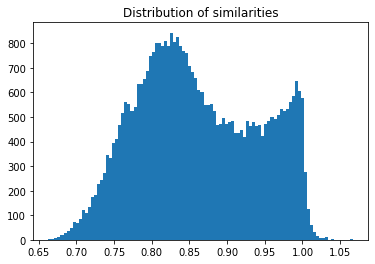

View  https://bbp.epfl.ch/neurosciencegraph/data/views/es/axon-coprojection-embeddings-view


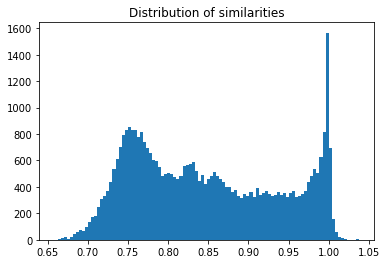

View  https://bbp.epfl.ch/neurosciencegraph/data/views/es/neurite-features-view


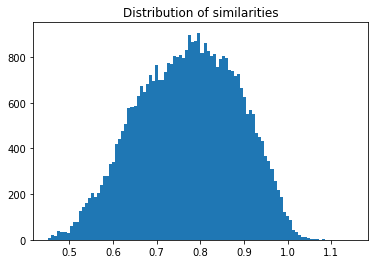

In [20]:
for view in views:
    print("View ", view)
    plt.hist(
        boosted_global_stats[view],
        bins=100)
    plt.title("Distribution of similarities")
    plt.show()